## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1096, 715)
Hypercube shape: (1096, 715, 102)


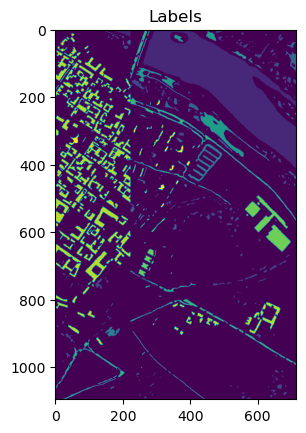

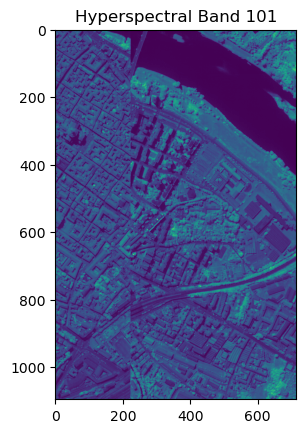

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Pavia_gt.mat'
data_files = 'Pavia.mat'
label_files = 'pavia_gt'
hypercube_files = 'pavia'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 148152
Extracted windows shape: (148152, 5, 5, 102)
Corresponding labels shape: (148152,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 10)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 65971 samples
Shuffled class indices for class '1'
Selected 10 training samples and 5 validation samples for class '1'

Class: 2: Found 7598 samples
Shuffled class indices for class '2'
Selected 10 training samples and 5 validation samples for class '2'

Class: 3: Found 3090 samples
Shuffled class indices for class '3'
Selected 10 training samples and 5 validation samples for class '3'

Class: 4: Found 2685 samples
Shuffled class indices for class '4'
Selected 10 training samples and 5 validation samples for class '4'

Class: 5: Found 6584 samples
Shuffled class indices for class '5'
Selected 10 training samples and 5 validation samples for class '5'

Class: 6: Found 9248 samples
Shuffled class indices for class '6'
Selected 10 training samples and 5 validation samples for class '6'

Class: 7: Found 7287 samples
Shuffled class indices for class '7'
Selected 10 train


 -- Test set created with: 
	148017 samples
	shape (148017, 5, 5, 102) --




All datasets saved to the 'indices' folder.
(90, 5, 5, 102)
(45, 5, 5, 102)
(148017, 5, 5, 102)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 90
Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (118521, 5, 5, 102)
Validation data shape: (29631, 5, 5, 102)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

102


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/1852], Loss: 0.1520, PSNR: 3.7659


	 Training Batch [200/1852], Loss: 0.0951, PSNR: 10.2191


	 Training Batch [400/1852], Loss: 0.0480, PSNR: 9.8234


	 Training Batch [600/1852], Loss: 0.0253, PSNR: 11.9382


	 Training Batch [800/1852], Loss: 0.0148, PSNR: 13.6801


	 Training Batch [1000/1852], Loss: 0.0140, PSNR: 16.1242


	 Training Batch [1200/1852], Loss: 0.0104, PSNR: 14.9249


	 Training Batch [1400/1852], Loss: 0.0074, PSNR: 16.9175


	 Training Batch [1600/1852], Loss: 0.0078, PSNR: 18.4228


	 Training Batch [1800/1852], Loss: 0.0056, PSNR: 16.8459


Epoch [1/50] Training Loss: 0.0324, PSNR: 13.6043
	[Val]   Batch [1/463] Loss: 0.0055, PSNR: 17.8513
	[Val]   Batch [10/463] Loss: 0.0051, PSNR: 19.0084
	[Val]   Batch [20/463] Loss: 0.0051, PSNR: 18.0026
	[Val]   Batch [30/463] Loss: 0.0061, PSNR: 18.6135
	[Val]   Batch [40/463] Loss: 0.0049, PSNR: 17.6930
	[Val]   Batch [50/463] Loss: 0.0051, PSNR: 17.9130
	[Val]   Batch [60/463] Loss: 0.0049, PSNR: 17.9462


	[Val]   Batch [70/463] Loss: 0.0069, PSNR: 18.3525
	[Val]   Batch [80/463] Loss: 0.0062, PSNR: 20.2288
	[Val]   Batch [90/463] Loss: 0.0059, PSNR: 19.3296
	[Val]   Batch [100/463] Loss: 0.0060, PSNR: 19.0300
	[Val]   Batch [110/463] Loss: 0.0069, PSNR: 18.4634
	[Val]   Batch [120/463] Loss: 0.0047, PSNR: 17.9534


	[Val]   Batch [130/463] Loss: 0.0056, PSNR: 19.3336
	[Val]   Batch [140/463] Loss: 0.0064, PSNR: 18.9659
	[Val]   Batch [150/463] Loss: 0.0074, PSNR: 18.9506
	[Val]   Batch [160/463] Loss: 0.0059, PSNR: 19.2208
	[Val]   Batch [170/463] Loss: 0.0076, PSNR: 18.1489
	[Val]   Batch [180/463] Loss: 0.0055, PSNR: 18.9431


	[Val]   Batch [190/463] Loss: 0.0060, PSNR: 19.2607
	[Val]   Batch [200/463] Loss: 0.0061, PSNR: 18.6272
	[Val]   Batch [210/463] Loss: 0.0058, PSNR: 18.2850
	[Val]   Batch [220/463] Loss: 0.0057, PSNR: 19.5027
	[Val]   Batch [230/463] Loss: 0.0068, PSNR: 19.3001
	[Val]   Batch [240/463] Loss: 0.0052, PSNR: 18.0633
	[Val]   Batch [250/463] Loss: 0.0066, PSNR: 17.3301


	[Val]   Batch [260/463] Loss: 0.0058, PSNR: 18.3097
	[Val]   Batch [270/463] Loss: 0.0045, PSNR: 17.4202
	[Val]   Batch [280/463] Loss: 0.0055, PSNR: 20.1692
	[Val]   Batch [290/463] Loss: 0.0060, PSNR: 17.1964
	[Val]   Batch [300/463] Loss: 0.0061, PSNR: 19.4312
	[Val]   Batch [310/463] Loss: 0.0056, PSNR: 19.3058
	[Val]   Batch [320/463] Loss: 0.0057, PSNR: 19.1752
	[Val]   Batch [330/463] Loss: 0.0066, PSNR: 18.5913


	[Val]   Batch [340/463] Loss: 0.0054, PSNR: 19.5231
	[Val]   Batch [350/463] Loss: 0.0071, PSNR: 19.4862
	[Val]   Batch [360/463] Loss: 0.0047, PSNR: 20.4034
	[Val]   Batch [370/463] Loss: 0.0069, PSNR: 18.5484
	[Val]   Batch [380/463] Loss: 0.0068, PSNR: 18.6822
	[Val]   Batch [390/463] Loss: 0.0063, PSNR: 18.4921


	[Val]   Batch [400/463] Loss: 0.0055, PSNR: 17.5334
	[Val]   Batch [410/463] Loss: 0.0054, PSNR: 19.8444
	[Val]   Batch [420/463] Loss: 0.0056, PSNR: 18.6619
	[Val]   Batch [430/463] Loss: 0.0055, PSNR: 18.0861
	[Val]   Batch [440/463] Loss: 0.0055, PSNR: 19.0328
	[Val]   Batch [450/463] Loss: 0.0042, PSNR: 16.4153
	[Val]   Batch [460/463] Loss: 0.0059, PSNR: 17.7886


Epoch [1/50] Validation Loss: 0.0058, PSNR: 18.6258

LOG: Epoch [2/50]
	 Training Batch [1/1852], Loss: 0.0052, PSNR: 18.3961


	 Training Batch [200/1852], Loss: 0.0056, PSNR: 19.8076


	 Training Batch [400/1852], Loss: 0.0051, PSNR: 19.5677


	 Training Batch [600/1852], Loss: 0.0055, PSNR: 19.4365


	 Training Batch [800/1852], Loss: 0.0032, PSNR: 18.1099


	 Training Batch [1000/1852], Loss: 0.0052, PSNR: 19.8819


	 Training Batch [1200/1852], Loss: 0.0050, PSNR: 20.6242


	 Training Batch [1400/1852], Loss: 0.0038, PSNR: 22.2874


	 Training Batch [1600/1852], Loss: 0.0025, PSNR: 22.2642


	 Training Batch [1800/1852], Loss: 0.0030, PSNR: 21.1450


Epoch [2/50] Training Loss: 0.0044, PSNR: 19.9884
	[Val]   Batch [1/463] Loss: 0.0027, PSNR: 20.9377
	[Val]   Batch [10/463] Loss: 0.0025, PSNR: 22.1457
	[Val]   Batch [20/463] Loss: 0.0024, PSNR: 21.2438
	[Val]   Batch [30/463] Loss: 0.0031, PSNR: 21.5815
	[Val]   Batch [40/463] Loss: 0.0024, PSNR: 20.7861
	[Val]   Batch [50/463] Loss: 0.0025, PSNR: 20.9971
	[Val]   Batch [60/463] Loss: 0.0024, PSNR: 21.0529


	[Val]   Batch [70/463] Loss: 0.0035, PSNR: 21.2330
	[Val]   Batch [80/463] Loss: 0.0032, PSNR: 23.1199
	[Val]   Batch [90/463] Loss: 0.0029, PSNR: 22.3928
	[Val]   Batch [100/463] Loss: 0.0032, PSNR: 21.8204
	[Val]   Batch [110/463] Loss: 0.0035, PSNR: 21.3842
	[Val]   Batch [120/463] Loss: 0.0023, PSNR: 21.0569
	[Val]   Batch [130/463] Loss: 0.0027, PSNR: 22.4588
	[Val]   Batch [140/463] Loss: 0.0033, PSNR: 21.8883


	[Val]   Batch [150/463] Loss: 0.0037, PSNR: 21.9831
	[Val]   Batch [160/463] Loss: 0.0031, PSNR: 22.0127
	[Val]   Batch [170/463] Loss: 0.0040, PSNR: 20.9741
	[Val]   Batch [180/463] Loss: 0.0030, PSNR: 21.6652
	[Val]   Batch [190/463] Loss: 0.0030, PSNR: 22.3249
	[Val]   Batch [200/463] Loss: 0.0030, PSNR: 21.6241
	[Val]   Batch [210/463] Loss: 0.0031, PSNR: 20.9974


	[Val]   Batch [220/463] Loss: 0.0030, PSNR: 22.3783
	[Val]   Batch [230/463] Loss: 0.0034, PSNR: 22.3595
	[Val]   Batch [240/463] Loss: 0.0026, PSNR: 21.1048
	[Val]   Batch [250/463] Loss: 0.0034, PSNR: 20.2167
	[Val]   Batch [260/463] Loss: 0.0030, PSNR: 21.2317
	[Val]   Batch [270/463] Loss: 0.0021, PSNR: 20.6969
	[Val]   Batch [280/463] Loss: 0.0027, PSNR: 23.2176


	[Val]   Batch [290/463] Loss: 0.0030, PSNR: 20.2575
	[Val]   Batch [300/463] Loss: 0.0030, PSNR: 22.4346
	[Val]   Batch [310/463] Loss: 0.0030, PSNR: 22.0824
	[Val]   Batch [320/463] Loss: 0.0029, PSNR: 22.1090
	[Val]   Batch [330/463] Loss: 0.0032, PSNR: 21.6942
	[Val]   Batch [340/463] Loss: 0.0027, PSNR: 22.5091
	[Val]   Batch [350/463] Loss: 0.0038, PSNR: 22.1698


	[Val]   Batch [360/463] Loss: 0.0025, PSNR: 23.1539
	[Val]   Batch [370/463] Loss: 0.0035, PSNR: 21.5738
	[Val]   Batch [380/463] Loss: 0.0033, PSNR: 21.8838
	[Val]   Batch [390/463] Loss: 0.0031, PSNR: 21.6198
	[Val]   Batch [400/463] Loss: 0.0029, PSNR: 20.4077
	[Val]   Batch [410/463] Loss: 0.0026, PSNR: 22.9809
	[Val]   Batch [420/463] Loss: 0.0027, PSNR: 21.7749
	[Val]   Batch [430/463] Loss: 0.0028, PSNR: 20.9436


	[Val]   Batch [440/463] Loss: 0.0028, PSNR: 21.8969
	[Val]   Batch [450/463] Loss: 0.0021, PSNR: 19.4704
	[Val]   Batch [460/463] Loss: 0.0029, PSNR: 20.9039
Epoch [2/50] Validation Loss: 0.0029, PSNR: 21.6384

LOG: Epoch [3/50]
	 Training Batch [1/1852], Loss: 0.0026, PSNR: 22.0864


	 Training Batch [200/1852], Loss: 0.0030, PSNR: 21.3332


	 Training Batch [400/1852], Loss: 0.0030, PSNR: 22.9919


	 Training Batch [600/1852], Loss: 0.0025, PSNR: 23.3644


	 Training Batch [800/1852], Loss: 0.0020, PSNR: 21.3890


	 Training Batch [1000/1852], Loss: 0.0021, PSNR: 24.5730


	 Training Batch [1200/1852], Loss: 0.0019, PSNR: 23.3319


	 Training Batch [1400/1852], Loss: 0.0021, PSNR: 24.5031


	 Training Batch [1600/1852], Loss: 0.0022, PSNR: 23.8907


	 Training Batch [1800/1852], Loss: 0.0020, PSNR: 22.4276


Epoch [3/50] Training Loss: 0.0024, PSNR: 22.6449
	[Val]   Batch [1/463] Loss: 0.0016, PSNR: 23.3244
	[Val]   Batch [10/463] Loss: 0.0015, PSNR: 24.4578
	[Val]   Batch [20/463] Loss: 0.0014, PSNR: 23.6142
	[Val]   Batch [30/463] Loss: 0.0017, PSNR: 24.2034
	[Val]   Batch [40/463] Loss: 0.0015, PSNR: 22.7958
	[Val]   Batch [50/463] Loss: 0.0015, PSNR: 23.1606
	[Val]   Batch [60/463] Loss: 0.0015, PSNR: 23.1912


	[Val]   Batch [70/463] Loss: 0.0019, PSNR: 23.8525
	[Val]   Batch [80/463] Loss: 0.0018, PSNR: 25.6799
	[Val]   Batch [90/463] Loss: 0.0017, PSNR: 24.7619
	[Val]   Batch [100/463] Loss: 0.0018, PSNR: 24.3039
	[Val]   Batch [110/463] Loss: 0.0019, PSNR: 24.0438
	[Val]   Batch [120/463] Loss: 0.0014, PSNR: 23.1266
	[Val]   Batch [130/463] Loss: 0.0015, PSNR: 25.1138


	[Val]   Batch [140/463] Loss: 0.0018, PSNR: 24.4305
	[Val]   Batch [150/463] Loss: 0.0019, PSNR: 24.8785
	[Val]   Batch [160/463] Loss: 0.0019, PSNR: 24.0939
	[Val]   Batch [170/463] Loss: 0.0023, PSNR: 23.4087
	[Val]   Batch [180/463] Loss: 0.0018, PSNR: 23.8722
	[Val]   Batch [190/463] Loss: 0.0017, PSNR: 24.8563
	[Val]   Batch [200/463] Loss: 0.0017, PSNR: 24.1503


	[Val]   Batch [210/463] Loss: 0.0019, PSNR: 23.1348
	[Val]   Batch [220/463] Loss: 0.0018, PSNR: 24.5742
	[Val]   Batch [230/463] Loss: 0.0017, PSNR: 25.4120
	[Val]   Batch [240/463] Loss: 0.0015, PSNR: 23.4322
	[Val]   Batch [250/463] Loss: 0.0020, PSNR: 22.5165
	[Val]   Batch [260/463] Loss: 0.0018, PSNR: 23.4785
	[Val]   Batch [270/463] Loss: 0.0013, PSNR: 22.7375
	[Val]   Batch [280/463] Loss: 0.0016, PSNR: 25.5530


	[Val]   Batch [290/463] Loss: 0.0017, PSNR: 22.6699
	[Val]   Batch [300/463] Loss: 0.0018, PSNR: 24.6642
	[Val]   Batch [310/463] Loss: 0.0019, PSNR: 24.0438
	[Val]   Batch [320/463] Loss: 0.0017, PSNR: 24.4568
	[Val]   Batch [330/463] Loss: 0.0018, PSNR: 24.3572
	[Val]   Batch [340/463] Loss: 0.0016, PSNR: 24.8207
	[Val]   Batch [350/463] Loss: 0.0022, PSNR: 24.5553
	[Val]   Batch [360/463] Loss: 0.0017, PSNR: 24.7668


	[Val]   Batch [370/463] Loss: 0.0019, PSNR: 24.2540
	[Val]   Batch [380/463] Loss: 0.0017, PSNR: 24.7971
	[Val]   Batch [390/463] Loss: 0.0016, PSNR: 24.3769
	[Val]   Batch [400/463] Loss: 0.0018, PSNR: 22.5091
	[Val]   Batch [410/463] Loss: 0.0015, PSNR: 25.3672
	[Val]   Batch [420/463] Loss: 0.0016, PSNR: 24.2122
	[Val]   Batch [430/463] Loss: 0.0018, PSNR: 22.9909
	[Val]   Batch [440/463] Loss: 0.0017, PSNR: 24.1057


	[Val]   Batch [450/463] Loss: 0.0014, PSNR: 21.2774
	[Val]   Batch [460/463] Loss: 0.0017, PSNR: 23.2449
Epoch [3/50] Validation Loss: 0.0017, PSNR: 24.0279

LOG: Epoch [4/50]
	 Training Batch [1/1852], Loss: 0.0022, PSNR: 24.0776


	 Training Batch [200/1852], Loss: 0.0017, PSNR: 23.7097


	 Training Batch [400/1852], Loss: 0.0015, PSNR: 24.4355


	 Training Batch [600/1852], Loss: 0.0021, PSNR: 22.8870


	 Training Batch [800/1852], Loss: 0.0018, PSNR: 23.8355


	 Training Batch [1000/1852], Loss: 0.0016, PSNR: 24.8118


	 Training Batch [1200/1852], Loss: 0.0014, PSNR: 23.6845


	 Training Batch [1400/1852], Loss: 0.0013, PSNR: 25.8383


	 Training Batch [1600/1852], Loss: 0.0014, PSNR: 24.9874


	 Training Batch [1800/1852], Loss: 0.0015, PSNR: 23.1897


Epoch [4/50] Training Loss: 0.0016, PSNR: 24.3210
	[Val]   Batch [1/463] Loss: 0.0011, PSNR: 24.7594
	[Val]   Batch [10/463] Loss: 0.0010, PSNR: 25.9403
	[Val]   Batch [20/463] Loss: 0.0010, PSNR: 25.1124
	[Val]   Batch [30/463] Loss: 0.0012, PSNR: 25.7350
	[Val]   Batch [40/463] Loss: 0.0011, PSNR: 24.1660
	[Val]   Batch [50/463] Loss: 0.0011, PSNR: 24.5749
	[Val]   Batch [60/463] Loss: 0.0011, PSNR: 24.5430


	[Val]   Batch [70/463] Loss: 0.0014, PSNR: 25.3612
	[Val]   Batch [80/463] Loss: 0.0012, PSNR: 27.3709
	[Val]   Batch [90/463] Loss: 0.0012, PSNR: 26.2898
	[Val]   Batch [100/463] Loss: 0.0013, PSNR: 25.8397
	[Val]   Batch [110/463] Loss: 0.0013, PSNR: 25.6860
	[Val]   Batch [120/463] Loss: 0.0010, PSNR: 24.5399
	[Val]   Batch [130/463] Loss: 0.0010, PSNR: 26.6550


	[Val]   Batch [140/463] Loss: 0.0013, PSNR: 25.9852
	[Val]   Batch [150/463] Loss: 0.0013, PSNR: 26.5603
	[Val]   Batch [160/463] Loss: 0.0014, PSNR: 25.4385
	[Val]   Batch [170/463] Loss: 0.0017, PSNR: 24.7981
	[Val]   Batch [180/463] Loss: 0.0013, PSNR: 25.2992
	[Val]   Batch [190/463] Loss: 0.0012, PSNR: 26.3386
	[Val]   Batch [200/463] Loss: 0.0012, PSNR: 25.8024
	[Val]   Batch [210/463] Loss: 0.0014, PSNR: 24.4971


	[Val]   Batch [220/463] Loss: 0.0013, PSNR: 25.9771
	[Val]   Batch [230/463] Loss: 0.0011, PSNR: 27.2167
	[Val]   Batch [240/463] Loss: 0.0011, PSNR: 24.9356
	[Val]   Batch [250/463] Loss: 0.0014, PSNR: 23.9072
	[Val]   Batch [260/463] Loss: 0.0013, PSNR: 24.7858
	[Val]   Batch [270/463] Loss: 0.0009, PSNR: 24.2414
	[Val]   Batch [280/463] Loss: 0.0011, PSNR: 27.0009
	[Val]   Batch [290/463] Loss: 0.0012, PSNR: 24.1986


	[Val]   Batch [300/463] Loss: 0.0013, PSNR: 25.9802
	[Val]   Batch [310/463] Loss: 0.0014, PSNR: 25.4204
	[Val]   Batch [320/463] Loss: 0.0012, PSNR: 26.0046
	[Val]   Batch [330/463] Loss: 0.0012, PSNR: 25.9648
	[Val]   Batch [340/463] Loss: 0.0011, PSNR: 26.3024
	[Val]   Batch [350/463] Loss: 0.0016, PSNR: 26.0387
	[Val]   Batch [360/463] Loss: 0.0014, PSNR: 25.8157
	[Val]   Batch [370/463] Loss: 0.0013, PSNR: 25.8729


	[Val]   Batch [380/463] Loss: 0.0011, PSNR: 26.5553
	[Val]   Batch [390/463] Loss: 0.0011, PSNR: 26.0506
	[Val]   Batch [400/463] Loss: 0.0013, PSNR: 23.8489
	[Val]   Batch [410/463] Loss: 0.0011, PSNR: 26.8443
	[Val]   Batch [420/463] Loss: 0.0011, PSNR: 25.6904
	[Val]   Batch [430/463] Loss: 0.0013, PSNR: 24.2623
	[Val]   Batch [440/463] Loss: 0.0012, PSNR: 25.5130


	[Val]   Batch [450/463] Loss: 0.0010, PSNR: 22.5889
	[Val]   Batch [460/463] Loss: 0.0012, PSNR: 24.6571
Epoch [4/50] Validation Loss: 0.0012, PSNR: 25.5241

LOG: Epoch [5/50]
	 Training Batch [1/1852], Loss: 0.0015, PSNR: 26.6442


	 Training Batch [200/1852], Loss: 0.0015, PSNR: 26.0997


	 Training Batch [400/1852], Loss: 0.0012, PSNR: 24.5022


	 Training Batch [600/1852], Loss: 0.0011, PSNR: 26.1740


	 Training Batch [800/1852], Loss: 0.0013, PSNR: 24.2235


	 Training Batch [1000/1852], Loss: 0.0011, PSNR: 24.1599


	 Training Batch [1200/1852], Loss: 0.0014, PSNR: 26.2621


	 Training Batch [1400/1852], Loss: 0.0011, PSNR: 23.8943


	 Training Batch [1600/1852], Loss: 0.0011, PSNR: 24.9853


	 Training Batch [1800/1852], Loss: 0.0011, PSNR: 25.9173


Epoch [5/50] Training Loss: 0.0012, PSNR: 25.4704
	[Val]   Batch [1/463] Loss: 0.0009, PSNR: 25.8152
	[Val]   Batch [10/463] Loss: 0.0008, PSNR: 27.1230
	[Val]   Batch [20/463] Loss: 0.0008, PSNR: 26.3277
	[Val]   Batch [30/463] Loss: 0.0009, PSNR: 26.7307
	[Val]   Batch [40/463] Loss: 0.0009, PSNR: 25.2386
	[Val]   Batch [50/463] Loss: 0.0008, PSNR: 25.7647
	[Val]   Batch [60/463] Loss: 0.0008, PSNR: 25.6148


	[Val]   Batch [70/463] Loss: 0.0011, PSNR: 26.3928
	[Val]   Batch [80/463] Loss: 0.0009, PSNR: 28.7083
	[Val]   Batch [90/463] Loss: 0.0009, PSNR: 27.3804
	[Val]   Batch [100/463] Loss: 0.0010, PSNR: 26.9664
	[Val]   Batch [110/463] Loss: 0.0010, PSNR: 26.8248
	[Val]   Batch [120/463] Loss: 0.0008, PSNR: 25.7298
	[Val]   Batch [130/463] Loss: 0.0008, PSNR: 27.7481


	[Val]   Batch [140/463] Loss: 0.0010, PSNR: 27.0767
	[Val]   Batch [150/463] Loss: 0.0010, PSNR: 27.7287
	[Val]   Batch [160/463] Loss: 0.0011, PSNR: 26.4329
	[Val]   Batch [170/463] Loss: 0.0013, PSNR: 25.7131
	[Val]   Batch [180/463] Loss: 0.0010, PSNR: 26.3719
	[Val]   Batch [190/463] Loss: 0.0009, PSNR: 27.4911
	[Val]   Batch [200/463] Loss: 0.0009, PSNR: 27.1232


	[Val]   Batch [210/463] Loss: 0.0011, PSNR: 25.5237
	[Val]   Batch [220/463] Loss: 0.0010, PSNR: 26.9481
	[Val]   Batch [230/463] Loss: 0.0009, PSNR: 28.3514
	[Val]   Batch [240/463] Loss: 0.0008, PSNR: 26.1459
	[Val]   Batch [250/463] Loss: 0.0012, PSNR: 24.8870
	[Val]   Batch [260/463] Loss: 0.0010, PSNR: 25.7430
	[Val]   Batch [270/463] Loss: 0.0007, PSNR: 25.6076


	[Val]   Batch [280/463] Loss: 0.0009, PSNR: 28.1876
	[Val]   Batch [290/463] Loss: 0.0009, PSNR: 25.2423
	[Val]   Batch [300/463] Loss: 0.0011, PSNR: 27.0092
	[Val]   Batch [310/463] Loss: 0.0011, PSNR: 26.5671
	[Val]   Batch [320/463] Loss: 0.0009, PSNR: 27.2508
	[Val]   Batch [330/463] Loss: 0.0009, PSNR: 27.0875
	[Val]   Batch [340/463] Loss: 0.0009, PSNR: 27.5038


	[Val]   Batch [350/463] Loss: 0.0012, PSNR: 27.0004
	[Val]   Batch [360/463] Loss: 0.0011, PSNR: 26.7025
	[Val]   Batch [370/463] Loss: 0.0010, PSNR: 26.8671
	[Val]   Batch [380/463] Loss: 0.0008, PSNR: 27.7942
	[Val]   Batch [390/463] Loss: 0.0008, PSNR: 27.2208
	[Val]   Batch [400/463] Loss: 0.0010, PSNR: 24.8619
	[Val]   Batch [410/463] Loss: 0.0008, PSNR: 28.0127


	[Val]   Batch [420/463] Loss: 0.0009, PSNR: 26.7987
	[Val]   Batch [430/463] Loss: 0.0011, PSNR: 25.2405
	[Val]   Batch [440/463] Loss: 0.0010, PSNR: 26.5418
	[Val]   Batch [450/463] Loss: 0.0008, PSNR: 23.7898
	[Val]   Batch [460/463] Loss: 0.0010, PSNR: 25.7141
Epoch [5/50] Validation Loss: 0.0009, PSNR: 26.6545

LOG: Epoch [6/50]
	 Training Batch [1/1852], Loss: 0.0010, PSNR: 23.7531


	 Training Batch [200/1852], Loss: 0.0010, PSNR: 27.8113


	 Training Batch [400/1852], Loss: 0.0014, PSNR: 26.2595


	 Training Batch [600/1852], Loss: 0.0010, PSNR: 25.2075


	 Training Batch [800/1852], Loss: 0.0011, PSNR: 26.8411


	 Training Batch [1000/1852], Loss: 0.0008, PSNR: 25.9411


	 Training Batch [1200/1852], Loss: 0.0008, PSNR: 26.2175


	 Training Batch [1400/1852], Loss: 0.0009, PSNR: 26.8619


	 Training Batch [1600/1852], Loss: 0.0013, PSNR: 25.6670


	 Training Batch [1800/1852], Loss: 0.0009, PSNR: 24.0932


Epoch [6/50] Training Loss: 0.0010, PSNR: 26.2936
	[Val]   Batch [1/463] Loss: 0.0007, PSNR: 26.6995
	[Val]   Batch [10/463] Loss: 0.0006, PSNR: 28.0647
	[Val]   Batch [20/463] Loss: 0.0006, PSNR: 27.2986
	[Val]   Batch [30/463] Loss: 0.0008, PSNR: 27.6794
	[Val]   Batch [40/463] Loss: 0.0007, PSNR: 26.1035
	[Val]   Batch [50/463] Loss: 0.0007, PSNR: 26.7010


	[Val]   Batch [60/463] Loss: 0.0007, PSNR: 26.5037
	[Val]   Batch [70/463] Loss: 0.0009, PSNR: 27.3340
	[Val]   Batch [80/463] Loss: 0.0007, PSNR: 29.8493
	[Val]   Batch [90/463] Loss: 0.0007, PSNR: 28.3922
	[Val]   Batch [100/463] Loss: 0.0008, PSNR: 27.9297
	[Val]   Batch [110/463] Loss: 0.0008, PSNR: 27.8410
	[Val]   Batch [120/463] Loss: 0.0006, PSNR: 26.6643


	[Val]   Batch [130/463] Loss: 0.0006, PSNR: 28.7010
	[Val]   Batch [140/463] Loss: 0.0008, PSNR: 28.0944
	[Val]   Batch [150/463] Loss: 0.0008, PSNR: 28.8150
	[Val]   Batch [160/463] Loss: 0.0009, PSNR: 27.2729
	[Val]   Batch [170/463] Loss: 0.0011, PSNR: 26.6030
	[Val]   Batch [180/463] Loss: 0.0008, PSNR: 27.3333
	[Val]   Batch [190/463] Loss: 0.0007, PSNR: 28.3644
	[Val]   Batch [200/463] Loss: 0.0007, PSNR: 28.1895


	[Val]   Batch [210/463] Loss: 0.0009, PSNR: 26.4202
	[Val]   Batch [220/463] Loss: 0.0008, PSNR: 27.8453
	[Val]   Batch [230/463] Loss: 0.0007, PSNR: 29.4447
	[Val]   Batch [240/463] Loss: 0.0006, PSNR: 27.1234
	[Val]   Batch [250/463] Loss: 0.0009, PSNR: 25.7874
	[Val]   Batch [260/463] Loss: 0.0009, PSNR: 26.5782
	[Val]   Batch [270/463] Loss: 0.0005, PSNR: 26.6327


	[Val]   Batch [280/463] Loss: 0.0007, PSNR: 29.1117
	[Val]   Batch [290/463] Loss: 0.0008, PSNR: 26.2080
	[Val]   Batch [300/463] Loss: 0.0009, PSNR: 27.8011
	[Val]   Batch [310/463] Loss: 0.0009, PSNR: 27.4605
	[Val]   Batch [320/463] Loss: 0.0007, PSNR: 28.2829
	[Val]   Batch [330/463] Loss: 0.0007, PSNR: 28.1144
	[Val]   Batch [340/463] Loss: 0.0007, PSNR: 28.4793


	[Val]   Batch [350/463] Loss: 0.0010, PSNR: 27.9363
	[Val]   Batch [360/463] Loss: 0.0010, PSNR: 27.3480
	[Val]   Batch [370/463] Loss: 0.0008, PSNR: 27.9159
	[Val]   Batch [380/463] Loss: 0.0007, PSNR: 28.9066
	[Val]   Batch [390/463] Loss: 0.0007, PSNR: 28.2871
	[Val]   Batch [400/463] Loss: 0.0008, PSNR: 25.7140


	[Val]   Batch [410/463] Loss: 0.0007, PSNR: 28.9642
	[Val]   Batch [420/463] Loss: 0.0007, PSNR: 27.7485
	[Val]   Batch [430/463] Loss: 0.0009, PSNR: 26.0470
	[Val]   Batch [440/463] Loss: 0.0008, PSNR: 27.4637
	[Val]   Batch [450/463] Loss: 0.0006, PSNR: 24.6902
	[Val]   Batch [460/463] Loss: 0.0008, PSNR: 26.5739
Epoch [6/50] Validation Loss: 0.0007, PSNR: 27.6220

LOG: Epoch [7/50]
	 Training Batch [1/1852], Loss: 0.0011, PSNR: 25.4388


	 Training Batch [200/1852], Loss: 0.0010, PSNR: 25.6817


	 Training Batch [400/1852], Loss: 0.0010, PSNR: 25.5636


	 Training Batch [600/1852], Loss: 0.0008, PSNR: 25.7870


	 Training Batch [800/1852], Loss: 0.0009, PSNR: 26.3543


	 Training Batch [1000/1852], Loss: 0.0009, PSNR: 27.8792


	 Training Batch [1200/1852], Loss: 0.0007, PSNR: 27.9667


	 Training Batch [1400/1852], Loss: 0.0010, PSNR: 25.7165


	 Training Batch [1600/1852], Loss: 0.0009, PSNR: 26.2133


	 Training Batch [1800/1852], Loss: 0.0007, PSNR: 28.8517


Epoch [7/50] Training Loss: 0.0009, PSNR: 26.9382
	[Val]   Batch [1/463] Loss: 0.0006, PSNR: 27.3648
	[Val]   Batch [10/463] Loss: 0.0005, PSNR: 28.7578
	[Val]   Batch [20/463] Loss: 0.0005, PSNR: 27.9301
	[Val]   Batch [30/463] Loss: 0.0006, PSNR: 28.4318
	[Val]   Batch [40/463] Loss: 0.0006, PSNR: 26.7868
	[Val]   Batch [50/463] Loss: 0.0006, PSNR: 27.4489
	[Val]   Batch [60/463] Loss: 0.0006, PSNR: 27.0792


	[Val]   Batch [70/463] Loss: 0.0007, PSNR: 28.0739
	[Val]   Batch [80/463] Loss: 0.0006, PSNR: 30.6654
	[Val]   Batch [90/463] Loss: 0.0006, PSNR: 29.1279
	[Val]   Batch [100/463] Loss: 0.0006, PSNR: 28.7517
	[Val]   Batch [110/463] Loss: 0.0007, PSNR: 28.6561
	[Val]   Batch [120/463] Loss: 0.0005, PSNR: 27.3388
	[Val]   Batch [130/463] Loss: 0.0005, PSNR: 29.4179


	[Val]   Batch [140/463] Loss: 0.0007, PSNR: 28.8587
	[Val]   Batch [150/463] Loss: 0.0006, PSNR: 29.5646
	[Val]   Batch [160/463] Loss: 0.0008, PSNR: 27.9186
	[Val]   Batch [170/463] Loss: 0.0009, PSNR: 27.3782
	[Val]   Batch [180/463] Loss: 0.0007, PSNR: 28.1002
	[Val]   Batch [190/463] Loss: 0.0006, PSNR: 29.0109
	[Val]   Batch [200/463] Loss: 0.0006, PSNR: 28.8409


	[Val]   Batch [210/463] Loss: 0.0008, PSNR: 27.1608
	[Val]   Batch [220/463] Loss: 0.0007, PSNR: 28.5978
	[Val]   Batch [230/463] Loss: 0.0005, PSNR: 30.2471
	[Val]   Batch [240/463] Loss: 0.0005, PSNR: 27.8389
	[Val]   Batch [250/463] Loss: 0.0008, PSNR: 26.5352
	[Val]   Batch [260/463] Loss: 0.0007, PSNR: 27.2467
	[Val]   Batch [270/463] Loss: 0.0005, PSNR: 27.2825
	[Val]   Batch [280/463] Loss: 0.0006, PSNR: 29.8305


	[Val]   Batch [290/463] Loss: 0.0006, PSNR: 27.0221
	[Val]   Batch [300/463] Loss: 0.0008, PSNR: 28.3800
	[Val]   Batch [310/463] Loss: 0.0007, PSNR: 28.1675
	[Val]   Batch [320/463] Loss: 0.0006, PSNR: 29.1278
	[Val]   Batch [330/463] Loss: 0.0006, PSNR: 28.8749
	[Val]   Batch [340/463] Loss: 0.0006, PSNR: 29.1998
	[Val]   Batch [350/463] Loss: 0.0008, PSNR: 28.7154


	[Val]   Batch [360/463] Loss: 0.0009, PSNR: 27.8234
	[Val]   Batch [370/463] Loss: 0.0007, PSNR: 28.7723
	[Val]   Batch [380/463] Loss: 0.0005, PSNR: 29.6804
	[Val]   Batch [390/463] Loss: 0.0006, PSNR: 29.0547
	[Val]   Batch [400/463] Loss: 0.0007, PSNR: 26.3983
	[Val]   Batch [410/463] Loss: 0.0006, PSNR: 29.6180
	[Val]   Batch [420/463] Loss: 0.0006, PSNR: 28.4319


	[Val]   Batch [430/463] Loss: 0.0007, PSNR: 26.7558
	[Val]   Batch [440/463] Loss: 0.0007, PSNR: 28.1501
	[Val]   Batch [450/463] Loss: 0.0005, PSNR: 25.3729
	[Val]   Batch [460/463] Loss: 0.0007, PSNR: 27.2298
Epoch [7/50] Validation Loss: 0.0006, PSNR: 28.3449

LOG: Epoch [8/50]
	 Training Batch [1/1852], Loss: 0.0008, PSNR: 27.2420


	 Training Batch [200/1852], Loss: 0.0008, PSNR: 27.0358


	 Training Batch [400/1852], Loss: 0.0010, PSNR: 27.4181


	 Training Batch [600/1852], Loss: 0.0007, PSNR: 27.3292


	 Training Batch [800/1852], Loss: 0.0008, PSNR: 27.4267


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 27.9757


	 Training Batch [1200/1852], Loss: 0.0007, PSNR: 28.1725


	 Training Batch [1400/1852], Loss: 0.0007, PSNR: 26.4255


	 Training Batch [1600/1852], Loss: 0.0007, PSNR: 28.4961


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 28.3276


Epoch [8/50] Training Loss: 0.0008, PSNR: 27.5318
	[Val]   Batch [1/463] Loss: 0.0005, PSNR: 28.1423
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 29.7050
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 28.8978
	[Val]   Batch [30/463] Loss: 0.0005, PSNR: 29.2262
	[Val]   Batch [40/463] Loss: 0.0005, PSNR: 27.6286
	[Val]   Batch [50/463] Loss: 0.0005, PSNR: 28.4181
	[Val]   Batch [60/463] Loss: 0.0005, PSNR: 27.9425


	[Val]   Batch [70/463] Loss: 0.0006, PSNR: 28.8133
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 31.5929
	[Val]   Batch [90/463] Loss: 0.0005, PSNR: 30.0067
	[Val]   Batch [100/463] Loss: 0.0005, PSNR: 29.5552
	[Val]   Batch [110/463] Loss: 0.0006, PSNR: 29.4472
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 28.1972
	[Val]   Batch [130/463] Loss: 0.0005, PSNR: 30.2382


	[Val]   Batch [140/463] Loss: 0.0005, PSNR: 29.6419
	[Val]   Batch [150/463] Loss: 0.0005, PSNR: 30.4799
	[Val]   Batch [160/463] Loss: 0.0007, PSNR: 28.7247
	[Val]   Batch [170/463] Loss: 0.0008, PSNR: 28.1051
	[Val]   Batch [180/463] Loss: 0.0006, PSNR: 28.9241
	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 29.8545
	[Val]   Batch [200/463] Loss: 0.0005, PSNR: 29.7538
	[Val]   Batch [210/463] Loss: 0.0006, PSNR: 27.9437


	[Val]   Batch [220/463] Loss: 0.0006, PSNR: 29.3716
	[Val]   Batch [230/463] Loss: 0.0005, PSNR: 31.0754
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 28.7353
	[Val]   Batch [250/463] Loss: 0.0007, PSNR: 27.3504
	[Val]   Batch [260/463] Loss: 0.0006, PSNR: 28.0672
	[Val]   Batch [270/463] Loss: 0.0004, PSNR: 28.3107
	[Val]   Batch [280/463] Loss: 0.0005, PSNR: 30.6575


	[Val]   Batch [290/463] Loss: 0.0005, PSNR: 27.8780
	[Val]   Batch [300/463] Loss: 0.0007, PSNR: 29.0794
	[Val]   Batch [310/463] Loss: 0.0006, PSNR: 28.9801
	[Val]   Batch [320/463] Loss: 0.0005, PSNR: 30.0409
	[Val]   Batch [330/463] Loss: 0.0005, PSNR: 29.7460
	[Val]   Batch [340/463] Loss: 0.0005, PSNR: 30.0730
	[Val]   Batch [350/463] Loss: 0.0007, PSNR: 29.4500
	[Val]   Batch [360/463] Loss: 0.0008, PSNR: 28.3994


	[Val]   Batch [370/463] Loss: 0.0005, PSNR: 29.6008
	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 30.6947
	[Val]   Batch [390/463] Loss: 0.0005, PSNR: 29.9223
	[Val]   Batch [400/463] Loss: 0.0006, PSNR: 27.1510
	[Val]   Batch [410/463] Loss: 0.0005, PSNR: 30.4813
	[Val]   Batch [420/463] Loss: 0.0005, PSNR: 29.3826
	[Val]   Batch [430/463] Loss: 0.0006, PSNR: 27.5729


	[Val]   Batch [440/463] Loss: 0.0006, PSNR: 28.8060
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 26.2108
	[Val]   Batch [460/463] Loss: 0.0005, PSNR: 28.1277
Epoch [8/50] Validation Loss: 0.0005, PSNR: 29.2037

LOG: Epoch [9/50]
	 Training Batch [1/1852], Loss: 0.0008, PSNR: 28.3010


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 30.7557


	 Training Batch [400/1852], Loss: 0.0006, PSNR: 26.8885


	 Training Batch [600/1852], Loss: 0.0011, PSNR: 27.2823


	 Training Batch [800/1852], Loss: 0.0006, PSNR: 27.3687


	 Training Batch [1000/1852], Loss: 0.0010, PSNR: 26.1685


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 29.2000


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 29.3322


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 29.7902


	 Training Batch [1800/1852], Loss: 0.0008, PSNR: 26.5595


Epoch [9/50] Training Loss: 0.0007, PSNR: 28.0378
	[Val]   Batch [1/463] Loss: 0.0005, PSNR: 28.6013
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 30.3159
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 29.4230
	[Val]   Batch [30/463] Loss: 0.0005, PSNR: 29.7419
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.0759
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 29.0063
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 28.4730


	[Val]   Batch [70/463] Loss: 0.0005, PSNR: 29.4056
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 32.2473
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 30.5465
	[Val]   Batch [100/463] Loss: 0.0005, PSNR: 30.1577
	[Val]   Batch [110/463] Loss: 0.0005, PSNR: 30.0654
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 28.6264
	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 30.7881
	[Val]   Batch [140/463] Loss: 0.0005, PSNR: 30.1350


	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 31.1568
	[Val]   Batch [160/463] Loss: 0.0006, PSNR: 29.2781
	[Val]   Batch [170/463] Loss: 0.0007, PSNR: 28.6763
	[Val]   Batch [180/463] Loss: 0.0005, PSNR: 29.4289
	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 30.3838
	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.3679
	[Val]   Batch [210/463] Loss: 0.0006, PSNR: 28.5111


	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 29.7640
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 31.5801
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 29.3153
	[Val]   Batch [250/463] Loss: 0.0006, PSNR: 27.9168
	[Val]   Batch [260/463] Loss: 0.0005, PSNR: 28.6577
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 28.8629
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.1130
	[Val]   Batch [290/463] Loss: 0.0005, PSNR: 28.4391


	[Val]   Batch [300/463] Loss: 0.0006, PSNR: 29.5175
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 29.5151
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 30.6171
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 30.3413
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 30.6068
	[Val]   Batch [350/463] Loss: 0.0006, PSNR: 29.9818
	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.6884
	[Val]   Batch [370/463] Loss: 0.0005, PSNR: 30.0793


	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 31.3067
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.5100
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 27.6281
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.0360
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 29.8320
	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.1138
	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.2926


	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 26.6452
	[Val]   Batch [460/463] Loss: 0.0005, PSNR: 28.6844
Epoch [9/50] Validation Loss: 0.0005, PSNR: 29.7496

LOG: Epoch [10/50]
	 Training Batch [1/1852], Loss: 0.0008, PSNR: 27.0580


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 28.4611


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 28.3241


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 28.0170


	 Training Batch [800/1852], Loss: 0.0006, PSNR: 29.8395


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 29.3163


	 Training Batch [1200/1852], Loss: 0.0007, PSNR: 27.5980


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 29.9190


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 28.2134


	 Training Batch [1800/1852], Loss: 0.0007, PSNR: 27.3017


Epoch [10/50] Training Loss: 0.0006, PSNR: 28.4218
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.1066
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 30.8294
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 29.9399
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.3190
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.6352
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 29.5297
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 28.9775


	[Val]   Batch [70/463] Loss: 0.0005, PSNR: 29.9586
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 32.8440
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 31.0999
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 30.6748
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 30.6161
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 29.1818
	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 31.2944
	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 30.7163


	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 31.7598
	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 29.8532
	[Val]   Batch [170/463] Loss: 0.0006, PSNR: 29.2192
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.0330
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 30.8467
	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.8613
	[Val]   Batch [210/463] Loss: 0.0005, PSNR: 29.1440
	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 30.3269


	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.2241
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 29.8757
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.4456
	[Val]   Batch [260/463] Loss: 0.0005, PSNR: 29.2447
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.4833
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.6616
	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 29.0405


	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 29.9935
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 30.0735
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 31.1209
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 30.8556
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 31.1458
	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 30.5862
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.0424


	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 30.6841
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 31.8522
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.0541
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 28.1551
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.5012
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 30.4250


	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.6353
	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.8263
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.2371
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.2821
Epoch [10/50] Validation Loss: 0.0004, PSNR: 30.3022

LOG: Epoch [11/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 29.3670


	 Training Batch [200/1852], Loss: 0.0004, PSNR: 30.0271


	 Training Batch [400/1852], Loss: 0.0006, PSNR: 29.4450


	 Training Batch [600/1852], Loss: 0.0007, PSNR: 27.3276


	 Training Batch [800/1852], Loss: 0.0006, PSNR: 28.2016


	 Training Batch [1000/1852], Loss: 0.0008, PSNR: 27.3853


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 28.2502


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 28.4005


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 27.5143


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 28.8656


Epoch [11/50] Training Loss: 0.0006, PSNR: 28.7634
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.3939
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.1954
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.3083
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.6281
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.9729
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 29.8865
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 29.3753


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.3153
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.2116
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 31.4050
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 31.0483
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 31.0031
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.5250
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 31.5992


	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 30.9849
	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 32.1768
	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 30.2956
	[Val]   Batch [170/463] Loss: 0.0006, PSNR: 29.5404
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.4153
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.2283
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.3053


	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 29.5326
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 30.5705
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.4648
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.2821
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.7919
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 29.6722
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.8769


	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.9966
	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 29.3723
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.2803
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.5151
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 31.5215
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 31.1494
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 31.5041


	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 30.9185
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.2860
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 30.9064
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.1772
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.3627
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.4524
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 31.8082


	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 30.6805
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 28.9516
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.1293
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.6309
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.6541
Epoch [11/50] Validation Loss: 0.0004, PSNR: 30.6506

LOG: Epoch [12/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 30.6272


	 Training Batch [200/1852], Loss: 0.0005, PSNR: 29.8462


	 Training Batch [400/1852], Loss: 0.0004, PSNR: 29.4888


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 30.5419


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 28.5596


	 Training Batch [1000/1852], Loss: 0.0008, PSNR: 28.3749


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 30.8006


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 29.5782


	 Training Batch [1600/1852], Loss: 0.0004, PSNR: 30.8544


	 Training Batch [1800/1852], Loss: 0.0004, PSNR: 30.2819


Epoch [12/50] Training Loss: 0.0005, PSNR: 29.0972
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.6818
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.5395
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.6015
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.9301
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.2276
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.2898
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 29.7132


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.7226
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.5590
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 31.7671
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.4021
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 31.3943
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.7801


	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 31.9689
	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.3117
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.5996
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 30.7100
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 29.9625
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.7586
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.5013


	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.6517
	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 29.9142
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 30.8648
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.8412
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.6299
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.2084
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 30.1126


	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.1171
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.2986
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 29.7061
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.6297
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.8334
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 31.9004
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.4985


	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 31.8290
	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 31.2767
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.4749
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 31.2470
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.5762
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.6665
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.7661


	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 31.9990
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.0320
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.2845
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.4009
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.9109
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 30.0313
Epoch [12/50] Validation Loss: 0.0003, PSNR: 30.9936

LOG: Epoch [13/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 30.7973


	 Training Batch [200/1852], Loss: 0.0004, PSNR: 30.2329


	 Training Batch [400/1852], Loss: 0.0005, PSNR: 28.6556


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 28.3578


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 29.2923


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 31.1649


	 Training Batch [1200/1852], Loss: 0.0004, PSNR: 30.8099


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 27.7972


	 Training Batch [1600/1852], Loss: 0.0004, PSNR: 29.4293


	 Training Batch [1800/1852], Loss: 0.0004, PSNR: 31.0220


Epoch [13/50] Training Loss: 0.0005, PSNR: 29.3465
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.0673
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.8753
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.9155
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.3442
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.5644
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.5638


	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.0571
	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 31.1405
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.9439
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.1200
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.7981
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 31.8510
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.0590
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.3611


	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 31.7090
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 33.0883
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 31.1096
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 30.3555
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.1108
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 31.8240


	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.9615
	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 30.3645
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.1777
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.2533
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.9893
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.5808
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 30.5486


	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.4664
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.6359
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.1023
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.0193
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 31.1906
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.2372
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.8790
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.2193


	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 31.6859
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.6825
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 31.7143
	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.0855
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 32.1105
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.1360
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.3451
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.4029


	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.6282
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.7363
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.2673
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.5005
Epoch [13/50] Validation Loss: 0.0003, PSNR: 31.3625
Early stopping triggered at epoch 13. No improvement for 3 epochs.


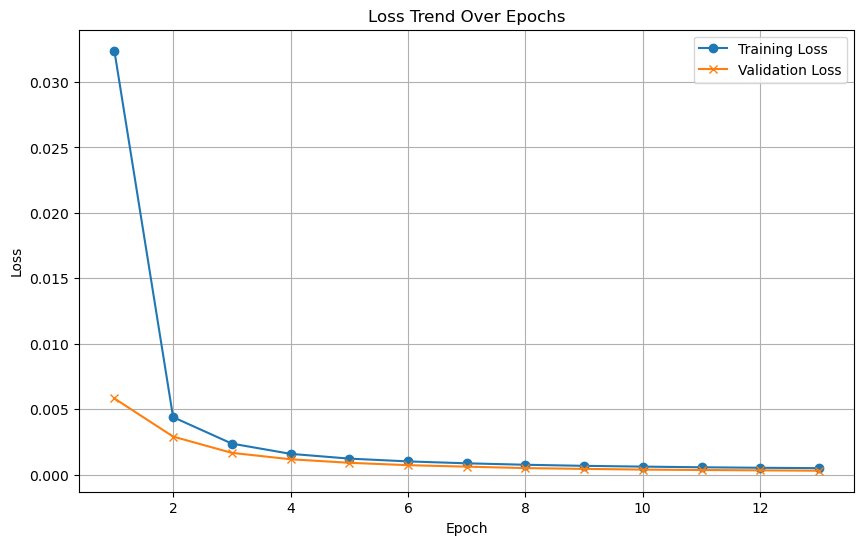

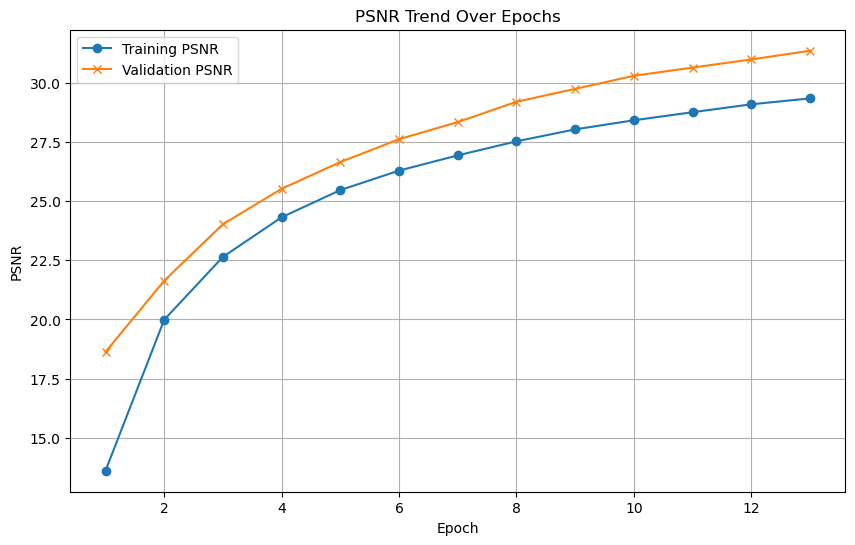

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/579 for test dataset.


    Processed batch 101/579 for test dataset.


    Processed batch 201/579 for test dataset.


    Processed batch 301/579 for test dataset.


    Processed batch 401/579 for test dataset.


    Processed batch 501/579 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.2056
    Validation Batch [1/1], Loss: 2.2016
Validation Loss: 2.2016, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2016. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1639
    Validation Batch [1/1], Loss: 2.2015
Validation Loss: 2.2015, Validation Accuracy: 11.11%
Validation loss improved from 2.2016 to 2.2015. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.0863
    Validation Batch [1/1], Loss: 2.2014
Validation Loss: 2.2014, Validation Accuracy: 11.11%
Validation loss improved from 2.2015 to 2.2014. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.0678
    Validation Batch [1/1], Loss: 2.2014
Validation Loss: 2.2014, Validation Accuracy: 11.11%
Validation loss improved from 2.2014 to 2.2014. Saving model...

LOG: Epoch [5/1000

Epoch [7/1000] completed, Average Training Loss: 1.9772
    Validation Batch [1/1], Loss: 2.2014
Validation Loss: 2.2014, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [8/1000] - Training
Epoch [8/1000] completed, Average Training Loss: 1.9703
    Validation Batch [1/1], Loss: 2.2014
Validation Loss: 2.2014, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [9/1000] - Training
Epoch [9/1000] completed, Average Training Loss: 1.9485
    Validation Batch [1/1], Loss: 2.2015
Validation Loss: 2.2015, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 1.9289
    Validation Batch [1/1], Loss: 2.2015
Validation Loss: 2.2015, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 1.9244
    Validation B

    Validation Batch [1/1], Loss: 2.0701
Validation Loss: 2.0701, Validation Accuracy: 46.67%
Validation loss improved from 2.0858 to 2.0701. Saving model...

LOG: Epoch [39/1000] - Training
Epoch [39/1000] completed, Average Training Loss: 1.5734
    Validation Batch [1/1], Loss: 2.0535
Validation Loss: 2.0535, Validation Accuracy: 46.67%
Validation loss improved from 2.0701 to 2.0535. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 1.5428
    Validation Batch [1/1], Loss: 2.0344
Validation Loss: 2.0344, Validation Accuracy: 51.11%
Validation loss improved from 2.0535 to 2.0344. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 1.5371
    Validation Batch [1/1], Loss: 2.0132
Validation Loss: 2.0132, Validation Accuracy: 53.33%
Validation loss improved from 2.0344 to 2.0132. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [42/1000] completed, Average Training Loss: 1.5677
    Vali

    Validation Batch [1/1], Loss: 1.4698
Validation Loss: 1.4698, Validation Accuracy: 84.44%
Validation loss improved from 1.4855 to 1.4698. Saving model...

LOG: Epoch [68/1000] - Training
Epoch [68/1000] completed, Average Training Loss: 1.2766
    Validation Batch [1/1], Loss: 1.4528
Validation Loss: 1.4528, Validation Accuracy: 86.67%
Validation loss improved from 1.4698 to 1.4528. Saving model...

LOG: Epoch [69/1000] - Training
Epoch [69/1000] completed, Average Training Loss: 1.2957
    Validation Batch [1/1], Loss: 1.4386
Validation Loss: 1.4386, Validation Accuracy: 86.67%
Validation loss improved from 1.4528 to 1.4386. Saving model...

LOG: Epoch [70/1000] - Training
Epoch [70/1000] completed, Average Training Loss: 1.2796
    Validation Batch [1/1], Loss: 1.4269
Validation Loss: 1.4269, Validation Accuracy: 84.44%
Validation loss improved from 1.4386 to 1.4269. Saving model...

LOG: Epoch [71/1000] - Training
Epoch [71/1000] completed, Average Training Loss: 1.2520
    Vali

    Validation Batch [1/1], Loss: 1.2094
Validation Loss: 1.2094, Validation Accuracy: 88.89%
Validation loss improved from 1.2147 to 1.2094. Saving model...

LOG: Epoch [96/1000] - Training
Epoch [96/1000] completed, Average Training Loss: 1.0514
    Validation Batch [1/1], Loss: 1.2046
Validation Loss: 1.2046, Validation Accuracy: 88.89%
Validation loss improved from 1.2094 to 1.2046. Saving model...

LOG: Epoch [97/1000] - Training
Epoch [97/1000] completed, Average Training Loss: 1.0474
    Validation Batch [1/1], Loss: 1.1957
Validation Loss: 1.1957, Validation Accuracy: 88.89%
Validation loss improved from 1.2046 to 1.1957. Saving model...

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 1.0525
    Validation Batch [1/1], Loss: 1.1864
Validation Loss: 1.1864, Validation Accuracy: 88.89%
Validation loss improved from 1.1957 to 1.1864. Saving model...

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 1.0350
    Vali

    Validation Batch [1/1], Loss: 1.0047
Validation Loss: 1.0047, Validation Accuracy: 88.89%
Validation loss improved from 1.0095 to 1.0047. Saving model...

LOG: Epoch [126/1000] - Training
Epoch [126/1000] completed, Average Training Loss: 0.8028
    Validation Batch [1/1], Loss: 0.9917
Validation Loss: 0.9917, Validation Accuracy: 88.89%
Validation loss improved from 1.0047 to 0.9917. Saving model...

LOG: Epoch [127/1000] - Training
Epoch [127/1000] completed, Average Training Loss: 0.8414
    Validation Batch [1/1], Loss: 0.9826
Validation Loss: 0.9826, Validation Accuracy: 88.89%
Validation loss improved from 0.9917 to 0.9826. Saving model...

LOG: Epoch [128/1000] - Training
Epoch [128/1000] completed, Average Training Loss: 0.8533
    Validation Batch [1/1], Loss: 0.9813
Validation Loss: 0.9813, Validation Accuracy: 88.89%
Validation loss improved from 0.9826 to 0.9813. Saving model...

LOG: Epoch [129/1000] - Training
Epoch [129/1000] completed, Average Training Loss: 0.8353


    Validation Batch [1/1], Loss: 0.8097
Validation Loss: 0.8097, Validation Accuracy: 91.11%
Validation loss improved from 0.8197 to 0.8097. Saving model...

LOG: Epoch [157/1000] - Training
Epoch [157/1000] completed, Average Training Loss: 0.6734
    Validation Batch [1/1], Loss: 0.8054
Validation Loss: 0.8054, Validation Accuracy: 88.89%
Validation loss improved from 0.8097 to 0.8054. Saving model...

LOG: Epoch [158/1000] - Training
Epoch [158/1000] completed, Average Training Loss: 0.6253
    Validation Batch [1/1], Loss: 0.8007
Validation Loss: 0.8007, Validation Accuracy: 91.11%
Validation loss improved from 0.8054 to 0.8007. Saving model...

LOG: Epoch [159/1000] - Training
Epoch [159/1000] completed, Average Training Loss: 0.5882
    Validation Batch [1/1], Loss: 0.7924
Validation Loss: 0.7924, Validation Accuracy: 91.11%
Validation loss improved from 0.8007 to 0.7924. Saving model...

LOG: Epoch [160/1000] - Training
Epoch [160/1000] completed, Average Training Loss: 0.6141


Epoch [186/1000] completed, Average Training Loss: 0.4877
    Validation Batch [1/1], Loss: 0.6534
Validation Loss: 0.6534, Validation Accuracy: 86.67%
Validation loss improved from 0.6597 to 0.6534. Saving model...

LOG: Epoch [187/1000] - Training
Epoch [187/1000] completed, Average Training Loss: 0.4778
    Validation Batch [1/1], Loss: 0.6553
Validation Loss: 0.6553, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [188/1000] - Training
Epoch [188/1000] completed, Average Training Loss: 0.4628
    Validation Batch [1/1], Loss: 0.6480
Validation Loss: 0.6480, Validation Accuracy: 88.89%
Validation loss improved from 0.6534 to 0.6480. Saving model...

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Average Training Loss: 0.4999
    Validation Batch [1/1], Loss: 0.6373
Validation Loss: 0.6373, Validation Accuracy: 86.67%
Validation loss improved from 0.6480 to 0.6373. Saving model...

LOG: Epoch [190/1000] - Training
Epoch [190/1000

Epoch [217/1000] completed, Average Training Loss: 0.3778
    Validation Batch [1/1], Loss: 0.5472
Validation Loss: 0.5472, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [218/1000] - Training
Epoch [218/1000] completed, Average Training Loss: 0.3635
    Validation Batch [1/1], Loss: 0.5506
Validation Loss: 0.5506, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [219/1000] - Training
Epoch [219/1000] completed, Average Training Loss: 0.3561
    Validation Batch [1/1], Loss: 0.5281
Validation Loss: 0.5281, Validation Accuracy: 88.89%
Validation loss improved from 0.5325 to 0.5281. Saving model...

LOG: Epoch [220/1000] - Training
Epoch [220/1000] completed, Average Training Loss: 0.3196
    Validation Batch [1/1], Loss: 0.5099
Validation Loss: 0.5099, Validation Accuracy: 91.11%
Validation loss improved from 0.5281 to 0.5099. Saving model...

LOG: Epoch [221/1000] - Training
Epoch [221/1000] completed, Av

Epoch [248/1000] completed, Average Training Loss: 0.2850
    Validation Batch [1/1], Loss: 0.4809
Validation Loss: 0.4809, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [249/1000] - Training
Epoch [249/1000] completed, Average Training Loss: 0.2793
    Validation Batch [1/1], Loss: 0.4578
Validation Loss: 0.4578, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [250/1000] - Training
Epoch [250/1000] completed, Average Training Loss: 0.2992
    Validation Batch [1/1], Loss: 0.4314
Validation Loss: 0.4314, Validation Accuracy: 91.11%
Validation loss improved from 0.4340 to 0.4314. Saving model...

LOG: Epoch [251/1000] - Training
Epoch [251/1000] completed, Average Training Loss: 0.2942
    Validation Batch [1/1], Loss: 0.4128
Validation Loss: 0.4128, Validation Accuracy: 95.56%
Validation loss improved from 0.4314 to 0.4128. Saving model...

LOG: Epoch [252/1000] - Training
Epoch [252/1000] completed, A

    Validation Batch [1/1], Loss: 0.4118
Validation Loss: 0.4118, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [280/1000] - Training
Epoch [280/1000] completed, Average Training Loss: 0.1842
    Validation Batch [1/1], Loss: 0.4342
Validation Loss: 0.4342, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Training Loss: 0.1692
    Validation Batch [1/1], Loss: 0.4314
Validation Loss: 0.4314, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [282/1000] - Training
Epoch [282/1000] completed, Average Training Loss: 0.2006
    Validation Batch [1/1], Loss: 0.4088
Validation Loss: 0.4088, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [283/1000] - Training
Epoch [283/1000] completed, Average Training Loss: 0.2271
    Validation Batch [1/1], Loss: 0.3769
Validation Loss: 0.

Epoch [311/1000] completed, Average Training Loss: 0.1405
    Validation Batch [1/1], Loss: 0.3959
Validation Loss: 0.3959, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [312/1000] - Training
Epoch [312/1000] completed, Average Training Loss: 0.1552
    Validation Batch [1/1], Loss: 0.4109
Validation Loss: 0.4109, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [313/1000] - Training
Epoch [313/1000] completed, Average Training Loss: 0.1645
    Validation Batch [1/1], Loss: 0.3929
Validation Loss: 0.3929, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.1608
    Validation Batch [1/1], Loss: 0.3618
Validation Loss: 0.3618, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.1612
  

Epoch [340/1000] completed, Average Training Loss: 0.1560
    Validation Batch [1/1], Loss: 0.3040
Validation Loss: 0.3040, Validation Accuracy: 95.56%
Validation loss improved from 0.3143 to 0.3040. Saving model...

LOG: Epoch [341/1000] - Training
Epoch [341/1000] completed, Average Training Loss: 0.1294
    Validation Batch [1/1], Loss: 0.3008
Validation Loss: 0.3008, Validation Accuracy: 95.56%
Validation loss improved from 0.3040 to 0.3008. Saving model...

LOG: Epoch [342/1000] - Training
Epoch [342/1000] completed, Average Training Loss: 0.1155
    Validation Batch [1/1], Loss: 0.3061
Validation Loss: 0.3061, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [343/1000] - Training
Epoch [343/1000] completed, Average Training Loss: 0.1416
    Validation Batch [1/1], Loss: 0.3178
Validation Loss: 0.3178, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [344/1000] - Training
Epoch [344/1000] completed, Av

Validation Loss: 0.3364, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [372/1000] - Training
Epoch [372/1000] completed, Average Training Loss: 0.1019
    Validation Batch [1/1], Loss: 0.3424
Validation Loss: 0.3424, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [373/1000] - Training
Epoch [373/1000] completed, Average Training Loss: 0.0916
    Validation Batch [1/1], Loss: 0.3307
Validation Loss: 0.3307, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [374/1000] - Training
Epoch [374/1000] completed, Average Training Loss: 0.0915
    Validation Batch [1/1], Loss: 0.3046
Validation Loss: 0.3046, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [375/1000] - Training
Epoch [375/1000] completed, Average Training Loss: 0.0917
    Validation Batch [1/1], Loss: 0.2858
Validation Loss: 0.2858, Validation Accuracy: 91.11%
Validat

Epoch [403/1000] completed, Average Training Loss: 0.0803
    Validation Batch [1/1], Loss: 0.2981
Validation Loss: 0.2981, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [404/1000] - Training
Epoch [404/1000] completed, Average Training Loss: 0.0746
    Validation Batch [1/1], Loss: 0.3074
Validation Loss: 0.3074, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [405/1000] - Training
Epoch [405/1000] completed, Average Training Loss: 0.0853
    Validation Batch [1/1], Loss: 0.3189
Validation Loss: 0.3189, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [406/1000] - Training
Epoch [406/1000] completed, Average Training Loss: 0.0904
    Validation Batch [1/1], Loss: 0.3334
Validation Loss: 0.3334, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [407/1000] - Training
Epoch [407/1000] completed, Average Training Loss: 0.0820


Epoch [433/1000] completed, Average Training Loss: 0.0838
    Validation Batch [1/1], Loss: 0.3184
Validation Loss: 0.3184, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [434/1000] - Training
Epoch [434/1000] completed, Average Training Loss: 0.0780
    Validation Batch [1/1], Loss: 0.3212
Validation Loss: 0.3212, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [435/1000] - Training
Epoch [435/1000] completed, Average Training Loss: 0.0591
    Validation Batch [1/1], Loss: 0.3250
Validation Loss: 0.3250, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [436/1000] - Training
Epoch [436/1000] completed, Average Training Loss: 0.0672
    Validation Batch [1/1], Loss: 0.3293
Validation Loss: 0.3293, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [437/1000] - Training
Epoch [437/1000] completed, Average Training Loss: 0.048

Epoch [464/1000] completed, Average Training Loss: 0.0606
    Validation Batch [1/1], Loss: 0.2637
Validation Loss: 0.2637, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 69/100

LOG: Epoch [465/1000] - Training
Epoch [465/1000] completed, Average Training Loss: 0.0415
    Validation Batch [1/1], Loss: 0.2642
Validation Loss: 0.2642, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 70/100

LOG: Epoch [466/1000] - Training
Epoch [466/1000] completed, Average Training Loss: 0.0472
    Validation Batch [1/1], Loss: 0.2705
Validation Loss: 0.2705, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 71/100

LOG: Epoch [467/1000] - Training
Epoch [467/1000] completed, Average Training Loss: 0.0543
    Validation Batch [1/1], Loss: 0.2796
Validation Loss: 0.2796, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 72/100

LOG: Epoch [468/1000] - Training
Epoch [468/1000] completed, Average Training Loss: 0.057

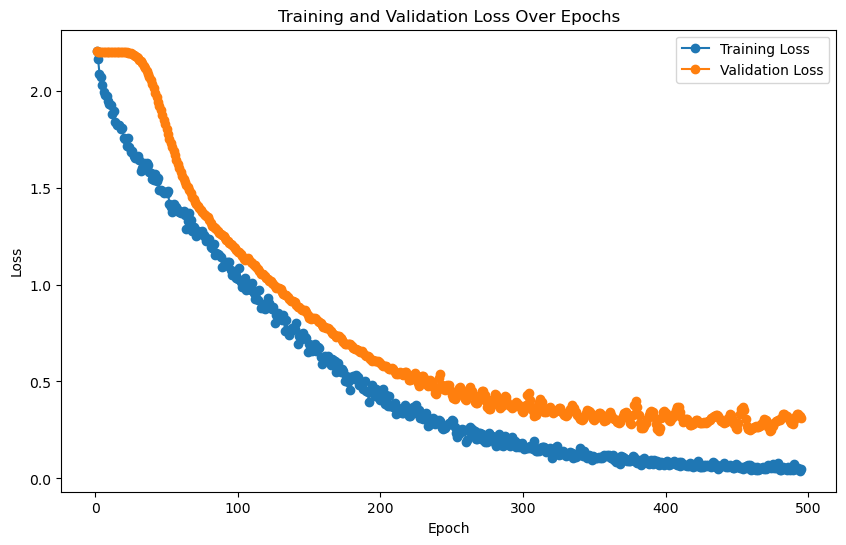

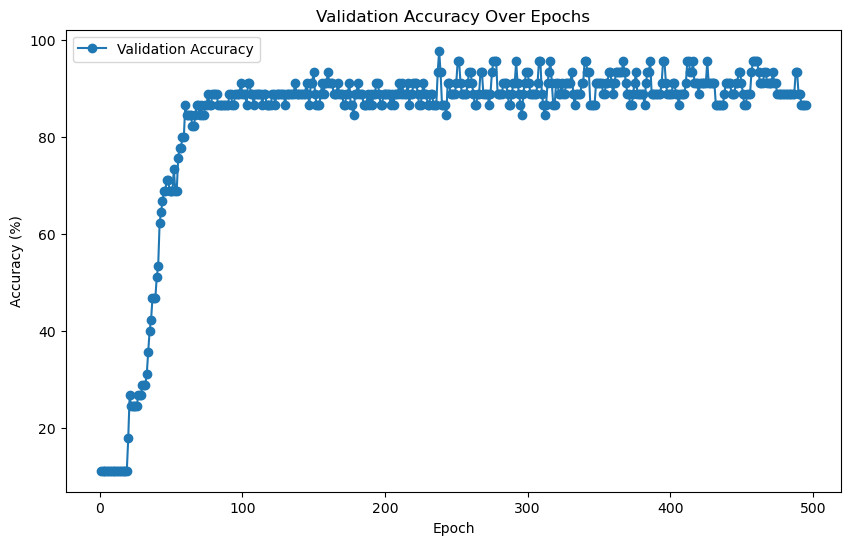


Evaluating on the test set...
    Test Batch [1/579], Loss: 0.2709



Final Test Loss: 0.1405, Test Accuracy: 97.14%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/579 for test dataset.
  Processed batch 20/579 for test dataset.
  Processed batch 30/579 for test dataset.


  Processed batch 40/579 for test dataset.
  Processed batch 50/579 for test dataset.
  Processed batch 60/579 for test dataset.
  Processed batch 70/579 for test dataset.
  Processed batch 80/579 for test dataset.


  Processed batch 90/579 for test dataset.
  Processed batch 100/579 for test dataset.
  Processed batch 110/579 for test dataset.
  Processed batch 120/579 for test dataset.
  Processed batch 130/579 for test dataset.


  Processed batch 140/579 for test dataset.
  Processed batch 150/579 for test dataset.
  Processed batch 160/579 for test dataset.
  Processed batch 170/579 for test dataset.
  Processed batch 180/579 for test dataset.


  Processed batch 190/579 for test dataset.
  Processed batch 200/579 for test dataset.
  Processed batch 210/579 for test dataset.
  Processed batch 220/579 for test dataset.
  Processed batch 230/579 for test dataset.


  Processed batch 240/579 for test dataset.
  Processed batch 250/579 for test dataset.
  Processed batch 260/579 for test dataset.
  Processed batch 270/579 for test dataset.
  Processed batch 280/579 for test dataset.


  Processed batch 290/579 for test dataset.
  Processed batch 300/579 for test dataset.
  Processed batch 310/579 for test dataset.
  Processed batch 320/579 for test dataset.
  Processed batch 330/579 for test dataset.


  Processed batch 340/579 for test dataset.
  Processed batch 350/579 for test dataset.
  Processed batch 360/579 for test dataset.
  Processed batch 370/579 for test dataset.
  Processed batch 380/579 for test dataset.


  Processed batch 390/579 for test dataset.
  Processed batch 400/579 for test dataset.
  Processed batch 410/579 for test dataset.
  Processed batch 420/579 for test dataset.
  Processed batch 430/579 for test dataset.


  Processed batch 440/579 for test dataset.
  Processed batch 450/579 for test dataset.
  Processed batch 460/579 for test dataset.
  Processed batch 470/579 for test dataset.
  Processed batch 480/579 for test dataset.


  Processed batch 490/579 for test dataset.
  Processed batch 500/579 for test dataset.
  Processed batch 510/579 for test dataset.
  Processed batch 520/579 for test dataset.
  Processed batch 530/579 for test dataset.


  Processed batch 540/579 for test dataset.
  Processed batch 550/579 for test dataset.
  Processed batch 560/579 for test dataset.
  Processed batch 570/579 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 148017 samples with 64 features each
LOG: Labels shape: (148017,)

LOG: Training features shape: (90, 64), Training labels shape: (90,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (148017, 64), Test labels shape: (148017,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 84.44%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       1.00      0.80      0.89         5
           3       0.57      0.80      0.67         5
           4       1.00      0.60      0.75         5
           5       1.00      0.60      0.75         5
           6       0.57      0.80      0.67         5
           7       1.00      1.00      1.00         5
           8       1.00      

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 148017 samples with 64 features each
LOG: Labels shape: (148017,)
Train reps shape: (90, 64)
Train labels shape: (90,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (148017, 64)
Test labels shape: (148017,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.4295  |  Val Loss: 2.2514
Validation loss improved from inf to 2.2514.


[Epoch 2/1000] Train Loss: 2.2247  |  Val Loss: 2.1312
Validation loss improved from 2.2514 to 2.1312.
[Epoch 3/1000] Train Loss: 2.0853  |  Val Loss: 2.0508
Validation loss improved from 2.1312 to 2.0508.
[Epoch 4/1000] Train Loss: 2.0037  |  Val Loss: 1.9896
Validation loss improved from 2.0508 to 1.9896.
[Epoch 5/1000] Train Loss: 1.9342  |  Val Loss: 1.9343
Validation loss improved from 1.9896 to 1.9343.
[Epoch 6/1000] Train Loss: 1.8653  |  Val Loss: 1.8834
Validation loss improved from 1.9343 to 1.8834.
[Epoch 7/1000] Train Loss: 1.8038  |  Val Loss: 1.8398
Validation loss improved from 1.8834 to 1.8398.
[Epoch 8/1000] Train Loss: 1.7490  |  Val Loss: 1.7944
Validation loss improved from 1.8398 to 1.7944.
[Epoch 9/1000] Train Loss: 1.6954  |  Val Loss: 1.7486
Validation loss improved from 1.7944 to 1.7486.
[Epoch 10/1000] Train Loss: 1.6433  |  Val Loss: 1.7029
Validation loss improved from 1.7486 to 1.7029.
[Epoch 11/1000] Train Loss: 1.5898  |  Val Loss: 1.6543
Validation loss 

[Epoch 47/1000] Train Loss: 0.2826  |  Val Loss: 0.5096
Validation loss improved from 0.5299 to 0.5096.
[Epoch 48/1000] Train Loss: 0.2674  |  Val Loss: 0.5015
Validation loss improved from 0.5096 to 0.5015.
[Epoch 49/1000] Train Loss: 0.2553  |  Val Loss: 0.5007
Validation loss improved from 0.5015 to 0.5007.
[Epoch 50/1000] Train Loss: 0.2403  |  Val Loss: 0.5011
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 51/1000] Train Loss: 0.2278  |  Val Loss: 0.4964
Validation loss improved from 0.5007 to 0.4964.
[Epoch 52/1000] Train Loss: 0.2152  |  Val Loss: 0.5068
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 53/1000] Train Loss: 0.2091  |  Val Loss: 0.4936
Validation loss improved from 0.4964 to 0.4936.
[Epoch 54/1000] Train Loss: 0.1998  |  Val Loss: 0.4627
Validation loss improved from 0.4936 to 0.4627.
[Epoch 55/1000] Train Loss: 0.1880  |  Val Loss: 0.4561
Validation loss improved from 0.4627 to 0.4561.
[Epoch 56/1000] Train Loss: 0.1798  |  Val Loss: 0.4

[Epoch 89/1000] Train Loss: 0.0518  |  Val Loss: 0.4593
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 90/1000] Train Loss: 0.0493  |  Val Loss: 0.4376
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 91/1000] Train Loss: 0.0497  |  Val Loss: 0.4324
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 92/1000] Train Loss: 0.0490  |  Val Loss: 0.4396
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 93/1000] Train Loss: 0.0456  |  Val Loss: 0.4544
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 94/1000] Train Loss: 0.0446  |  Val Loss: 0.4651
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 95/1000] Train Loss: 0.0429  |  Val Loss: 0.4440
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 96/1000] Train Loss: 0.0420  |  Val Loss: 0.4211
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 97/1000] Train Loss: 0.0421  |  Val Loss: 0.4333
!! Validation loss did NOT improve !! Patience: 33/100
[

[Epoch 133/1000] Train Loss: 0.0164  |  Val Loss: 0.4937
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 134/1000] Train Loss: 0.0160  |  Val Loss: 0.4821
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 135/1000] Train Loss: 0.0161  |  Val Loss: 0.4880
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 136/1000] Train Loss: 0.0156  |  Val Loss: 0.5093
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 137/1000] Train Loss: 0.0152  |  Val Loss: 0.5263
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 138/1000] Train Loss: 0.0151  |  Val Loss: 0.5251
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 139/1000] Train Loss: 0.0146  |  Val Loss: 0.5078
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 140/1000] Train Loss: 0.0139  |  Val Loss: 0.4795
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 141/1000] Train Loss: 0.0145  |  Val Loss: 0.4658
!! Validation loss did NOT improve !! Patience:

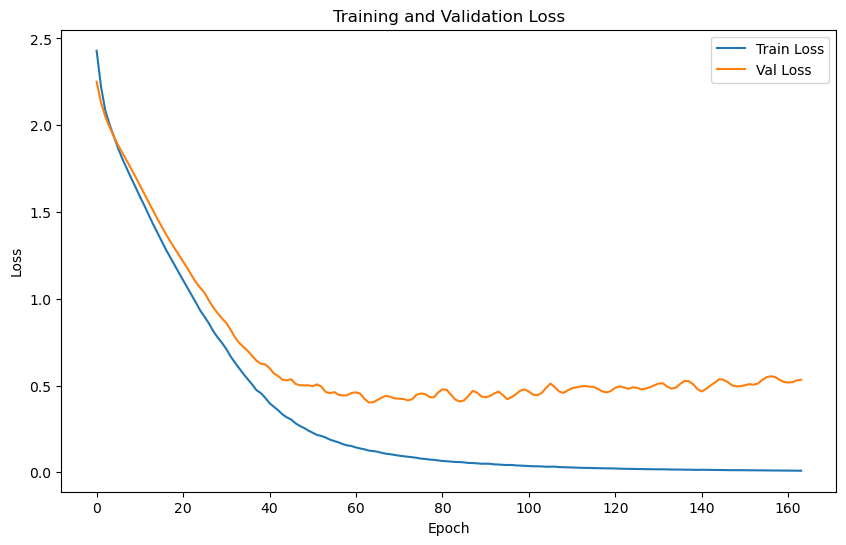

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.2835 | Test Accuracy: 90.60%


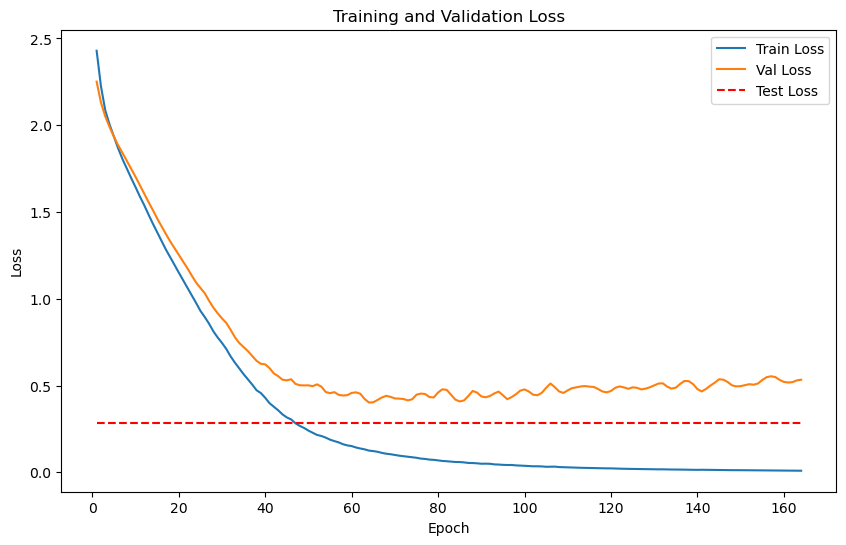

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 148017 samples with 64 features each
LOG: Labels shape: (148017,)


Train embeddings shape: (90, 64), 
Train labels shape: (90,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (148017, 64), 
Test labels shape: (148017,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10}
Training batch size: 90


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.1880
Epoch [1/2000], Avg Train Loss: 8.1880


Epoch [1/2000], Avg Val Loss: 3.3010
Validation loss improved from inf to 3.3010. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 7.9800
Epoch [2/2000], Avg Train Loss: 7.9800
Epoch [2/2000], Avg Val Loss: 3.2722
Validation loss improved from 3.3010 to 3.2722. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.1544
Epoch [3/2000], Avg Train Loss: 8.1544
Epoch [3/2000], Avg Val Loss: 3.2439
Validation loss improved from 3.2722 to 3.2439. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.1581
Epoch [4/2000], Avg Train Loss: 8.1581
Epoch [4/2000], Avg Val Loss: 3.2165
Validation loss improved from 3.2439 to 3.2165. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 7.5278
Epoch [5/2000], Avg Train Loss: 7.5278
Epoch [5/2000], Avg Val Loss: 3.1904
Validation loss improved from 3.2165 to 3.1904. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 8.0239
Ep

    Batch [1/1], Train Loss: 6.9898
Epoch [14/2000], Avg Train Loss: 6.9898
Epoch [14/2000], Avg Val Loss: 2.9977
Validation loss improved from 3.0161 to 2.9977. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 7.0960
Epoch [15/2000], Avg Train Loss: 7.0960
Epoch [15/2000], Avg Val Loss: 2.9800
Validation loss improved from 2.9977 to 2.9800. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 7.4140
Epoch [16/2000], Avg Train Loss: 7.4140
Epoch [16/2000], Avg Val Loss: 2.9629
Validation loss improved from 2.9800 to 2.9629. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 6.9891
Epoch [17/2000], Avg Train Loss: 6.9891
Epoch [17/2000], Avg Val Loss: 2.9464
Validation loss improved from 2.9629 to 2.9464. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 7.1898
Epoch [18/2000], Avg Train Loss: 7.1898
Epoch [18/2000], Avg Val Loss: 2.9306
Validation loss improved from 2.9464 to 2.

    Batch [1/1], Train Loss: 5.7254
Epoch [46/2000], Avg Train Loss: 5.7254
Epoch [46/2000], Avg Val Loss: 2.6761
Validation loss improved from 2.6808 to 2.6761. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 5.4279
Epoch [47/2000], Avg Train Loss: 5.4279
Epoch [47/2000], Avg Val Loss: 2.6715
Validation loss improved from 2.6761 to 2.6715. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 5.5297
Epoch [48/2000], Avg Train Loss: 5.5297
Epoch [48/2000], Avg Val Loss: 2.6672
Validation loss improved from 2.6715 to 2.6672. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 5.5295
Epoch [49/2000], Avg Train Loss: 5.5295
Epoch [49/2000], Avg Val Loss: 2.6631
Validation loss improved from 2.6672 to 2.6631. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 5.4148
Epoch [50/2000], Avg Train Loss: 5.4148
Epoch [50/2000], Avg Val Loss: 2.6592
Validation loss improved from 2.6631 to 2.

    Batch [1/1], Train Loss: 5.1458
Epoch [64/2000], Avg Train Loss: 5.1458
Epoch [64/2000], Avg Val Loss: 2.6176
Validation loss improved from 2.6200 to 2.6176. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 5.0138
Epoch [65/2000], Avg Train Loss: 5.0138
Epoch [65/2000], Avg Val Loss: 2.6154
Validation loss improved from 2.6176 to 2.6154. Saving model...

LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 5.0184
Epoch [66/2000], Avg Train Loss: 5.0184
Epoch [66/2000], Avg Val Loss: 2.6132
Validation loss improved from 2.6154 to 2.6132. Saving model...

LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 4.8908
Epoch [67/2000], Avg Train Loss: 4.8908
Epoch [67/2000], Avg Val Loss: 2.6112
Validation loss improved from 2.6132 to 2.6112. Saving model...

LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 4.9955
Epoch [68/2000], Avg Train Loss: 4.9955
Epoch [68/2000], Avg Val Loss: 2.6093
Validation loss improved from 2.6112 to 2.

    Batch [1/1], Train Loss: 4.4432
Epoch [93/2000], Avg Train Loss: 4.4432
Epoch [93/2000], Avg Val Loss: 2.5796
Validation loss improved from 2.5804 to 2.5796. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 4.3059
Epoch [94/2000], Avg Train Loss: 4.3059
Epoch [94/2000], Avg Val Loss: 2.5788
Validation loss improved from 2.5796 to 2.5788. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 4.3598
Epoch [95/2000], Avg Train Loss: 4.3598
Epoch [95/2000], Avg Val Loss: 2.5780
Validation loss improved from 2.5788 to 2.5780. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 4.3587
Epoch [96/2000], Avg Train Loss: 4.3587
Epoch [96/2000], Avg Val Loss: 2.5772
Validation loss improved from 2.5780 to 2.5772. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 4.3741
Epoch [97/2000], Avg Train Loss: 4.3741
Epoch [97/2000], Avg Val Loss: 2.5764
Validation loss improved from 2.5772 to 2.

    Batch [1/1], Train Loss: 4.2232
Epoch [114/2000], Avg Train Loss: 4.2232
Epoch [114/2000], Avg Val Loss: 2.5639
Validation loss improved from 2.5645 to 2.5639. Saving model...

LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 4.0992
Epoch [115/2000], Avg Train Loss: 4.0992
Epoch [115/2000], Avg Val Loss: 2.5632
Validation loss improved from 2.5639 to 2.5632. Saving model...

LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 4.1271
Epoch [116/2000], Avg Train Loss: 4.1271
Epoch [116/2000], Avg Val Loss: 2.5625
Validation loss improved from 2.5632 to 2.5625. Saving model...

LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 4.2846
Epoch [117/2000], Avg Train Loss: 4.2846
Epoch [117/2000], Avg Val Loss: 2.5617
Validation loss improved from 2.5625 to 2.5617. Saving model...

LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 4.1309
Epoch [118/2000], Avg Train Loss: 4.1309
Epoch [118/2000], Avg Val Loss: 2.5611
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9271
Epoch [145/2000], Avg Train Loss: 3.9271
Epoch [145/2000], Avg Val Loss: 2.5440
Validation loss improved from 2.5446 to 2.5440. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 3.8860
Epoch [146/2000], Avg Train Loss: 3.8860
Epoch [146/2000], Avg Val Loss: 2.5433
Validation loss improved from 2.5440 to 2.5433. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 3.9636
Epoch [147/2000], Avg Train Loss: 3.9636
Epoch [147/2000], Avg Val Loss: 2.5426
Validation loss improved from 2.5433 to 2.5426. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 3.9147
Epoch [148/2000], Avg Train Loss: 3.9147
Epoch [148/2000], Avg Val Loss: 2.5420
Validation loss improved from 2.5426 to 2.5420. Saving model...

LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 3.8543
Epoch [149/2000], Avg Train Loss: 3.8543
Epoch [149/2000], Avg Val Loss: 2.5413
Validation loss improved fro

Epoch [159/2000], Avg Val Loss: 2.5342
Validation loss improved from 2.5349 to 2.5342. Saving model...

LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 3.7653
Epoch [160/2000], Avg Train Loss: 3.7653
Epoch [160/2000], Avg Val Loss: 2.5335
Validation loss improved from 2.5342 to 2.5335. Saving model...

LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 3.7573
Epoch [161/2000], Avg Train Loss: 3.7573
Epoch [161/2000], Avg Val Loss: 2.5328
Validation loss improved from 2.5335 to 2.5328. Saving model...

LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 3.7869
Epoch [162/2000], Avg Train Loss: 3.7869
Epoch [162/2000], Avg Val Loss: 2.5321
Validation loss improved from 2.5328 to 2.5321. Saving model...

LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 3.8623
Epoch [163/2000], Avg Train Loss: 3.8623
Epoch [163/2000], Avg Val Loss: 2.5313
Validation loss improved from 2.5321 to 2.5313. Saving model...

LOG: Epoch [164/2000] - Training
    Bat

Epoch [191/2000], Avg Val Loss: 2.5105
Validation loss improved from 2.5112 to 2.5105. Saving model...

LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 3.7499
Epoch [192/2000], Avg Train Loss: 3.7499
Epoch [192/2000], Avg Val Loss: 2.5097
Validation loss improved from 2.5105 to 2.5097. Saving model...

LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 3.6519
Epoch [193/2000], Avg Train Loss: 3.6519
Epoch [193/2000], Avg Val Loss: 2.5089
Validation loss improved from 2.5097 to 2.5089. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 3.5870
Epoch [194/2000], Avg Train Loss: 3.5870
Epoch [194/2000], Avg Val Loss: 2.5082
Validation loss improved from 2.5089 to 2.5082. Saving model...

LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 3.5821
Epoch [195/2000], Avg Train Loss: 3.5821
Epoch [195/2000], Avg Val Loss: 2.5074
Validation loss improved from 2.5082 to 2.5074. Saving model...

LOG: Epoch [196/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.6526
Epoch [208/2000], Avg Train Loss: 3.6526
Epoch [208/2000], Avg Val Loss: 2.4977
Validation loss improved from 2.4984 to 2.4977. Saving model...

LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 3.6372
Epoch [209/2000], Avg Train Loss: 3.6372
Epoch [209/2000], Avg Val Loss: 2.4969
Validation loss improved from 2.4977 to 2.4969. Saving model...

LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 3.6381
Epoch [210/2000], Avg Train Loss: 3.6381
Epoch [210/2000], Avg Val Loss: 2.4962
Validation loss improved from 2.4969 to 2.4962. Saving model...

LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 3.5993
Epoch [211/2000], Avg Train Loss: 3.5993
Epoch [211/2000], Avg Val Loss: 2.4954
Validation loss improved from 2.4962 to 2.4954. Saving model...

LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 3.6560
Epoch [212/2000], Avg Train Loss: 3.6560
Epoch [212/2000], Avg Val Loss: 2.4947
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5552
Epoch [239/2000], Avg Train Loss: 3.5552
Epoch [239/2000], Avg Val Loss: 2.4752
Validation loss improved from 2.4759 to 2.4752. Saving model...

LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 3.5446
Epoch [240/2000], Avg Train Loss: 3.5446
Epoch [240/2000], Avg Val Loss: 2.4744
Validation loss improved from 2.4752 to 2.4744. Saving model...

LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 3.6160
Epoch [241/2000], Avg Train Loss: 3.6160
Epoch [241/2000], Avg Val Loss: 2.4737
Validation loss improved from 2.4744 to 2.4737. Saving model...

LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 3.5164
Epoch [242/2000], Avg Train Loss: 3.5164
Epoch [242/2000], Avg Val Loss: 2.4729
Validation loss improved from 2.4737 to 2.4729. Saving model...

LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 3.4792
Epoch [243/2000], Avg Train Loss: 3.4792
Epoch [243/2000], Avg Val Loss: 2.4722
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5952
Epoch [253/2000], Avg Train Loss: 3.5952
Epoch [253/2000], Avg Val Loss: 2.4650
Validation loss improved from 2.4657 to 2.4650. Saving model...

LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 3.4537
Epoch [254/2000], Avg Train Loss: 3.4537
Epoch [254/2000], Avg Val Loss: 2.4643
Validation loss improved from 2.4650 to 2.4643. Saving model...

LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 3.4941
Epoch [255/2000], Avg Train Loss: 3.4941
Epoch [255/2000], Avg Val Loss: 2.4635
Validation loss improved from 2.4643 to 2.4635. Saving model...

LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 3.5250
Epoch [256/2000], Avg Train Loss: 3.5250
Epoch [256/2000], Avg Val Loss: 2.4628
Validation loss improved from 2.4635 to 2.4628. Saving model...

LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 3.4918
Epoch [257/2000], Avg Train Loss: 3.4918
Epoch [257/2000], Avg Val Loss: 2.4620
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4125
Epoch [287/2000], Avg Train Loss: 3.4125
Epoch [287/2000], Avg Val Loss: 2.4398
Validation loss improved from 2.4405 to 2.4398. Saving model...

LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 3.4908
Epoch [288/2000], Avg Train Loss: 3.4908
Epoch [288/2000], Avg Val Loss: 2.4391
Validation loss improved from 2.4398 to 2.4391. Saving model...

LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 3.4880
Epoch [289/2000], Avg Train Loss: 3.4880
Epoch [289/2000], Avg Val Loss: 2.4384
Validation loss improved from 2.4391 to 2.4384. Saving model...

LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 3.4040
Epoch [290/2000], Avg Train Loss: 3.4040
Epoch [290/2000], Avg Val Loss: 2.4377
Validation loss improved from 2.4384 to 2.4377. Saving model...

LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 3.4695
Epoch [291/2000], Avg Train Loss: 3.4695
Epoch [291/2000], Avg Val Loss: 2.4370
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4151
Epoch [301/2000], Avg Train Loss: 3.4151
Epoch [301/2000], Avg Val Loss: 2.4297
Validation loss improved from 2.4305 to 2.4297. Saving model...

LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 3.4093
Epoch [302/2000], Avg Train Loss: 3.4093
Epoch [302/2000], Avg Val Loss: 2.4290
Validation loss improved from 2.4297 to 2.4290. Saving model...

LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 3.4350
Epoch [303/2000], Avg Train Loss: 3.4350
Epoch [303/2000], Avg Val Loss: 2.4283
Validation loss improved from 2.4290 to 2.4283. Saving model...

LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 3.4870
Epoch [304/2000], Avg Train Loss: 3.4870
Epoch [304/2000], Avg Val Loss: 2.4276
Validation loss improved from 2.4283 to 2.4276. Saving model...

LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 3.3448
Epoch [305/2000], Avg Train Loss: 3.3448
Epoch [305/2000], Avg Val Loss: 2.4268
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3310
Epoch [335/2000], Avg Train Loss: 3.3310
Epoch [335/2000], Avg Val Loss: 2.4074
Validation loss improved from 2.4080 to 2.4074. Saving model...

LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 3.3645
Epoch [336/2000], Avg Train Loss: 3.3645
Epoch [336/2000], Avg Val Loss: 2.4068
Validation loss improved from 2.4074 to 2.4068. Saving model...

LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 3.3532
Epoch [337/2000], Avg Train Loss: 3.3532
Epoch [337/2000], Avg Val Loss: 2.4062
Validation loss improved from 2.4068 to 2.4062. Saving model...

LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 3.3945
Epoch [338/2000], Avg Train Loss: 3.3945
Epoch [338/2000], Avg Val Loss: 2.4056
Validation loss improved from 2.4062 to 2.4056. Saving model...

LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 3.2616
Epoch [339/2000], Avg Train Loss: 3.2616
Epoch [339/2000], Avg Val Loss: 2.4050
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3668
Epoch [346/2000], Avg Train Loss: 3.3668
Epoch [346/2000], Avg Val Loss: 2.4008
Validation loss improved from 2.4014 to 2.4008. Saving model...

LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 3.3591
Epoch [347/2000], Avg Train Loss: 3.3591
Epoch [347/2000], Avg Val Loss: 2.4003
Validation loss improved from 2.4008 to 2.4003. Saving model...

LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 3.3370
Epoch [348/2000], Avg Train Loss: 3.3370
Epoch [348/2000], Avg Val Loss: 2.3997
Validation loss improved from 2.4003 to 2.3997. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 3.3083
Epoch [349/2000], Avg Train Loss: 3.3083
Epoch [349/2000], Avg Val Loss: 2.3991
Validation loss improved from 2.3997 to 2.3991. Saving model...

LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 3.3778
Epoch [350/2000], Avg Train Loss: 3.3778
Epoch [350/2000], Avg Val Loss: 2.3985
Validation loss improved fro

Epoch [383/2000], Avg Val Loss: 2.3811
Validation loss improved from 2.3817 to 2.3811. Saving model...

LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 3.2168
Epoch [384/2000], Avg Train Loss: 3.2168
Epoch [384/2000], Avg Val Loss: 2.3806
Validation loss improved from 2.3811 to 2.3806. Saving model...

LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 3.2966
Epoch [385/2000], Avg Train Loss: 3.2966
Epoch [385/2000], Avg Val Loss: 2.3801
Validation loss improved from 2.3806 to 2.3801. Saving model...

LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 3.2888
Epoch [386/2000], Avg Train Loss: 3.2888
Epoch [386/2000], Avg Val Loss: 2.3795
Validation loss improved from 2.3801 to 2.3795. Saving model...

LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 3.3072
Epoch [387/2000], Avg Train Loss: 3.3072
Epoch [387/2000], Avg Val Loss: 2.3790
Validation loss improved from 2.3795 to 2.3790. Saving model...

LOG: Epoch [388/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.2543
Epoch [398/2000], Avg Train Loss: 3.2543
Epoch [398/2000], Avg Val Loss: 2.3734
Validation loss improved from 2.3739 to 2.3734. Saving model...

LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 3.3039
Epoch [399/2000], Avg Train Loss: 3.3039
Epoch [399/2000], Avg Val Loss: 2.3729
Validation loss improved from 2.3734 to 2.3729. Saving model...

LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 3.2434
Epoch [400/2000], Avg Train Loss: 3.2434
Epoch [400/2000], Avg Val Loss: 2.3724
Validation loss improved from 2.3729 to 2.3724. Saving model...

LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 3.2241
Epoch [401/2000], Avg Train Loss: 3.2241
Epoch [401/2000], Avg Val Loss: 2.3719
Validation loss improved from 2.3724 to 2.3719. Saving model...

LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 3.2900
Epoch [402/2000], Avg Train Loss: 3.2900
Epoch [402/2000], Avg Val Loss: 2.3714
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2438
Epoch [433/2000], Avg Train Loss: 3.2438
Epoch [433/2000], Avg Val Loss: 2.3577
Validation loss improved from 2.3581 to 2.3577. Saving model...

LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 3.2393
Epoch [434/2000], Avg Train Loss: 3.2393
Epoch [434/2000], Avg Val Loss: 2.3573
Validation loss improved from 2.3577 to 2.3573. Saving model...

LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 3.2064
Epoch [435/2000], Avg Train Loss: 3.2064
Epoch [435/2000], Avg Val Loss: 2.3569
Validation loss improved from 2.3573 to 2.3569. Saving model...

LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 3.2253
Epoch [436/2000], Avg Train Loss: 3.2253
Epoch [436/2000], Avg Val Loss: 2.3565
Validation loss improved from 2.3569 to 2.3565. Saving model...

LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 3.2494
Epoch [437/2000], Avg Train Loss: 3.2494
Epoch [437/2000], Avg Val Loss: 2.3561
Validation loss improved fro

Epoch [442/2000], Avg Val Loss: 2.3541
Validation loss improved from 2.3545 to 2.3541. Saving model...

LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 3.2083
Epoch [443/2000], Avg Train Loss: 3.2083
Epoch [443/2000], Avg Val Loss: 2.3537
Validation loss improved from 2.3541 to 2.3537. Saving model...

LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 3.1611
Epoch [444/2000], Avg Train Loss: 3.1611
Epoch [444/2000], Avg Val Loss: 2.3533
Validation loss improved from 2.3537 to 2.3533. Saving model...

LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 3.2559
Epoch [445/2000], Avg Train Loss: 3.2559
Epoch [445/2000], Avg Val Loss: 2.3529
Validation loss improved from 2.3533 to 2.3529. Saving model...

LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 3.2315
Epoch [446/2000], Avg Train Loss: 3.2315
Epoch [446/2000], Avg Val Loss: 2.3526
Validation loss improved from 2.3529 to 2.3526. Saving model...

LOG: Epoch [447/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.1481
Epoch [474/2000], Avg Train Loss: 3.1481
Epoch [474/2000], Avg Val Loss: 2.3423
Validation loss improved from 2.3427 to 2.3423. Saving model...

LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 3.1833
Epoch [475/2000], Avg Train Loss: 3.1833
Epoch [475/2000], Avg Val Loss: 2.3419
Validation loss improved from 2.3423 to 2.3419. Saving model...

LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 3.2255
Epoch [476/2000], Avg Train Loss: 3.2255
Epoch [476/2000], Avg Val Loss: 2.3415
Validation loss improved from 2.3419 to 2.3415. Saving model...

LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 3.1614
Epoch [477/2000], Avg Train Loss: 3.1614
Epoch [477/2000], Avg Val Loss: 2.3411
Validation loss improved from 2.3415 to 2.3411. Saving model...

LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 3.2250
Epoch [478/2000], Avg Train Loss: 3.2250
Epoch [478/2000], Avg Val Loss: 2.3406
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1409
Epoch [488/2000], Avg Train Loss: 3.1409
Epoch [488/2000], Avg Val Loss: 2.3364
Validation loss improved from 2.3368 to 2.3364. Saving model...

LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 3.1238
Epoch [489/2000], Avg Train Loss: 3.1238
Epoch [489/2000], Avg Val Loss: 2.3360
Validation loss improved from 2.3364 to 2.3360. Saving model...

LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 3.1781
Epoch [490/2000], Avg Train Loss: 3.1781
Epoch [490/2000], Avg Val Loss: 2.3356
Validation loss improved from 2.3360 to 2.3356. Saving model...

LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 3.1657
Epoch [491/2000], Avg Train Loss: 3.1657
Epoch [491/2000], Avg Val Loss: 2.3351
Validation loss improved from 2.3356 to 2.3351. Saving model...

LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 3.1379
Epoch [492/2000], Avg Train Loss: 3.1379
Epoch [492/2000], Avg Val Loss: 2.3347
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1751
Epoch [523/2000], Avg Train Loss: 3.1751
Epoch [523/2000], Avg Val Loss: 2.3224
Validation loss improved from 2.3228 to 2.3224. Saving model...

LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 3.2020
Epoch [524/2000], Avg Train Loss: 3.2020
Epoch [524/2000], Avg Val Loss: 2.3220
Validation loss improved from 2.3224 to 2.3220. Saving model...

LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 3.1487
Epoch [525/2000], Avg Train Loss: 3.1487
Epoch [525/2000], Avg Val Loss: 2.3217
Validation loss improved from 2.3220 to 2.3217. Saving model...

LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 3.1545
Epoch [526/2000], Avg Train Loss: 3.1545
Epoch [526/2000], Avg Val Loss: 2.3213
Validation loss improved from 2.3217 to 2.3213. Saving model...

LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 3.1437
Epoch [527/2000], Avg Train Loss: 3.1437
Epoch [527/2000], Avg Val Loss: 2.3209
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1790
Epoch [536/2000], Avg Train Loss: 3.1790
Epoch [536/2000], Avg Val Loss: 2.3178
Validation loss improved from 2.3181 to 2.3178. Saving model...

LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 3.1582
Epoch [537/2000], Avg Train Loss: 3.1582
Epoch [537/2000], Avg Val Loss: 2.3175
Validation loss improved from 2.3178 to 2.3175. Saving model...

LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 3.0850
Epoch [538/2000], Avg Train Loss: 3.0850
Epoch [538/2000], Avg Val Loss: 2.3172
Validation loss improved from 2.3175 to 2.3172. Saving model...

LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 3.0788
Epoch [539/2000], Avg Train Loss: 3.0788
Epoch [539/2000], Avg Val Loss: 2.3169
Validation loss improved from 2.3172 to 2.3169. Saving model...

LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 3.1713
Epoch [540/2000], Avg Train Loss: 3.1713
Epoch [540/2000], Avg Val Loss: 2.3166
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1388
Epoch [569/2000], Avg Train Loss: 3.1388
Epoch [569/2000], Avg Val Loss: 2.3073
Validation loss improved from 2.3076 to 2.3073. Saving model...

LOG: Epoch [570/2000] - Training
    Batch [1/1], Train Loss: 3.1013
Epoch [570/2000], Avg Train Loss: 3.1013
Epoch [570/2000], Avg Val Loss: 2.3070
Validation loss improved from 2.3073 to 2.3070. Saving model...

LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 3.0677
Epoch [571/2000], Avg Train Loss: 3.0677
Epoch [571/2000], Avg Val Loss: 2.3067
Validation loss improved from 2.3070 to 2.3067. Saving model...

LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 3.1132
Epoch [572/2000], Avg Train Loss: 3.1132
Epoch [572/2000], Avg Val Loss: 2.3064
Validation loss improved from 2.3067 to 2.3064. Saving model...

LOG: Epoch [573/2000] - Training
    Batch [1/1], Train Loss: 3.1603
Epoch [573/2000], Avg Train Loss: 3.1603
Epoch [573/2000], Avg Val Loss: 2.3061
Validation loss improved fro

    Batch [1/1], Train Loss: 3.0607
Epoch [583/2000], Avg Train Loss: 3.0607
Epoch [583/2000], Avg Val Loss: 2.3034
Validation loss improved from 2.3037 to 2.3034. Saving model...

LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 3.1136
Epoch [584/2000], Avg Train Loss: 3.1136
Epoch [584/2000], Avg Val Loss: 2.3032
Validation loss improved from 2.3034 to 2.3032. Saving model...

LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 3.0788
Epoch [585/2000], Avg Train Loss: 3.0788
Epoch [585/2000], Avg Val Loss: 2.3029
Validation loss improved from 2.3032 to 2.3029. Saving model...

LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 3.0532
Epoch [586/2000], Avg Train Loss: 3.0532
Epoch [586/2000], Avg Val Loss: 2.3027
Validation loss improved from 2.3029 to 2.3027. Saving model...

LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 3.0809
Epoch [587/2000], Avg Train Loss: 3.0809
Epoch [587/2000], Avg Val Loss: 2.3024
Validation loss improved fro

Epoch [610/2000], Avg Val Loss: 2.2957
Validation loss improved from 2.2960 to 2.2957. Saving model...

LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 3.0497
Epoch [611/2000], Avg Train Loss: 3.0497
Epoch [611/2000], Avg Val Loss: 2.2955
Validation loss improved from 2.2957 to 2.2955. Saving model...

LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 3.0940
Epoch [612/2000], Avg Train Loss: 3.0940
Epoch [612/2000], Avg Val Loss: 2.2952
Validation loss improved from 2.2955 to 2.2952. Saving model...

LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 3.0798
Epoch [613/2000], Avg Train Loss: 3.0798
Epoch [613/2000], Avg Val Loss: 2.2950
Validation loss improved from 2.2952 to 2.2950. Saving model...

LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 3.0644
Epoch [614/2000], Avg Train Loss: 3.0644
Epoch [614/2000], Avg Val Loss: 2.2946
Validation loss improved from 2.2950 to 2.2946. Saving model...

LOG: Epoch [615/2000] - Training
    Bat

Epoch [627/2000], Avg Val Loss: 2.2898
Validation loss improved from 2.2902 to 2.2898. Saving model...

LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 3.0071
Epoch [628/2000], Avg Train Loss: 3.0071
Epoch [628/2000], Avg Val Loss: 2.2894
Validation loss improved from 2.2898 to 2.2894. Saving model...

LOG: Epoch [629/2000] - Training
    Batch [1/1], Train Loss: 3.0052
Epoch [629/2000], Avg Train Loss: 3.0052
Epoch [629/2000], Avg Val Loss: 2.2890
Validation loss improved from 2.2894 to 2.2890. Saving model...

LOG: Epoch [630/2000] - Training
    Batch [1/1], Train Loss: 3.0724
Epoch [630/2000], Avg Train Loss: 3.0724
Epoch [630/2000], Avg Val Loss: 2.2886
Validation loss improved from 2.2890 to 2.2886. Saving model...

LOG: Epoch [631/2000] - Training
    Batch [1/1], Train Loss: 2.9910
Epoch [631/2000], Avg Train Loss: 2.9910
Epoch [631/2000], Avg Val Loss: 2.2883
Validation loss improved from 2.2886 to 2.2883. Saving model...

LOG: Epoch [632/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.0446
Epoch [655/2000], Avg Train Loss: 3.0446
Epoch [655/2000], Avg Val Loss: 2.2802
Validation loss improved from 2.2805 to 2.2802. Saving model...

LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 3.0124
Epoch [656/2000], Avg Train Loss: 3.0124
Epoch [656/2000], Avg Val Loss: 2.2799
Validation loss improved from 2.2802 to 2.2799. Saving model...

LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 3.0255
Epoch [657/2000], Avg Train Loss: 3.0255
Epoch [657/2000], Avg Val Loss: 2.2796
Validation loss improved from 2.2799 to 2.2796. Saving model...

LOG: Epoch [658/2000] - Training
    Batch [1/1], Train Loss: 3.0775
Epoch [658/2000], Avg Train Loss: 3.0775
Epoch [658/2000], Avg Val Loss: 2.2793
Validation loss improved from 2.2796 to 2.2793. Saving model...

LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 3.0375
Epoch [659/2000], Avg Train Loss: 3.0375
Epoch [659/2000], Avg Val Loss: 2.2791
Validation loss improved fro

    Batch [1/1], Train Loss: 3.0733
Epoch [672/2000], Avg Train Loss: 3.0733
Epoch [672/2000], Avg Val Loss: 2.2759
Validation loss improved from 2.2762 to 2.2759. Saving model...

LOG: Epoch [673/2000] - Training
    Batch [1/1], Train Loss: 3.0422
Epoch [673/2000], Avg Train Loss: 3.0422
Epoch [673/2000], Avg Val Loss: 2.2756
Validation loss improved from 2.2759 to 2.2756. Saving model...

LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 3.0024
Epoch [674/2000], Avg Train Loss: 3.0024
Epoch [674/2000], Avg Val Loss: 2.2753
Validation loss improved from 2.2756 to 2.2753. Saving model...

LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 3.0065
Epoch [675/2000], Avg Train Loss: 3.0065
Epoch [675/2000], Avg Val Loss: 2.2750
Validation loss improved from 2.2753 to 2.2750. Saving model...

LOG: Epoch [676/2000] - Training
    Batch [1/1], Train Loss: 3.0704
Epoch [676/2000], Avg Train Loss: 3.0704
Epoch [676/2000], Avg Val Loss: 2.2748
Validation loss improved fro

Epoch [697/2000], Avg Val Loss: 2.2700
Validation loss improved from 2.2703 to 2.2700. Saving model...

LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 3.0009
Epoch [698/2000], Avg Train Loss: 3.0009
Epoch [698/2000], Avg Val Loss: 2.2697
Validation loss improved from 2.2700 to 2.2697. Saving model...

LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 2.9875
Epoch [699/2000], Avg Train Loss: 2.9875
Epoch [699/2000], Avg Val Loss: 2.2694
Validation loss improved from 2.2697 to 2.2694. Saving model...

LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 2.9867
Epoch [700/2000], Avg Train Loss: 2.9867
Epoch [700/2000], Avg Val Loss: 2.2692
Validation loss improved from 2.2694 to 2.2692. Saving model...

LOG: Epoch [701/2000] - Training
    Batch [1/1], Train Loss: 2.9756
Epoch [701/2000], Avg Train Loss: 2.9756
Epoch [701/2000], Avg Val Loss: 2.2689
Validation loss improved from 2.2692 to 2.2689. Saving model...

LOG: Epoch [702/2000] - Training
    Bat

Epoch [718/2000], Avg Val Loss: 2.2645
Validation loss improved from 2.2647 to 2.2645. Saving model...

LOG: Epoch [719/2000] - Training
    Batch [1/1], Train Loss: 2.9565
Epoch [719/2000], Avg Train Loss: 2.9565
Epoch [719/2000], Avg Val Loss: 2.2642
Validation loss improved from 2.2645 to 2.2642. Saving model...

LOG: Epoch [720/2000] - Training
    Batch [1/1], Train Loss: 2.9988
Epoch [720/2000], Avg Train Loss: 2.9988
Epoch [720/2000], Avg Val Loss: 2.2640
Validation loss improved from 2.2642 to 2.2640. Saving model...

LOG: Epoch [721/2000] - Training
    Batch [1/1], Train Loss: 2.9876
Epoch [721/2000], Avg Train Loss: 2.9876
Epoch [721/2000], Avg Val Loss: 2.2638
Validation loss improved from 2.2640 to 2.2638. Saving model...

LOG: Epoch [722/2000] - Training
    Batch [1/1], Train Loss: 2.9751
Epoch [722/2000], Avg Train Loss: 2.9751
Epoch [722/2000], Avg Val Loss: 2.2637
Validation loss improved from 2.2638 to 2.2637. Saving model...

LOG: Epoch [723/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.9703
Epoch [740/2000], Avg Train Loss: 2.9703
Epoch [740/2000], Avg Val Loss: 2.2593
Validation loss improved from 2.2596 to 2.2593. Saving model...

LOG: Epoch [741/2000] - Training
    Batch [1/1], Train Loss: 2.9551
Epoch [741/2000], Avg Train Loss: 2.9551
Epoch [741/2000], Avg Val Loss: 2.2590
Validation loss improved from 2.2593 to 2.2590. Saving model...

LOG: Epoch [742/2000] - Training
    Batch [1/1], Train Loss: 3.0030
Epoch [742/2000], Avg Train Loss: 3.0030
Epoch [742/2000], Avg Val Loss: 2.2587
Validation loss improved from 2.2590 to 2.2587. Saving model...

LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 2.9873
Epoch [743/2000], Avg Train Loss: 2.9873
Epoch [743/2000], Avg Val Loss: 2.2584
Validation loss improved from 2.2587 to 2.2584. Saving model...

LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 2.9213
Epoch [744/2000], Avg Train Loss: 2.9213
Epoch [744/2000], Avg Val Loss: 2.2582
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9183
Epoch [765/2000], Avg Train Loss: 2.9183
Epoch [765/2000], Avg Val Loss: 2.2529
Validation loss improved from 2.2531 to 2.2529. Saving model...

LOG: Epoch [766/2000] - Training
    Batch [1/1], Train Loss: 2.9439
Epoch [766/2000], Avg Train Loss: 2.9439
Epoch [766/2000], Avg Val Loss: 2.2526
Validation loss improved from 2.2529 to 2.2526. Saving model...

LOG: Epoch [767/2000] - Training
    Batch [1/1], Train Loss: 2.9415
Epoch [767/2000], Avg Train Loss: 2.9415
Epoch [767/2000], Avg Val Loss: 2.2524
Validation loss improved from 2.2526 to 2.2524. Saving model...

LOG: Epoch [768/2000] - Training
    Batch [1/1], Train Loss: 2.9240
Epoch [768/2000], Avg Train Loss: 2.9240
Epoch [768/2000], Avg Val Loss: 2.2522
Validation loss improved from 2.2524 to 2.2522. Saving model...

LOG: Epoch [769/2000] - Training
    Batch [1/1], Train Loss: 3.0039
Epoch [769/2000], Avg Train Loss: 3.0039
Epoch [769/2000], Avg Val Loss: 2.2520
Validation loss improved fro

    Batch [1/1], Train Loss: 2.8982
Epoch [785/2000], Avg Train Loss: 2.8982
Epoch [785/2000], Avg Val Loss: 2.2482
Validation loss improved from 2.2484 to 2.2482. Saving model...

LOG: Epoch [786/2000] - Training
    Batch [1/1], Train Loss: 2.9538
Epoch [786/2000], Avg Train Loss: 2.9538
Epoch [786/2000], Avg Val Loss: 2.2480
Validation loss improved from 2.2482 to 2.2480. Saving model...

LOG: Epoch [787/2000] - Training
    Batch [1/1], Train Loss: 2.9185
Epoch [787/2000], Avg Train Loss: 2.9185
Epoch [787/2000], Avg Val Loss: 2.2478
Validation loss improved from 2.2480 to 2.2478. Saving model...

LOG: Epoch [788/2000] - Training
    Batch [1/1], Train Loss: 2.9434
Epoch [788/2000], Avg Train Loss: 2.9434
Epoch [788/2000], Avg Val Loss: 2.2476
Validation loss improved from 2.2478 to 2.2476. Saving model...

LOG: Epoch [789/2000] - Training
    Batch [1/1], Train Loss: 2.9149
Epoch [789/2000], Avg Train Loss: 2.9149
Epoch [789/2000], Avg Val Loss: 2.2474
Validation loss improved fro

Epoch [809/2000], Avg Val Loss: 2.2433
Validation loss improved from 2.2435 to 2.2433. Saving model...

LOG: Epoch [810/2000] - Training
    Batch [1/1], Train Loss: 2.8994
Epoch [810/2000], Avg Train Loss: 2.8994
Epoch [810/2000], Avg Val Loss: 2.2430
Validation loss improved from 2.2433 to 2.2430. Saving model...

LOG: Epoch [811/2000] - Training
    Batch [1/1], Train Loss: 2.8894
Epoch [811/2000], Avg Train Loss: 2.8894
Epoch [811/2000], Avg Val Loss: 2.2428
Validation loss improved from 2.2430 to 2.2428. Saving model...

LOG: Epoch [812/2000] - Training
    Batch [1/1], Train Loss: 2.9693
Epoch [812/2000], Avg Train Loss: 2.9693
Epoch [812/2000], Avg Val Loss: 2.2426
Validation loss improved from 2.2428 to 2.2426. Saving model...

LOG: Epoch [813/2000] - Training
    Batch [1/1], Train Loss: 2.9183
Epoch [813/2000], Avg Train Loss: 2.9183
Epoch [813/2000], Avg Val Loss: 2.2424
Validation loss improved from 2.2426 to 2.2424. Saving model...

LOG: Epoch [814/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.9490
Epoch [833/2000], Avg Train Loss: 2.9490
Epoch [833/2000], Avg Val Loss: 2.2379
Validation loss improved from 2.2381 to 2.2379. Saving model...

LOG: Epoch [834/2000] - Training
    Batch [1/1], Train Loss: 2.8665
Epoch [834/2000], Avg Train Loss: 2.8665
Epoch [834/2000], Avg Val Loss: 2.2378
Validation loss improved from 2.2379 to 2.2378. Saving model...

LOG: Epoch [835/2000] - Training
    Batch [1/1], Train Loss: 2.9006
Epoch [835/2000], Avg Train Loss: 2.9006
Epoch [835/2000], Avg Val Loss: 2.2376
Validation loss improved from 2.2378 to 2.2376. Saving model...

LOG: Epoch [836/2000] - Training
    Batch [1/1], Train Loss: 2.9057
Epoch [836/2000], Avg Train Loss: 2.9057
Epoch [836/2000], Avg Val Loss: 2.2374
Validation loss improved from 2.2376 to 2.2374. Saving model...

LOG: Epoch [837/2000] - Training
    Batch [1/1], Train Loss: 2.9315
Epoch [837/2000], Avg Train Loss: 2.9315
Epoch [837/2000], Avg Val Loss: 2.2373
Validation loss improved fro

Epoch [859/2000], Avg Val Loss: 2.2339
Validation loss improved from 2.2340 to 2.2339. Saving model...

LOG: Epoch [860/2000] - Training
    Batch [1/1], Train Loss: 2.9156
Epoch [860/2000], Avg Train Loss: 2.9156
Epoch [860/2000], Avg Val Loss: 2.2337
Validation loss improved from 2.2339 to 2.2337. Saving model...

LOG: Epoch [861/2000] - Training
    Batch [1/1], Train Loss: 2.9354
Epoch [861/2000], Avg Train Loss: 2.9354
Epoch [861/2000], Avg Val Loss: 2.2334
Validation loss improved from 2.2337 to 2.2334. Saving model...

LOG: Epoch [862/2000] - Training
    Batch [1/1], Train Loss: 2.9595
Epoch [862/2000], Avg Train Loss: 2.9595
Epoch [862/2000], Avg Val Loss: 2.2333
Validation loss improved from 2.2334 to 2.2333. Saving model...

LOG: Epoch [863/2000] - Training
    Batch [1/1], Train Loss: 2.9594
Epoch [863/2000], Avg Train Loss: 2.9594
Epoch [863/2000], Avg Val Loss: 2.2332
Validation loss improved from 2.2333 to 2.2332. Saving model...

LOG: Epoch [864/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.9192
Epoch [875/2000], Avg Train Loss: 2.9192
Epoch [875/2000], Avg Val Loss: 2.2313
Validation loss improved from 2.2314 to 2.2313. Saving model...

LOG: Epoch [876/2000] - Training
    Batch [1/1], Train Loss: 2.9053
Epoch [876/2000], Avg Train Loss: 2.9053
Epoch [876/2000], Avg Val Loss: 2.2312
Validation loss improved from 2.2313 to 2.2312. Saving model...

LOG: Epoch [877/2000] - Training
    Batch [1/1], Train Loss: 2.8648
Epoch [877/2000], Avg Train Loss: 2.8648
Epoch [877/2000], Avg Val Loss: 2.2311
Validation loss improved from 2.2312 to 2.2311. Saving model...

LOG: Epoch [878/2000] - Training
    Batch [1/1], Train Loss: 2.8385
Epoch [878/2000], Avg Train Loss: 2.8385
Epoch [878/2000], Avg Val Loss: 2.2309
Validation loss improved from 2.2311 to 2.2309. Saving model...

LOG: Epoch [879/2000] - Training
    Batch [1/1], Train Loss: 2.9233
Epoch [879/2000], Avg Train Loss: 2.9233
Epoch [879/2000], Avg Val Loss: 2.2308
Validation loss improved fro

    Batch [1/1], Train Loss: 2.8948
Epoch [902/2000], Avg Train Loss: 2.8948
Epoch [902/2000], Avg Val Loss: 2.2273
Validation loss improved from 2.2275 to 2.2273. Saving model...

LOG: Epoch [903/2000] - Training
    Batch [1/1], Train Loss: 2.8661
Epoch [903/2000], Avg Train Loss: 2.8661
Epoch [903/2000], Avg Val Loss: 2.2272
Validation loss improved from 2.2273 to 2.2272. Saving model...

LOG: Epoch [904/2000] - Training
    Batch [1/1], Train Loss: 2.8867
Epoch [904/2000], Avg Train Loss: 2.8867
Epoch [904/2000], Avg Val Loss: 2.2271
Validation loss improved from 2.2272 to 2.2271. Saving model...

LOG: Epoch [905/2000] - Training
    Batch [1/1], Train Loss: 2.8543
Epoch [905/2000], Avg Train Loss: 2.8543
Epoch [905/2000], Avg Val Loss: 2.2270
Validation loss improved from 2.2271 to 2.2270. Saving model...

LOG: Epoch [906/2000] - Training
    Batch [1/1], Train Loss: 2.8592
Epoch [906/2000], Avg Train Loss: 2.8592
Epoch [906/2000], Avg Val Loss: 2.2268
Validation loss improved fro

Epoch [917/2000], Avg Val Loss: 2.2248
Validation loss improved from 2.2249 to 2.2248. Saving model...

LOG: Epoch [918/2000] - Training
    Batch [1/1], Train Loss: 2.8949
Epoch [918/2000], Avg Train Loss: 2.8949
Epoch [918/2000], Avg Val Loss: 2.2247
Validation loss improved from 2.2248 to 2.2247. Saving model...

LOG: Epoch [919/2000] - Training
    Batch [1/1], Train Loss: 2.8309
Epoch [919/2000], Avg Train Loss: 2.8309
Epoch [919/2000], Avg Val Loss: 2.2247
Validation loss improved from 2.2247 to 2.2247. Saving model...

LOG: Epoch [920/2000] - Training
    Batch [1/1], Train Loss: 2.8492
Epoch [920/2000], Avg Train Loss: 2.8492
Epoch [920/2000], Avg Val Loss: 2.2246
Validation loss improved from 2.2247 to 2.2246. Saving model...

LOG: Epoch [921/2000] - Training
    Batch [1/1], Train Loss: 2.9173
Epoch [921/2000], Avg Train Loss: 2.9173
Epoch [921/2000], Avg Val Loss: 2.2246
Validation loss improved from 2.2246 to 2.2246. Saving model...

LOG: Epoch [922/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.8234
Epoch [948/2000], Avg Train Loss: 2.8234
Epoch [948/2000], Avg Val Loss: 2.2216
Validation loss improved from 2.2216 to 2.2216. Saving model...

LOG: Epoch [949/2000] - Training
    Batch [1/1], Train Loss: 2.8160
Epoch [949/2000], Avg Train Loss: 2.8160
Epoch [949/2000], Avg Val Loss: 2.2216
Validation loss improved from 2.2216 to 2.2216. Saving model...

LOG: Epoch [950/2000] - Training
    Batch [1/1], Train Loss: 2.8850
Epoch [950/2000], Avg Train Loss: 2.8850
Epoch [950/2000], Avg Val Loss: 2.2215
Validation loss improved from 2.2216 to 2.2215. Saving model...

LOG: Epoch [951/2000] - Training
    Batch [1/1], Train Loss: 2.8210
Epoch [951/2000], Avg Train Loss: 2.8210
Epoch [951/2000], Avg Val Loss: 2.2215
Validation loss did not improve. Patience: 1/100

LOG: Epoch [952/2000] - Training
    Batch [1/1], Train Loss: 2.8282
Epoch [952/2000], Avg Train Loss: 2.8282
Epoch [952/2000], Avg Val Loss: 2.2215
Validation loss improved from 2.2215 to 2.2

    Batch [1/1], Train Loss: 2.8983
Epoch [966/2000], Avg Train Loss: 2.8983
Epoch [966/2000], Avg Val Loss: 2.2194
Validation loss improved from 2.2196 to 2.2194. Saving model...

LOG: Epoch [967/2000] - Training
    Batch [1/1], Train Loss: 2.8453
Epoch [967/2000], Avg Train Loss: 2.8453
Epoch [967/2000], Avg Val Loss: 2.2191
Validation loss improved from 2.2194 to 2.2191. Saving model...

LOG: Epoch [968/2000] - Training
    Batch [1/1], Train Loss: 2.8425
Epoch [968/2000], Avg Train Loss: 2.8425
Epoch [968/2000], Avg Val Loss: 2.2189
Validation loss improved from 2.2191 to 2.2189. Saving model...

LOG: Epoch [969/2000] - Training
    Batch [1/1], Train Loss: 2.7867
Epoch [969/2000], Avg Train Loss: 2.7867
Epoch [969/2000], Avg Val Loss: 2.2187
Validation loss improved from 2.2189 to 2.2187. Saving model...

LOG: Epoch [970/2000] - Training
    Batch [1/1], Train Loss: 2.8427
Epoch [970/2000], Avg Train Loss: 2.8427
Epoch [970/2000], Avg Val Loss: 2.2185
Validation loss improved fro

    Batch [1/1], Train Loss: 2.7931
Epoch [997/2000], Avg Train Loss: 2.7931
Epoch [997/2000], Avg Val Loss: 2.2149
Validation loss improved from 2.2150 to 2.2149. Saving model...

LOG: Epoch [998/2000] - Training
    Batch [1/1], Train Loss: 2.8650
Epoch [998/2000], Avg Train Loss: 2.8650
Epoch [998/2000], Avg Val Loss: 2.2149
Validation loss improved from 2.2149 to 2.2149. Saving model...

LOG: Epoch [999/2000] - Training
    Batch [1/1], Train Loss: 2.8243
Epoch [999/2000], Avg Train Loss: 2.8243
Epoch [999/2000], Avg Val Loss: 2.2148
Validation loss improved from 2.2149 to 2.2148. Saving model...

LOG: Epoch [1000/2000] - Training
    Batch [1/1], Train Loss: 2.8488
Epoch [1000/2000], Avg Train Loss: 2.8488
Epoch [1000/2000], Avg Val Loss: 2.2148
Validation loss improved from 2.2148 to 2.2148. Saving model...

LOG: Epoch [1001/2000] - Training
    Batch [1/1], Train Loss: 2.8350
Epoch [1001/2000], Avg Train Loss: 2.8350
Epoch [1001/2000], Avg Val Loss: 2.2146
Validation loss improv

    Batch [1/1], Train Loss: 2.7606
Epoch [1013/2000], Avg Train Loss: 2.7606
Epoch [1013/2000], Avg Val Loss: 2.2127
Validation loss improved from 2.2129 to 2.2127. Saving model...

LOG: Epoch [1014/2000] - Training
    Batch [1/1], Train Loss: 2.7910
Epoch [1014/2000], Avg Train Loss: 2.7910
Epoch [1014/2000], Avg Val Loss: 2.2124
Validation loss improved from 2.2127 to 2.2124. Saving model...

LOG: Epoch [1015/2000] - Training
    Batch [1/1], Train Loss: 2.8060
Epoch [1015/2000], Avg Train Loss: 2.8060
Epoch [1015/2000], Avg Val Loss: 2.2122
Validation loss improved from 2.2124 to 2.2122. Saving model...

LOG: Epoch [1016/2000] - Training
    Batch [1/1], Train Loss: 2.8089
Epoch [1016/2000], Avg Train Loss: 2.8089
Epoch [1016/2000], Avg Val Loss: 2.2120
Validation loss improved from 2.2122 to 2.2120. Saving model...

LOG: Epoch [1017/2000] - Training
    Batch [1/1], Train Loss: 2.8444
Epoch [1017/2000], Avg Train Loss: 2.8444
Epoch [1017/2000], Avg Val Loss: 2.2118
Validation los

Epoch [1040/2000], Avg Val Loss: 2.2096
Validation loss improved from 2.2096 to 2.2096. Saving model...

LOG: Epoch [1041/2000] - Training
    Batch [1/1], Train Loss: 2.7774
Epoch [1041/2000], Avg Train Loss: 2.7774
Epoch [1041/2000], Avg Val Loss: 2.2095
Validation loss improved from 2.2096 to 2.2095. Saving model...

LOG: Epoch [1042/2000] - Training
    Batch [1/1], Train Loss: 2.8032
Epoch [1042/2000], Avg Train Loss: 2.8032
Epoch [1042/2000], Avg Val Loss: 2.2095
Validation loss improved from 2.2095 to 2.2095. Saving model...

LOG: Epoch [1043/2000] - Training
    Batch [1/1], Train Loss: 2.7843
Epoch [1043/2000], Avg Train Loss: 2.7843
Epoch [1043/2000], Avg Val Loss: 2.2095
Validation loss improved from 2.2095 to 2.2095. Saving model...

LOG: Epoch [1044/2000] - Training
    Batch [1/1], Train Loss: 2.7670
Epoch [1044/2000], Avg Train Loss: 2.7670
Epoch [1044/2000], Avg Val Loss: 2.2094
Validation loss improved from 2.2095 to 2.2094. Saving model...

LOG: Epoch [1045/2000] - Tr

Epoch [1061/2000], Avg Val Loss: 2.2079
Validation loss improved from 2.2079 to 2.2079. Saving model...

LOG: Epoch [1062/2000] - Training
    Batch [1/1], Train Loss: 2.7856
Epoch [1062/2000], Avg Train Loss: 2.7856
Epoch [1062/2000], Avg Val Loss: 2.2078
Validation loss improved from 2.2079 to 2.2078. Saving model...

LOG: Epoch [1063/2000] - Training
    Batch [1/1], Train Loss: 2.8200
Epoch [1063/2000], Avg Train Loss: 2.8200
Epoch [1063/2000], Avg Val Loss: 2.2078
Validation loss improved from 2.2078 to 2.2078. Saving model...

LOG: Epoch [1064/2000] - Training
    Batch [1/1], Train Loss: 2.7515
Epoch [1064/2000], Avg Train Loss: 2.7515
Epoch [1064/2000], Avg Val Loss: 2.2077
Validation loss improved from 2.2078 to 2.2077. Saving model...

LOG: Epoch [1065/2000] - Training
    Batch [1/1], Train Loss: 2.8055
Epoch [1065/2000], Avg Train Loss: 2.8055
Epoch [1065/2000], Avg Val Loss: 2.2077
Validation loss improved from 2.2077 to 2.2077. Saving model...

LOG: Epoch [1066/2000] - Tr

    Batch [1/1], Train Loss: 2.7933
Epoch [1088/2000], Avg Train Loss: 2.7933
Epoch [1088/2000], Avg Val Loss: 2.2057
Validation loss improved from 2.2059 to 2.2057. Saving model...

LOG: Epoch [1089/2000] - Training
    Batch [1/1], Train Loss: 2.7947
Epoch [1089/2000], Avg Train Loss: 2.7947
Epoch [1089/2000], Avg Val Loss: 2.2056
Validation loss improved from 2.2057 to 2.2056. Saving model...

LOG: Epoch [1090/2000] - Training
    Batch [1/1], Train Loss: 2.8160
Epoch [1090/2000], Avg Train Loss: 2.8160
Epoch [1090/2000], Avg Val Loss: 2.2056
Validation loss improved from 2.2056 to 2.2056. Saving model...

LOG: Epoch [1091/2000] - Training
    Batch [1/1], Train Loss: 2.8166
Epoch [1091/2000], Avg Train Loss: 2.8166
Epoch [1091/2000], Avg Val Loss: 2.2056
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1092/2000] - Training
    Batch [1/1], Train Loss: 2.7902
Epoch [1092/2000], Avg Train Loss: 2.7902
Epoch [1092/2000], Avg Val Loss: 2.2056
Validation loss did not impro

Epoch [1107/2000], Avg Val Loss: 2.2070
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1108/2000] - Training
    Batch [1/1], Train Loss: 2.7723
Epoch [1108/2000], Avg Train Loss: 2.7723
Epoch [1108/2000], Avg Val Loss: 2.2070
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1109/2000] - Training
    Batch [1/1], Train Loss: 2.7435
Epoch [1109/2000], Avg Train Loss: 2.7435
Epoch [1109/2000], Avg Val Loss: 2.2070
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1110/2000] - Training
    Batch [1/1], Train Loss: 2.7760
Epoch [1110/2000], Avg Train Loss: 2.7760
Epoch [1110/2000], Avg Val Loss: 2.2070
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1111/2000] - Training
    Batch [1/1], Train Loss: 2.7745
Epoch [1111/2000], Avg Train Loss: 2.7745
Epoch [1111/2000], Avg Val Loss: 2.2070
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1112/2000] - Training
    Batch [1/1], Train Loss: 2.7900
Epoch [1112/2000], Avg Trai

Epoch [1133/2000], Avg Val Loss: 2.2054
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1134/2000] - Training
    Batch [1/1], Train Loss: 2.7699
Epoch [1134/2000], Avg Train Loss: 2.7699
Epoch [1134/2000], Avg Val Loss: 2.2054
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1135/2000] - Training
    Batch [1/1], Train Loss: 2.7344
Epoch [1135/2000], Avg Train Loss: 2.7344
Epoch [1135/2000], Avg Val Loss: 2.2055
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1136/2000] - Training
    Batch [1/1], Train Loss: 2.7757
Epoch [1136/2000], Avg Train Loss: 2.7757
Epoch [1136/2000], Avg Val Loss: 2.2055
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1137/2000] - Training
    Batch [1/1], Train Loss: 2.7425
Epoch [1137/2000], Avg Train Loss: 2.7425
Epoch [1137/2000], Avg Val Loss: 2.2055
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1138/2000] - Training
    Batch [1/1], Train Loss: 2.7234
Epoch [1138/2000], Avg Train Lo

    Batch [1/1], Train Loss: 2.7648
Epoch [1154/2000], Avg Train Loss: 2.7648
Epoch [1154/2000], Avg Val Loss: 2.2055
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1155/2000] - Training
    Batch [1/1], Train Loss: 2.7909
Epoch [1155/2000], Avg Train Loss: 2.7909
Epoch [1155/2000], Avg Val Loss: 2.2054
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1156/2000] - Training
    Batch [1/1], Train Loss: 2.7502
Epoch [1156/2000], Avg Train Loss: 2.7502
Epoch [1156/2000], Avg Val Loss: 2.2054
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1157/2000] - Training
    Batch [1/1], Train Loss: 2.7911
Epoch [1157/2000], Avg Train Loss: 2.7911
Epoch [1157/2000], Avg Val Loss: 2.2054
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1158/2000] - Training
    Batch [1/1], Train Loss: 2.7079
Epoch [1158/2000], Avg Train Loss: 2.7079
Epoch [1158/2000], Avg Val Loss: 2.2054
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1159/20

Epoch [1180/2000], Avg Val Loss: 2.2047
Validation loss improved from 2.2048 to 2.2047. Saving model...

LOG: Epoch [1181/2000] - Training
    Batch [1/1], Train Loss: 2.7396
Epoch [1181/2000], Avg Train Loss: 2.7396
Epoch [1181/2000], Avg Val Loss: 2.2045
Validation loss improved from 2.2047 to 2.2045. Saving model...

LOG: Epoch [1182/2000] - Training
    Batch [1/1], Train Loss: 2.7685
Epoch [1182/2000], Avg Train Loss: 2.7685
Epoch [1182/2000], Avg Val Loss: 2.2044
Validation loss improved from 2.2045 to 2.2044. Saving model...

LOG: Epoch [1183/2000] - Training
    Batch [1/1], Train Loss: 2.7175
Epoch [1183/2000], Avg Train Loss: 2.7175
Epoch [1183/2000], Avg Val Loss: 2.2043
Validation loss improved from 2.2044 to 2.2043. Saving model...

LOG: Epoch [1184/2000] - Training
    Batch [1/1], Train Loss: 2.7494
Epoch [1184/2000], Avg Train Loss: 2.7494
Epoch [1184/2000], Avg Val Loss: 2.2042
Validation loss improved from 2.2043 to 2.2042. Saving model...

LOG: Epoch [1185/2000] - Tr

    Batch [1/1], Train Loss: 2.6966
Epoch [1203/2000], Avg Train Loss: 2.6966
Epoch [1203/2000], Avg Val Loss: 2.2035
Validation loss improved from 2.2036 to 2.2035. Saving model...

LOG: Epoch [1204/2000] - Training
    Batch [1/1], Train Loss: 2.7015
Epoch [1204/2000], Avg Train Loss: 2.7015
Epoch [1204/2000], Avg Val Loss: 2.2034
Validation loss improved from 2.2035 to 2.2034. Saving model...

LOG: Epoch [1205/2000] - Training
    Batch [1/1], Train Loss: 2.7006
Epoch [1205/2000], Avg Train Loss: 2.7006
Epoch [1205/2000], Avg Val Loss: 2.2033
Validation loss improved from 2.2034 to 2.2033. Saving model...

LOG: Epoch [1206/2000] - Training
    Batch [1/1], Train Loss: 2.6947
Epoch [1206/2000], Avg Train Loss: 2.6947
Epoch [1206/2000], Avg Val Loss: 2.2032
Validation loss improved from 2.2033 to 2.2032. Saving model...

LOG: Epoch [1207/2000] - Training
    Batch [1/1], Train Loss: 2.7454
Epoch [1207/2000], Avg Train Loss: 2.7454
Epoch [1207/2000], Avg Val Loss: 2.2030
Validation los

    Batch [1/1], Train Loss: 2.6855
Epoch [1230/2000], Avg Train Loss: 2.6855
Epoch [1230/2000], Avg Val Loss: 2.2021
Validation loss improved from 2.2022 to 2.2021. Saving model...

LOG: Epoch [1231/2000] - Training
    Batch [1/1], Train Loss: 2.7068
Epoch [1231/2000], Avg Train Loss: 2.7068
Epoch [1231/2000], Avg Val Loss: 2.2020
Validation loss improved from 2.2021 to 2.2020. Saving model...

LOG: Epoch [1232/2000] - Training
    Batch [1/1], Train Loss: 2.7249
Epoch [1232/2000], Avg Train Loss: 2.7249
Epoch [1232/2000], Avg Val Loss: 2.2020
Validation loss improved from 2.2020 to 2.2020. Saving model...

LOG: Epoch [1233/2000] - Training
    Batch [1/1], Train Loss: 2.7062
Epoch [1233/2000], Avg Train Loss: 2.7062
Epoch [1233/2000], Avg Val Loss: 2.2019
Validation loss improved from 2.2020 to 2.2019. Saving model...

LOG: Epoch [1234/2000] - Training
    Batch [1/1], Train Loss: 2.7264
Epoch [1234/2000], Avg Train Loss: 2.7264
Epoch [1234/2000], Avg Val Loss: 2.2018
Validation los

Epoch [1252/2000], Avg Val Loss: 2.2023
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1253/2000] - Training
    Batch [1/1], Train Loss: 2.6990
Epoch [1253/2000], Avg Train Loss: 2.6990
Epoch [1253/2000], Avg Val Loss: 2.2025
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1254/2000] - Training
    Batch [1/1], Train Loss: 2.7220
Epoch [1254/2000], Avg Train Loss: 2.7220
Epoch [1254/2000], Avg Val Loss: 2.2026
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1255/2000] - Training
    Batch [1/1], Train Loss: 2.6986
Epoch [1255/2000], Avg Train Loss: 2.6986
Epoch [1255/2000], Avg Val Loss: 2.2027
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1256/2000] - Training
    Batch [1/1], Train Loss: 2.7056
Epoch [1256/2000], Avg Train Loss: 2.7056
Epoch [1256/2000], Avg Val Loss: 2.2028
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1257/2000] - Training
    Batch [1/1], Train Loss: 2.7054
Epoch [1257/2000], Avg Trai

    Batch [1/1], Train Loss: 2.6861
Epoch [1280/2000], Avg Train Loss: 2.6861
Epoch [1280/2000], Avg Val Loss: 2.2024
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1281/2000] - Training
    Batch [1/1], Train Loss: 2.7396
Epoch [1281/2000], Avg Train Loss: 2.7396
Epoch [1281/2000], Avg Val Loss: 2.2023
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1282/2000] - Training
    Batch [1/1], Train Loss: 2.7342
Epoch [1282/2000], Avg Train Loss: 2.7342
Epoch [1282/2000], Avg Val Loss: 2.2022
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1283/2000] - Training
    Batch [1/1], Train Loss: 2.6909
Epoch [1283/2000], Avg Train Loss: 2.6909
Epoch [1283/2000], Avg Val Loss: 2.2022
Validation loss did not improve. Patience: 42/100

LOG: Epoch [1284/2000] - Training
    Batch [1/1], Train Loss: 2.6762
Epoch [1284/2000], Avg Train Loss: 2.6762
Epoch [1284/2000], Avg Val Loss: 2.2021
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1285/20

    Batch [1/1], Train Loss: 2.6787
Epoch [1299/2000], Avg Train Loss: 2.6787
Epoch [1299/2000], Avg Val Loss: 2.2014
Validation loss did not improve. Patience: 58/100

LOG: Epoch [1300/2000] - Training
    Batch [1/1], Train Loss: 2.7247
Epoch [1300/2000], Avg Train Loss: 2.7247
Epoch [1300/2000], Avg Val Loss: 2.2015
Validation loss did not improve. Patience: 59/100

LOG: Epoch [1301/2000] - Training
    Batch [1/1], Train Loss: 2.6984
Epoch [1301/2000], Avg Train Loss: 2.6984
Epoch [1301/2000], Avg Val Loss: 2.2015
Validation loss did not improve. Patience: 60/100

LOG: Epoch [1302/2000] - Training
    Batch [1/1], Train Loss: 2.6653
Epoch [1302/2000], Avg Train Loss: 2.6653
Epoch [1302/2000], Avg Val Loss: 2.2016
Validation loss did not improve. Patience: 61/100

LOG: Epoch [1303/2000] - Training
    Batch [1/1], Train Loss: 2.6605
Epoch [1303/2000], Avg Train Loss: 2.6605
Epoch [1303/2000], Avg Val Loss: 2.2017
Validation loss did not improve. Patience: 62/100

LOG: Epoch [1304/20

    Batch [1/1], Train Loss: 2.6752
Epoch [1328/2000], Avg Train Loss: 2.6752
Epoch [1328/2000], Avg Val Loss: 2.2029
Validation loss did not improve. Patience: 87/100

LOG: Epoch [1329/2000] - Training
    Batch [1/1], Train Loss: 2.6718
Epoch [1329/2000], Avg Train Loss: 2.6718
Epoch [1329/2000], Avg Val Loss: 2.2028
Validation loss did not improve. Patience: 88/100

LOG: Epoch [1330/2000] - Training
    Batch [1/1], Train Loss: 2.6764
Epoch [1330/2000], Avg Train Loss: 2.6764
Epoch [1330/2000], Avg Val Loss: 2.2028
Validation loss did not improve. Patience: 89/100

LOG: Epoch [1331/2000] - Training
    Batch [1/1], Train Loss: 2.7142
Epoch [1331/2000], Avg Train Loss: 2.7142
Epoch [1331/2000], Avg Val Loss: 2.2028
Validation loss did not improve. Patience: 90/100

LOG: Epoch [1332/2000] - Training
    Batch [1/1], Train Loss: 2.7534
Epoch [1332/2000], Avg Train Loss: 2.7534
Epoch [1332/2000], Avg Val Loss: 2.2028
Validation loss did not improve. Patience: 91/100

LOG: Epoch [1333/20

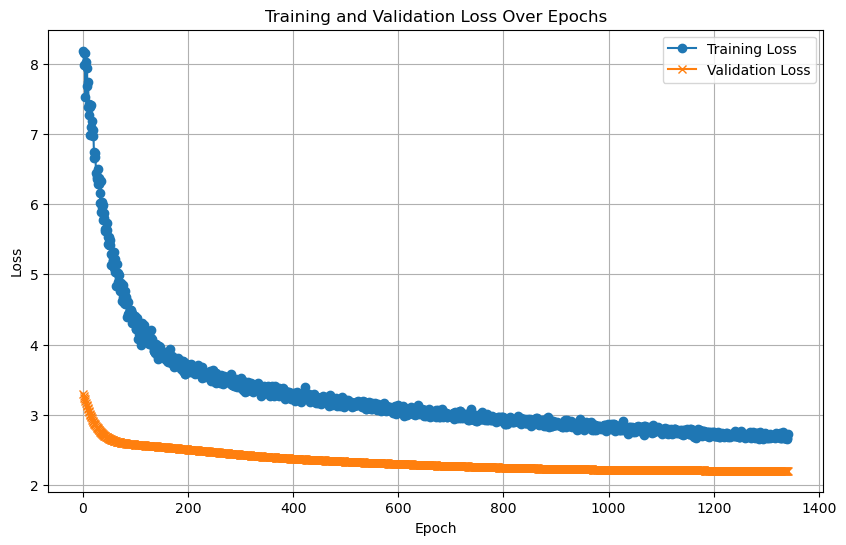

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/579], Loss: 5.1371
Test Batch [20/579], Loss: 5.2795
Test Batch [30/579], Loss: 5.1396


Test Batch [40/579], Loss: 4.9308
Test Batch [50/579], Loss: 5.0357
Test Batch [60/579], Loss: 5.0345
Test Batch [70/579], Loss: 4.9865
Test Batch [80/579], Loss: 4.9909
Test Batch [90/579], Loss: 5.2195
Test Batch [100/579], Loss: 5.0779
Test Batch [110/579], Loss: 5.1627
Test Batch [120/579], Loss: 5.2710
Test Batch [130/579], Loss: 5.1675
Test Batch [140/579], Loss: 5.2884
Test Batch [150/579], Loss: 5.3458


Test Batch [160/579], Loss: 5.3261
Test Batch [170/579], Loss: 5.3478
Test Batch [180/579], Loss: 5.5261


Test Batch [190/579], Loss: 5.1229
Test Batch [200/579], Loss: 5.2005
Test Batch [210/579], Loss: 5.1901
Test Batch [220/579], Loss: 4.9872
Test Batch [230/579], Loss: 5.0890
Test Batch [240/579], Loss: 4.9476
Test Batch [250/579], Loss: 5.1489
Test Batch [260/579], Loss: 5.1588
Test Batch [270/579], Loss: 5.4055
Test Batch [280/579], Loss: 5.5108
Test Batch [290/579], Loss: 5.1761
Test Batch [300/579], Loss: 5.1455
Test Batch [310/579], Loss: 4.8654


Test Batch [320/579], Loss: 4.7245


Test Batch [330/579], Loss: 4.6409
Test Batch [340/579], Loss: 4.8071
Test Batch [350/579], Loss: 4.8830
Test Batch [360/579], Loss: 4.5891
Test Batch [370/579], Loss: 5.0180
Test Batch [380/579], Loss: 5.3825
Test Batch [390/579], Loss: 4.8782
Test Batch [400/579], Loss: 4.6358
Test Batch [410/579], Loss: 4.5911
Test Batch [420/579], Loss: 4.7505
Test Batch [430/579], Loss: 4.6590
Test Batch [440/579], Loss: 4.7169
Test Batch [450/579], Loss: 4.5984


Test Batch [460/579], Loss: 4.4945
Test Batch [470/579], Loss: 4.5613
Test Batch [480/579], Loss: 5.3608
Test Batch [490/579], Loss: 4.6094
Test Batch [500/579], Loss: 4.5554
Test Batch [510/579], Loss: 4.5371
Test Batch [520/579], Loss: 4.9000
Test Batch [530/579], Loss: 4.4626
Test Batch [540/579], Loss: 5.3708
Test Batch [550/579], Loss: 5.4217
Test Batch [560/579], Loss: 5.5417
Test Batch [570/579], Loss: 5.4121

Test Loss: 5.0479


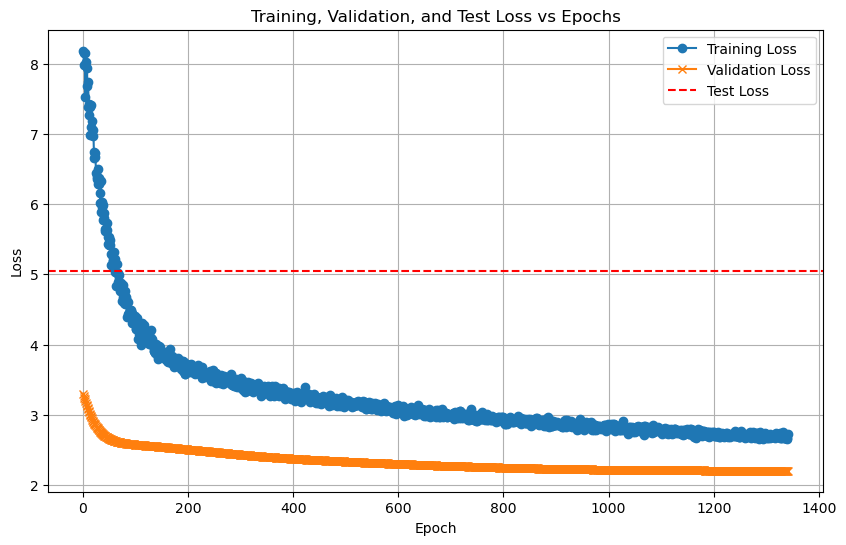

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/579 for test dataset.
  Processed batch 20/579 for test dataset.
  Processed batch 30/579 for test dataset.
  Processed batch 40/579 for test dataset.
  Processed batch 50/579 for test dataset.


  Processed batch 60/579 for test dataset.
  Processed batch 70/579 for test dataset.
  Processed batch 80/579 for test dataset.
  Processed batch 90/579 for test dataset.
  Processed batch 100/579 for test dataset.
  Processed batch 110/579 for test dataset.
  Processed batch 120/579 for test dataset.


  Processed batch 130/579 for test dataset.
  Processed batch 140/579 for test dataset.
  Processed batch 150/579 for test dataset.
  Processed batch 160/579 for test dataset.
  Processed batch 170/579 for test dataset.
  Processed batch 180/579 for test dataset.
  Processed batch 190/579 for test dataset.


  Processed batch 200/579 for test dataset.
  Processed batch 210/579 for test dataset.
  Processed batch 220/579 for test dataset.
  Processed batch 230/579 for test dataset.
  Processed batch 240/579 for test dataset.
  Processed batch 250/579 for test dataset.


  Processed batch 260/579 for test dataset.
  Processed batch 270/579 for test dataset.
  Processed batch 280/579 for test dataset.
  Processed batch 290/579 for test dataset.
  Processed batch 300/579 for test dataset.
  Processed batch 310/579 for test dataset.
  Processed batch 320/579 for test dataset.


  Processed batch 330/579 for test dataset.
  Processed batch 340/579 for test dataset.
  Processed batch 350/579 for test dataset.
  Processed batch 360/579 for test dataset.
  Processed batch 370/579 for test dataset.
  Processed batch 380/579 for test dataset.
  Processed batch 390/579 for test dataset.


  Processed batch 400/579 for test dataset.
  Processed batch 410/579 for test dataset.
  Processed batch 420/579 for test dataset.
  Processed batch 430/579 for test dataset.
  Processed batch 440/579 for test dataset.
  Processed batch 450/579 for test dataset.
  Processed batch 460/579 for test dataset.


  Processed batch 470/579 for test dataset.
  Processed batch 480/579 for test dataset.
  Processed batch 490/579 for test dataset.
  Processed batch 500/579 for test dataset.
  Processed batch 510/579 for test dataset.
  Processed batch 520/579 for test dataset.
  Processed batch 530/579 for test dataset.


  Processed batch 540/579 for test dataset.
  Processed batch 550/579 for test dataset.
  Processed batch 560/579 for test dataset.
  Processed batch 570/579 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148017, 128)
Test labels shape: (148017,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 84.44%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       1.00      0.60      0.75         5
           3       0.80      0.80      0.80         5
           4       0.67      0.80      0.73         5
           5       0.75      0.60      0.67         5
           6       0.71      1.00      0.83         5
           7       1.00      0.80      0.89         5
           8       1.00      1.00      1.00         5

    accuracy                           0.84        45
   macro avg       0.86      0.84      0.84        45
weighted avg       0.86      0.84      0.84        45


LOG: Evaluating on the test set...
Test Accuracy: 89.95%



Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     65956
           1       0.96      0.87      0.92      7583
           2       0.73      0.84      0.78      3075
           3       0.61      0.86      0.71      2670
           4       0.37      0.86      0.52      6569
           5       0.87      0.92      0.89      9233
           6       0.91      0.86      0.88      7272
           7       0.98      0.78      0.87     42811
           8       0.98      1.00      0.99      2848

    accuracy                           0.90    148017
   macro avg       0.82      0.89      0.84    148017
weighted avg       0.94      0.90      0.91    148017



Saved CAE+LRM predictions and true labels to model_predictions


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148017, 128)
Test labels shape: (148017,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.1432  |  Val Loss: 2.1236
Validation loss improved from inf to 2.1236.
[Epoch 2/1000] Train Loss: 2.1146  |  Val Loss: 2.0996
Validation loss improved from 2.1236 to 2.0996.
[Epoch 3/1000] Train Loss: 2.0838  |  Val Loss: 2.0754
Validation loss improved from 2.0996 to 2.0754.
[Epoch 4/1000] Train Loss: 2.0550  |  Val Loss: 2.0508
Validation loss improved from 2.0754 to 2.0508.
[Epoch 5/1000] Train Loss: 2.0270  |  Val Loss: 2.0277
Validation loss improved from 2.0508 to 2.0277.
[Epoch 6/1000] Train Loss: 1.9987  |  Val Loss: 2.0072
Validation loss improved from 2.0277 to 2.0072.
[Epoch 7/1000] Train Loss: 1.9765  |  Val Loss: 1.9881
Validation loss improved from 2.0072 to 1.9881.
[Epoch 8/1000] Train Loss: 1.9558  |  Val Loss: 1.9711
Validation loss improved from 1.9881 to 1.9711.
[Epoch 9/1000] Train Loss: 1.9367  |  Val Loss: 1.9544
Validation loss improved from 1.9711 to 1.9544.
[Epoch 10/1000] Train Loss: 1.9181  |  Val Loss: 1.9380
Validation loss impr

[Epoch 35/1000] Train Loss: 1.5032  |  Val Loss: 1.5794
Validation loss improved from 1.5928 to 1.5794.
[Epoch 36/1000] Train Loss: 1.4873  |  Val Loss: 1.5659
Validation loss improved from 1.5794 to 1.5659.
[Epoch 37/1000] Train Loss: 1.4720  |  Val Loss: 1.5525
Validation loss improved from 1.5659 to 1.5525.
[Epoch 38/1000] Train Loss: 1.4564  |  Val Loss: 1.5393
Validation loss improved from 1.5525 to 1.5393.
[Epoch 39/1000] Train Loss: 1.4410  |  Val Loss: 1.5262
Validation loss improved from 1.5393 to 1.5262.
[Epoch 40/1000] Train Loss: 1.4254  |  Val Loss: 1.5132
Validation loss improved from 1.5262 to 1.5132.
[Epoch 41/1000] Train Loss: 1.4104  |  Val Loss: 1.5000
Validation loss improved from 1.5132 to 1.5000.
[Epoch 42/1000] Train Loss: 1.3947  |  Val Loss: 1.4869
Validation loss improved from 1.5000 to 1.4869.
[Epoch 43/1000] Train Loss: 1.3793  |  Val Loss: 1.4736
Validation loss improved from 1.4869 to 1.4736.
[Epoch 44/1000] Train Loss: 1.3638  |  Val Loss: 1.4603
Validati

[Epoch 47/1000] Train Loss: 1.3177  |  Val Loss: 1.4213
Validation loss improved from 1.4342 to 1.4213.
[Epoch 48/1000] Train Loss: 1.3024  |  Val Loss: 1.4083
Validation loss improved from 1.4213 to 1.4083.
[Epoch 49/1000] Train Loss: 1.2869  |  Val Loss: 1.3950
Validation loss improved from 1.4083 to 1.3950.
[Epoch 50/1000] Train Loss: 1.2710  |  Val Loss: 1.3815
Validation loss improved from 1.3950 to 1.3815.
[Epoch 51/1000] Train Loss: 1.2557  |  Val Loss: 1.3680
Validation loss improved from 1.3815 to 1.3680.
[Epoch 52/1000] Train Loss: 1.2401  |  Val Loss: 1.3546
Validation loss improved from 1.3680 to 1.3546.
[Epoch 53/1000] Train Loss: 1.2243  |  Val Loss: 1.3413
Validation loss improved from 1.3546 to 1.3413.
[Epoch 54/1000] Train Loss: 1.2087  |  Val Loss: 1.3282
Validation loss improved from 1.3413 to 1.3282.
[Epoch 55/1000] Train Loss: 1.1929  |  Val Loss: 1.3151
Validation loss improved from 1.3282 to 1.3151.
[Epoch 56/1000] Train Loss: 1.1776  |  Val Loss: 1.3020
Validati

[Epoch 80/1000] Train Loss: 0.8386  |  Val Loss: 1.0072
Validation loss improved from 1.0181 to 1.0072.
[Epoch 81/1000] Train Loss: 0.8263  |  Val Loss: 0.9963
Validation loss improved from 1.0072 to 0.9963.
[Epoch 82/1000] Train Loss: 0.8136  |  Val Loss: 0.9852
Validation loss improved from 0.9963 to 0.9852.
[Epoch 83/1000] Train Loss: 0.8012  |  Val Loss: 0.9742
Validation loss improved from 0.9852 to 0.9742.
[Epoch 84/1000] Train Loss: 0.7890  |  Val Loss: 0.9636
Validation loss improved from 0.9742 to 0.9636.
[Epoch 85/1000] Train Loss: 0.7772  |  Val Loss: 0.9532
Validation loss improved from 0.9636 to 0.9532.
[Epoch 86/1000] Train Loss: 0.7650  |  Val Loss: 0.9430
Validation loss improved from 0.9532 to 0.9430.
[Epoch 87/1000] Train Loss: 0.7533  |  Val Loss: 0.9331
Validation loss improved from 0.9430 to 0.9331.
[Epoch 88/1000] Train Loss: 0.7418  |  Val Loss: 0.9232
Validation loss improved from 0.9331 to 0.9232.
[Epoch 89/1000] Train Loss: 0.7303  |  Val Loss: 0.9132
Validati

[Epoch 91/1000] Train Loss: 0.7081  |  Val Loss: 0.8931
Validation loss improved from 0.9029 to 0.8931.
[Epoch 92/1000] Train Loss: 0.6972  |  Val Loss: 0.8836
Validation loss improved from 0.8931 to 0.8836.
[Epoch 93/1000] Train Loss: 0.6864  |  Val Loss: 0.8743
Validation loss improved from 0.8836 to 0.8743.
[Epoch 94/1000] Train Loss: 0.6760  |  Val Loss: 0.8651
Validation loss improved from 0.8743 to 0.8651.
[Epoch 95/1000] Train Loss: 0.6655  |  Val Loss: 0.8561
Validation loss improved from 0.8651 to 0.8561.
[Epoch 96/1000] Train Loss: 0.6552  |  Val Loss: 0.8471
Validation loss improved from 0.8561 to 0.8471.
[Epoch 97/1000] Train Loss: 0.6450  |  Val Loss: 0.8385
Validation loss improved from 0.8471 to 0.8385.
[Epoch 98/1000] Train Loss: 0.6352  |  Val Loss: 0.8303
Validation loss improved from 0.8385 to 0.8303.
[Epoch 99/1000] Train Loss: 0.6253  |  Val Loss: 0.8220
Validation loss improved from 0.8303 to 0.8220.
[Epoch 100/1000] Train Loss: 0.6157  |  Val Loss: 0.8137
Validat

[Epoch 125/1000] Train Loss: 0.4200  |  Val Loss: 0.6484
Validation loss improved from 0.6534 to 0.6484.
[Epoch 126/1000] Train Loss: 0.4135  |  Val Loss: 0.6435
Validation loss improved from 0.6484 to 0.6435.
[Epoch 127/1000] Train Loss: 0.4071  |  Val Loss: 0.6385
Validation loss improved from 0.6435 to 0.6385.
[Epoch 128/1000] Train Loss: 0.4007  |  Val Loss: 0.6334
Validation loss improved from 0.6385 to 0.6334.
[Epoch 129/1000] Train Loss: 0.3944  |  Val Loss: 0.6289
Validation loss improved from 0.6334 to 0.6289.
[Epoch 130/1000] Train Loss: 0.3881  |  Val Loss: 0.6238
Validation loss improved from 0.6289 to 0.6238.
[Epoch 131/1000] Train Loss: 0.3819  |  Val Loss: 0.6188
Validation loss improved from 0.6238 to 0.6188.
[Epoch 132/1000] Train Loss: 0.3758  |  Val Loss: 0.6142
Validation loss improved from 0.6188 to 0.6142.
[Epoch 133/1000] Train Loss: 0.3698  |  Val Loss: 0.6094
Validation loss improved from 0.6142 to 0.6094.
[Epoch 134/1000] Train Loss: 0.3640  |  Val Loss: 0.604

[Epoch 137/1000] Train Loss: 0.3476  |  Val Loss: 0.5889
Validation loss improved from 0.5937 to 0.5889.
[Epoch 138/1000] Train Loss: 0.3425  |  Val Loss: 0.5848
Validation loss improved from 0.5889 to 0.5848.
[Epoch 139/1000] Train Loss: 0.3372  |  Val Loss: 0.5814
Validation loss improved from 0.5848 to 0.5814.
[Epoch 140/1000] Train Loss: 0.3322  |  Val Loss: 0.5784
Validation loss improved from 0.5814 to 0.5784.
[Epoch 141/1000] Train Loss: 0.3273  |  Val Loss: 0.5760
Validation loss improved from 0.5784 to 0.5760.
[Epoch 142/1000] Train Loss: 0.3223  |  Val Loss: 0.5731
Validation loss improved from 0.5760 to 0.5731.
[Epoch 143/1000] Train Loss: 0.3177  |  Val Loss: 0.5700
Validation loss improved from 0.5731 to 0.5700.
[Epoch 144/1000] Train Loss: 0.3129  |  Val Loss: 0.5667
Validation loss improved from 0.5700 to 0.5667.
[Epoch 145/1000] Train Loss: 0.3082  |  Val Loss: 0.5628
Validation loss improved from 0.5667 to 0.5628.
[Epoch 146/1000] Train Loss: 0.3036  |  Val Loss: 0.558

[Epoch 173/1000] Train Loss: 0.2068  |  Val Loss: 0.4816
Validation loss improved from 0.4837 to 0.4816.


[Epoch 174/1000] Train Loss: 0.2040  |  Val Loss: 0.4793
Validation loss improved from 0.4816 to 0.4793.
[Epoch 175/1000] Train Loss: 0.2014  |  Val Loss: 0.4774
Validation loss improved from 0.4793 to 0.4774.
[Epoch 176/1000] Train Loss: 0.1987  |  Val Loss: 0.4758
Validation loss improved from 0.4774 to 0.4758.
[Epoch 177/1000] Train Loss: 0.1960  |  Val Loss: 0.4747
Validation loss improved from 0.4758 to 0.4747.
[Epoch 178/1000] Train Loss: 0.1934  |  Val Loss: 0.4743
Validation loss improved from 0.4747 to 0.4743.
[Epoch 179/1000] Train Loss: 0.1907  |  Val Loss: 0.4743
Validation loss improved from 0.4743 to 0.4743.
[Epoch 180/1000] Train Loss: 0.1883  |  Val Loss: 0.4749
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 181/1000] Train Loss: 0.1858  |  Val Loss: 0.4752
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 182/1000] Train Loss: 0.1833  |  Val Loss: 0.4751
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 183/1000] Train Loss: 0.1809  

[Epoch 219/1000] Train Loss: 0.1137  |  Val Loss: 0.4484
Validation loss improved from 0.4492 to 0.4484.
[Epoch 220/1000] Train Loss: 0.1124  |  Val Loss: 0.4476
Validation loss improved from 0.4484 to 0.4476.
[Epoch 221/1000] Train Loss: 0.1110  |  Val Loss: 0.4468
Validation loss improved from 0.4476 to 0.4468.
[Epoch 222/1000] Train Loss: 0.1097  |  Val Loss: 0.4464
Validation loss improved from 0.4468 to 0.4464.
[Epoch 223/1000] Train Loss: 0.1084  |  Val Loss: 0.4460
Validation loss improved from 0.4464 to 0.4460.
[Epoch 224/1000] Train Loss: 0.1071  |  Val Loss: 0.4455
Validation loss improved from 0.4460 to 0.4455.
[Epoch 225/1000] Train Loss: 0.1058  |  Val Loss: 0.4451
Validation loss improved from 0.4455 to 0.4451.
[Epoch 226/1000] Train Loss: 0.1046  |  Val Loss: 0.4454
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 227/1000] Train Loss: 0.1033  |  Val Loss: 0.4460
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 228/1000] Train Loss: 0.1022  |  Val

[Epoch 262/1000] Train Loss: 0.0704  |  Val Loss: 0.4572
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 263/1000] Train Loss: 0.0697  |  Val Loss: 0.4567
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 264/1000] Train Loss: 0.0690  |  Val Loss: 0.4569
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 265/1000] Train Loss: 0.0683  |  Val Loss: 0.4576
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 266/1000] Train Loss: 0.0677  |  Val Loss: 0.4586
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 267/1000] Train Loss: 0.0670  |  Val Loss: 0.4592
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 268/1000] Train Loss: 0.0663  |  Val Loss: 0.4599
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 269/1000] Train Loss: 0.0657  |  Val Loss: 0.4606
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 270/1000] Train Loss: 0.0650  |  Val Loss: 0.4616
!! Validation loss did NOT improve !! Patience:

[Epoch 307/1000] Train Loss: 0.0465  |  Val Loss: 0.4704
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 308/1000] Train Loss: 0.0461  |  Val Loss: 0.4717
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 309/1000] Train Loss: 0.0457  |  Val Loss: 0.4728
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 310/1000] Train Loss: 0.0453  |  Val Loss: 0.4741
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 311/1000] Train Loss: 0.0450  |  Val Loss: 0.4751
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 312/1000] Train Loss: 0.0446  |  Val Loss: 0.4764
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 313/1000] Train Loss: 0.0442  |  Val Loss: 0.4771
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 314/1000] Train Loss: 0.0439  |  Val Loss: 0.4774
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 315/1000] Train Loss: 0.0435  |  Val Loss: 0.4778
!! Validation loss did NOT improve !! Patience:

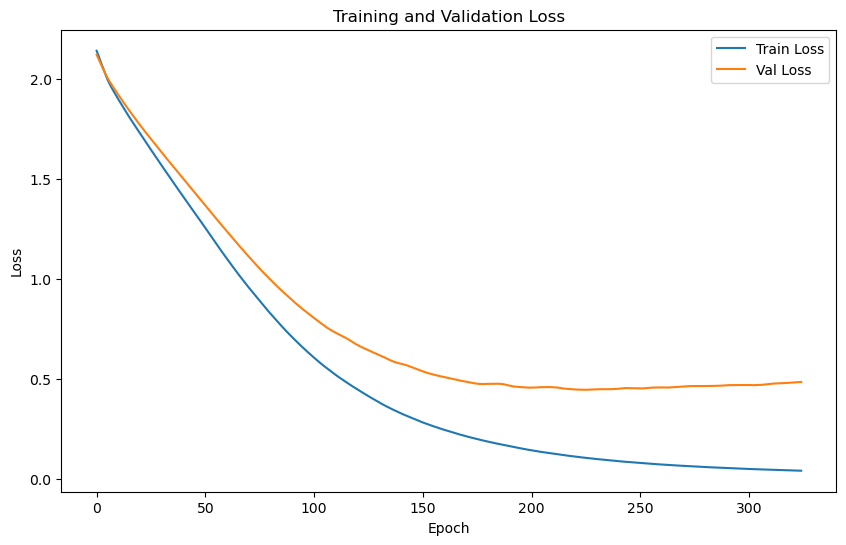

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.4171 | Test Accuracy: 86.57%


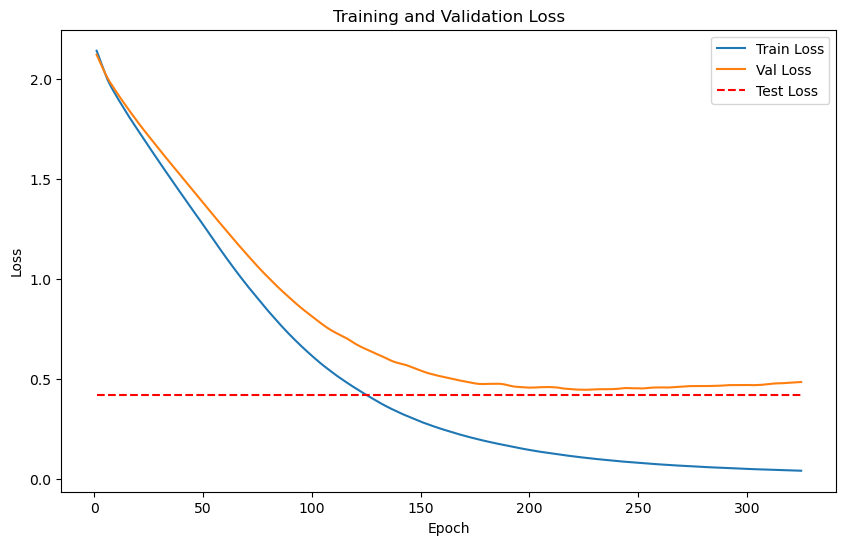

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 148017 samples with 64 features each
LOG: Labels shape: (148017,)


Train embeddings shape: (90, 64), 
Train labels shape: (90,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (148017, 64), 
Test labels shape: (148017,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10}
Training batch size: 90


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.3954
Epoch [1/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.3954

Validation loss improved from inf to 0.3954. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 0.4424
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.3951
Epoch [2/2000], Avg Train Loss: 0.4424, Avg Val Loss: 0.3951

Validation loss improved from 0.3954 to 0.3951. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4435
LOG: Epoch [3/2000] - Validation
    Batch [1/1], Val Loss: 0.3949
Epoch [3/2000], Avg Train Loss: 0.4435, Avg Val Loss: 0.3949

Validation loss improved from 0.3951 to 0.3949. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.4441
LOG: Epoch [4/2000] - Validation
    Batch [1/1], Val Loss: 0.3943
Epoch [4/2000], Avg Train Loss: 0.4441, Avg Val Loss: 0.3943

Validation loss improved from 0.3949 to 0.3943. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4357
LOG: Epoch [5/2000] - Validation
    Batch [1/1], Val Loss: 0.3937
Epoch [5/2000], Avg Train Loss: 0.4357, Avg Val Loss: 0.3937

Validation loss improved from 0.3943 to 0.3937. Saving model...
LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 0.4347
LOG: Epoch [6/2000] - Validation
    Batch [1/1], Val Loss: 0.3926
Epoch [6/2000], Avg Train Loss: 0.4347, Avg Val Loss: 0.3926

Validation loss improved from 0.3937 to 0.3926. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4306
LOG: Epoch [7/2000] - Validation
    Batch [1/1], Val Loss: 0.3911
Epoch [7/2000], Avg Train Loss: 0.4306, Avg Val Loss: 0.3911

Validation loss improved from 0.3926 to 0.3911. Saving model...
LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 0.4399
LOG: Epoch [8/2000] - Validation
    Batch [1/1], Val Loss: 0.3895
Epoch [8/2000], Avg Train Loss: 0.4399, Avg Val Loss: 0.3895

Validation loss improved from 0.3911 to 0.3895. Saving model...
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.4349
LOG: Epoch [9/2000] - Validation


    Batch [1/1], Val Loss: 0.3882
Epoch [9/2000], Avg Train Loss: 0.4349, Avg Val Loss: 0.3882

Validation loss improved from 0.3895 to 0.3882. Saving model...
LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 0.4357
LOG: Epoch [10/2000] - Validation
    Batch [1/1], Val Loss: 0.3872
Epoch [10/2000], Avg Train Loss: 0.4357, Avg Val Loss: 0.3872

Validation loss improved from 0.3882 to 0.3872. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 0.4341
LOG: Epoch [11/2000] - Validation


    Batch [1/1], Val Loss: 0.3858
Epoch [11/2000], Avg Train Loss: 0.4341, Avg Val Loss: 0.3858

Validation loss improved from 0.3872 to 0.3858. Saving model...
LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 0.4302
LOG: Epoch [12/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [12/2000], Avg Train Loss: 0.4302, Avg Val Loss: 0.3846

Validation loss improved from 0.3858 to 0.3846. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 0.4217
LOG: Epoch [13/2000] - Validation


    Batch [1/1], Val Loss: 0.3835
Epoch [13/2000], Avg Train Loss: 0.4217, Avg Val Loss: 0.3835

Validation loss improved from 0.3846 to 0.3835. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 0.4251
LOG: Epoch [14/2000] - Validation
    Batch [1/1], Val Loss: 0.3825
Epoch [14/2000], Avg Train Loss: 0.4251, Avg Val Loss: 0.3825

Validation loss improved from 0.3835 to 0.3825. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4264
LOG: Epoch [15/2000] - Validation
    Batch [1/1], Val Loss: 0.3813
Epoch [15/2000], Avg Train Loss: 0.4264, Avg Val Loss: 0.3813

Validation loss improved from 0.3825 to 0.3813. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 0.4313
LOG: Epoch [16/2000] - Validation
    Batch [1/1], Val Loss: 0.3802
Epoch [16/2000], Avg Train Loss: 0.4313, Avg Val Loss: 0.3802

Validation loss improved from 0.3813 to 0.3802. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4188
LOG: Epoch [17/2000] - Validation
    Batch [1/1], Val Loss: 0.3790
Epoch [17/2000], Avg Train Loss: 0.4188, Avg Val Loss: 0.3790

Validation loss improved from 0.3802 to 0.3790. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.4288
LOG: Epoch [18/2000] - Validation
    Batch [1/1], Val Loss: 0.3780
Epoch [18/2000], Avg Train Loss: 0.4288, Avg Val Loss: 0.3780

Validation loss improved from 0.3790 to 0.3780. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4193
LOG: Epoch [19/2000] - Validation
    Batch [1/1], Val Loss: 0.3771
Epoch [19/2000], Avg Train Loss: 0.4193, Avg Val Loss: 0.3771

Validation loss improved from 0.3780 to 0.3771. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 0.4179
LOG: Epoch [20/2000] - Validation
    Batch [1/1], Val Loss: 0.3762
Epoch [20/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.3762

Validation loss improved from 0.3771 to 0.3762. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4138
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.3753
Epoch [21/2000], Avg Train Loss: 0.4138, Avg Val Loss: 0.3753

Validation loss improved from 0.3762 to 0.3753. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.4049
LOG: Epoch [22/2000] - Validation
    Batch [1/1], Val Loss: 0.3744
Epoch [22/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.3744

Validation loss improved from 0.3753 to 0.3744. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4144
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.3737
Epoch [23/2000], Avg Train Loss: 0.4144, Avg Val Loss: 0.3737

Validation loss improved from 0.3744 to 0.3737. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 0.4062
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.3730
Epoch [24/2000], Avg Train Loss: 0.4062, Avg Val Loss: 0.3730

Validation loss improved from 0.3737 to 0.3730. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4159
LOG: Epoch [25/2000] - Validation
    Batch [1/1], Val Loss: 0.3723
Epoch [25/2000], Avg Train Loss: 0.4159, Avg Val Loss: 0.3723

Validation loss improved from 0.3730 to 0.3723. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 0.4077
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.3716
Epoch [26/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.3716

Validation loss improved from 0.3723 to 0.3716. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4106
LOG: Epoch [27/2000] - Validation
    Batch [1/1], Val Loss: 0.3709
Epoch [27/2000], Avg Train Loss: 0.4106, Avg Val Loss: 0.3709

Validation loss improved from 0.3716 to 0.3709. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.4100
LOG: Epoch [28/2000] - Validation
    Batch [1/1], Val Loss: 0.3702
Epoch [28/2000], Avg Train Loss: 0.4100, Avg Val Loss: 0.3702

Validation loss improved from 0.3709 to 0.3702. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [29/2000] - Validation
    Batch [1/1], Val Loss: 0.3695
Epoch [29/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.3695

Validation loss improved from 0.3702 to 0.3695. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.4131
LOG: Epoch [30/2000] - Validation
    Batch [1/1], Val Loss: 0.3688
Epoch [30/2000], Avg Train Loss: 0.4131, Avg Val Loss: 0.3688

Validation loss improved from 0.3695 to 0.3688. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4068
LOG: Epoch [31/2000] - Validation
    Batch [1/1], Val Loss: 0.3681
Epoch [31/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.3681

Validation loss improved from 0.3688 to 0.3681. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [32/2000] - Validation
    Batch [1/1], Val Loss: 0.3675
Epoch [32/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.3675

Validation loss improved from 0.3681 to 0.3675. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [33/2000] - Validation


    Batch [1/1], Val Loss: 0.3668
Epoch [33/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.3668

Validation loss improved from 0.3675 to 0.3668. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.3662
Epoch [34/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.3662

Validation loss improved from 0.3668 to 0.3662. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [35/2000] - Validation
    Batch [1/1], Val Loss: 0.3656
Epoch [35/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.3656

Validation loss improved from 0.3662 to 0.3656. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.3650
Epoch [36/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.3650

Validation loss improved from 0.3656 to 0.3650. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 0.3986
LOG: Epoch [37/2000] - Validation


    Batch [1/1], Val Loss: 0.3644
Epoch [37/2000], Avg Train Loss: 0.3986, Avg Val Loss: 0.3644

Validation loss improved from 0.3650 to 0.3644. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.3638
Epoch [38/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.3638

Validation loss improved from 0.3644 to 0.3638. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.3966
LOG: Epoch [39/2000] - Validation
    Batch [1/1], Val Loss: 0.3632
Epoch [39/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.3632

Validation loss improved from 0.3638 to 0.3632. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.3626
Epoch [40/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.3626

Validation loss improved from 0.3632 to 0.3626. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [41/2000] - Validation
    Batch [1/1], Val Loss: 0.3619
Epoch [41/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.3619

Validation loss improved from 0.3626 to 0.3619. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [42/2000] - Validation
    Batch [1/1], Val Loss: 0.3613
Epoch [42/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.3613

Validation loss improved from 0.3619 to 0.3613. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [43/2000] - Validation
    Batch [1/1], Val Loss: 0.3608
Epoch [43/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.3608

Validation loss improved from 0.3613 to 0.3608. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [44/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [44/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.3602

Validation loss improved from 0.3608 to 0.3602. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [45/2000] - Validation
    Batch [1/1], Val Loss: 0.3596
Epoch [45/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.3596

Validation loss improved from 0.3602 to 0.3596. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.3838
LOG: Epoch [46/2000] - Validation
    Batch [1/1], Val Loss: 0.3590
Epoch [46/2000], Avg Train Loss: 0.3838, Avg Val Loss: 0.3590

Validation loss improved from 0.3596 to 0.3590. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.3876
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.3584
Epoch [47/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.3584

Validation loss improved from 0.3590 to 0.3584. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [48/2000] - Validation
    Batch [1/1], Val Loss: 0.3578
Epoch [48/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.3578

Validation loss improved from 0.3584 to 0.3578. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [49/2000] - Validation
    Batch [1/1], Val Loss: 0.3572
Epoch [49/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.3572

Validation loss improved from 0.3578 to 0.3572. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.3855
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.3566
Epoch [50/2000], Avg Train Loss: 0.3855, Avg Val Loss: 0.3566

Validation loss improved from 0.3572 to 0.3566. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.3838
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.3560
Epoch [51/2000], Avg Train Loss: 0.3838, Avg Val Loss: 0.3560

Validation loss improved from 0.3566 to 0.3560. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 0.3816
LOG: Epoch [52/2000] - Validation
    Batch [1/1], Val Loss: 0.3555
Epoch [52/2000], Avg Train Loss: 0.3816, Avg Val Loss: 0.3555

Validation loss improved from 0.3560 to 0.3555. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.3837
LOG: Epoch [53/2000] - Validation
    Batch [1/1], Val Loss: 0.3549
Epoch [53/2000], Avg Train Loss: 0.3837, Avg Val Loss: 0.3549

Validation loss improved from 0.3555 to 0.3549. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 0.3825
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.3544
Epoch [54/2000], Avg Train Loss: 0.3825, Avg Val Loss: 0.3544

Validation loss improved from 0.3549 to 0.3544. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.3861
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.3538
Epoch [55/2000], Avg Train Loss: 0.3861, Avg Val Loss: 0.3538

Validation loss improved from 0.3544 to 0.3538. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [56/2000] - Validation
    Batch [1/1], Val Loss: 0.3533
Epoch [56/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.3533

Validation loss improved from 0.3538 to 0.3533. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.3673
LOG: Epoch [57/2000] - Validation
    Batch [1/1], Val Loss: 0.3527
Epoch [57/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.3527

Validation loss improved from 0.3533 to 0.3527. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.3806
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.3522
Epoch [58/2000], Avg Train Loss: 0.3806, Avg Val Loss: 0.3522

Validation loss improved from 0.3527 to 0.3522. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 0.3810
LOG: Epoch [59/2000] - Validation
    Batch [1/1], Val Loss: 0.3517
Epoch [59/2000], Avg Train Loss: 0.3810, Avg Val Loss: 0.3517

Validation loss improved from 0.3522 to 0.3517. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.3762
LOG: Epoch [60/2000] - Validation


    Batch [1/1], Val Loss: 0.3511
Epoch [60/2000], Avg Train Loss: 0.3762, Avg Val Loss: 0.3511

Validation loss improved from 0.3517 to 0.3511. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.3760
LOG: Epoch [61/2000] - Validation
    Batch [1/1], Val Loss: 0.3506
Epoch [61/2000], Avg Train Loss: 0.3760, Avg Val Loss: 0.3506

Validation loss improved from 0.3511 to 0.3506. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.3710
LOG: Epoch [62/2000] - Validation


    Batch [1/1], Val Loss: 0.3501
Epoch [62/2000], Avg Train Loss: 0.3710, Avg Val Loss: 0.3501

Validation loss improved from 0.3506 to 0.3501. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 0.3804
LOG: Epoch [63/2000] - Validation
    Batch [1/1], Val Loss: 0.3496
Epoch [63/2000], Avg Train Loss: 0.3804, Avg Val Loss: 0.3496

Validation loss improved from 0.3501 to 0.3496. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.3700
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.3491
Epoch [64/2000], Avg Train Loss: 0.3700, Avg Val Loss: 0.3491

Validation loss improved from 0.3496 to 0.3491. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.3696
LOG: Epoch [65/2000] - Validation
    Batch [1/1], Val Loss: 0.3486
Epoch [65/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.3486

Validation loss improved from 0.3491 to 0.3486. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.3696
LOG: Epoch [66/2000] - Validation
    Batch [1/1], Val Loss: 0.3481
Epoch [66/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.3481

Validation loss improved from 0.3486 to 0.3481. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.3659
LOG: Epoch [67/2000] - Validation
    Batch [1/1], Val Loss: 0.3476
Epoch [67/2000], Avg Train Loss: 0.3659, Avg Val Loss: 0.3476

Validation loss improved from 0.3481 to 0.3476. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.3703
LOG: Epoch [68/2000] - Validation
    Batch [1/1], Val Loss: 0.3471
Epoch [68/2000], Avg Train Loss: 0.3703, Avg Val Loss: 0.3471

Validation loss improved from 0.3476 to 0.3471. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.3720
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.3466
Epoch [69/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.3466

Validation loss improved from 0.3471 to 0.3466. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.3647
LOG: Epoch [70/2000] - Validation
    Batch [1/1], Val Loss: 0.3461
Epoch [70/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.3461

Validation loss improved from 0.3466 to 0.3461. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.3735
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.3456
Epoch [71/2000], Avg Train Loss: 0.3735, Avg Val Loss: 0.3456

Validation loss improved from 0.3461 to 0.3456. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.3640
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.3451
Epoch [72/2000], Avg Train Loss: 0.3640, Avg Val Loss: 0.3451

Validation loss improved from 0.3456 to 0.3451. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.3581
LOG: Epoch [73/2000] - Validation
    Batch [1/1], Val Loss: 0.3446
Epoch [73/2000], Avg Train Loss: 0.3581, Avg Val Loss: 0.3446

Validation loss improved from 0.3451 to 0.3446. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 0.3571
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.3441
Epoch [74/2000], Avg Train Loss: 0.3571, Avg Val Loss: 0.3441

Validation loss improved from 0.3446 to 0.3441. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.3692
LOG: Epoch [75/2000] - Validation
    Batch [1/1], Val Loss: 0.3436
Epoch [75/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.3436

Validation loss improved from 0.3441 to 0.3436. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.3575
LOG: Epoch [76/2000] - Validation
    Batch [1/1], Val Loss: 0.3432
Epoch [76/2000], Avg Train Loss: 0.3575, Avg Val Loss: 0.3432

Validation loss improved from 0.3436 to 0.3432. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.3592
LOG: Epoch [77/2000] - Validation


    Batch [1/1], Val Loss: 0.3427
Epoch [77/2000], Avg Train Loss: 0.3592, Avg Val Loss: 0.3427

Validation loss improved from 0.3432 to 0.3427. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.3656
LOG: Epoch [78/2000] - Validation
    Batch [1/1], Val Loss: 0.3422
Epoch [78/2000], Avg Train Loss: 0.3656, Avg Val Loss: 0.3422

Validation loss improved from 0.3427 to 0.3422. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 0.3612
LOG: Epoch [79/2000] - Validation


    Batch [1/1], Val Loss: 0.3417
Epoch [79/2000], Avg Train Loss: 0.3612, Avg Val Loss: 0.3417

Validation loss improved from 0.3422 to 0.3417. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.3589
LOG: Epoch [80/2000] - Validation
    Batch [1/1], Val Loss: 0.3412
Epoch [80/2000], Avg Train Loss: 0.3589, Avg Val Loss: 0.3412

Validation loss improved from 0.3417 to 0.3412. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.3514
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.3408
Epoch [81/2000], Avg Train Loss: 0.3514, Avg Val Loss: 0.3408

Validation loss improved from 0.3412 to 0.3408. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.3674
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.3403
Epoch [82/2000], Avg Train Loss: 0.3674, Avg Val Loss: 0.3403

Validation loss improved from 0.3408 to 0.3403. Saving model...
LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [83/2000] - Validation
    Batch [1/1], Val Loss: 0.3398
Epoch [83/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.3398

Validation loss improved from 0.3403 to 0.3398. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.3522
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.3394
Epoch [84/2000], Avg Train Loss: 0.3522, Avg Val Loss: 0.3394

Validation loss improved from 0.3398 to 0.3394. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.3458
LOG: Epoch [85/2000] - Validation
    Batch [1/1], Val Loss: 0.3389
Epoch [85/2000], Avg Train Loss: 0.3458, Avg Val Loss: 0.3389

Validation loss improved from 0.3394 to 0.3389. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.3472
LOG: Epoch [86/2000] - Validation
    Batch [1/1], Val Loss: 0.3384
Epoch [86/2000], Avg Train Loss: 0.3472, Avg Val Loss: 0.3384

Validation loss improved from 0.3389 to 0.3384. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.3547
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.3380
Epoch [87/2000], Avg Train Loss: 0.3547, Avg Val Loss: 0.3380

Validation loss improved from 0.3384 to 0.3380. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.3489
LOG: Epoch [88/2000] - Validation
    Batch [1/1], Val Loss: 0.3375
Epoch [88/2000], Avg Train Loss: 0.3489, Avg Val Loss: 0.3375

Validation loss improved from 0.3380 to 0.3375. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [89/2000] - Validation
    Batch [1/1], Val Loss: 0.3370
Epoch [89/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.3370

Validation loss improved from 0.3375 to 0.3370. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [90/2000] - Validation
    Batch [1/1], Val Loss: 0.3366
Epoch [90/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.3366

Validation loss improved from 0.3370 to 0.3366. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.3524
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [91/2000], Avg Train Loss: 0.3524, Avg Val Loss: 0.3362

Validation loss improved from 0.3366 to 0.3362. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.3531
LOG: Epoch [92/2000] - Validation
    Batch [1/1], Val Loss: 0.3357
Epoch [92/2000], Avg Train Loss: 0.3531, Avg Val Loss: 0.3357

Validation loss improved from 0.3362 to 0.3357. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.3458
LOG: Epoch [93/2000] - Validation
    Batch [1/1], Val Loss: 0.3353
Epoch [93/2000], Avg Train Loss: 0.3458, Avg Val Loss: 0.3353

Validation loss improved from 0.3357 to 0.3353. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.3364
LOG: Epoch [94/2000] - Validation
    Batch [1/1], Val Loss: 0.3349
Epoch [94/2000], Avg Train Loss: 0.3364, Avg Val Loss: 0.3349

Validation loss improved from 0.3353 to 0.3349. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 0.3391
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.3344
Epoch [95/2000], Avg Train Loss: 0.3391, Avg Val Loss: 0.3344

Validation loss improved from 0.3349 to 0.3344. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.3388
LOG: Epoch [96/2000] - Validation
    Batch [1/1], Val Loss: 0.3340
Epoch [96/2000], Avg Train Loss: 0.3388, Avg Val Loss: 0.3340

Validation loss improved from 0.3344 to 0.3340. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.3472
LOG: Epoch [97/2000] - Validation
    Batch [1/1], Val Loss: 0.3336
Epoch [97/2000], Avg Train Loss: 0.3472, Avg Val Loss: 0.3336

Validation loss improved from 0.3340 to 0.3336. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.3366
LOG: Epoch [98/2000] - Validation
    Batch [1/1], Val Loss: 0.3331
Epoch [98/2000], Avg Train Loss: 0.3366, Avg Val Loss: 0.3331

Validation loss improved from 0.3336 to 0.3331. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [99/2000] - Validation
    Batch [1/1], Val Loss: 0.3327
Epoch [99/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.3327

Validation loss improved from 0.3331 to 0.3327. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 0.3327
LOG: Epoch [100/2000] - Validation


    Batch [1/1], Val Loss: 0.3322
Epoch [100/2000], Avg Train Loss: 0.3327, Avg Val Loss: 0.3322

Validation loss improved from 0.3327 to 0.3322. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.3448
LOG: Epoch [101/2000] - Validation
    Batch [1/1], Val Loss: 0.3318
Epoch [101/2000], Avg Train Loss: 0.3448, Avg Val Loss: 0.3318

Validation loss improved from 0.3322 to 0.3318. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.3389
LOG: Epoch [102/2000] - Validation


    Batch [1/1], Val Loss: 0.3313
Epoch [102/2000], Avg Train Loss: 0.3389, Avg Val Loss: 0.3313

Validation loss improved from 0.3318 to 0.3313. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.3309
Epoch [103/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.3309

Validation loss improved from 0.3313 to 0.3309. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 0.3387
LOG: Epoch [104/2000] - Validation


    Batch [1/1], Val Loss: 0.3305
Epoch [104/2000], Avg Train Loss: 0.3387, Avg Val Loss: 0.3305

Validation loss improved from 0.3309 to 0.3305. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.3336
LOG: Epoch [105/2000] - Validation
    Batch [1/1], Val Loss: 0.3300
Epoch [105/2000], Avg Train Loss: 0.3336, Avg Val Loss: 0.3300

Validation loss improved from 0.3305 to 0.3300. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 0.3421
LOG: Epoch [106/2000] - Validation


    Batch [1/1], Val Loss: 0.3296
Epoch [106/2000], Avg Train Loss: 0.3421, Avg Val Loss: 0.3296

Validation loss improved from 0.3300 to 0.3296. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.3320
LOG: Epoch [107/2000] - Validation
    Batch [1/1], Val Loss: 0.3291
Epoch [107/2000], Avg Train Loss: 0.3320, Avg Val Loss: 0.3291

Validation loss improved from 0.3296 to 0.3291. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.3294
LOG: Epoch [108/2000] - Validation


    Batch [1/1], Val Loss: 0.3287
Epoch [108/2000], Avg Train Loss: 0.3294, Avg Val Loss: 0.3287

Validation loss improved from 0.3291 to 0.3287. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 0.3235
LOG: Epoch [109/2000] - Validation
    Batch [1/1], Val Loss: 0.3283
Epoch [109/2000], Avg Train Loss: 0.3235, Avg Val Loss: 0.3283

Validation loss improved from 0.3287 to 0.3283. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 0.3336
LOG: Epoch [110/2000] - Validation


    Batch [1/1], Val Loss: 0.3279
Epoch [110/2000], Avg Train Loss: 0.3336, Avg Val Loss: 0.3279

Validation loss improved from 0.3283 to 0.3279. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.3306
LOG: Epoch [111/2000] - Validation
    Batch [1/1], Val Loss: 0.3275
Epoch [111/2000], Avg Train Loss: 0.3306, Avg Val Loss: 0.3275

Validation loss improved from 0.3279 to 0.3275. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.3359
LOG: Epoch [112/2000] - Validation


    Batch [1/1], Val Loss: 0.3272
Epoch [112/2000], Avg Train Loss: 0.3359, Avg Val Loss: 0.3272

Validation loss improved from 0.3275 to 0.3272. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 0.3357
LOG: Epoch [113/2000] - Validation
    Batch [1/1], Val Loss: 0.3268
Epoch [113/2000], Avg Train Loss: 0.3357, Avg Val Loss: 0.3268

Validation loss improved from 0.3272 to 0.3268. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.3235
LOG: Epoch [114/2000] - Validation


    Batch [1/1], Val Loss: 0.3264
Epoch [114/2000], Avg Train Loss: 0.3235, Avg Val Loss: 0.3264

Validation loss improved from 0.3268 to 0.3264. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.3215
LOG: Epoch [115/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [115/2000], Avg Train Loss: 0.3215, Avg Val Loss: 0.3260

Validation loss improved from 0.3264 to 0.3260. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.3299
LOG: Epoch [116/2000] - Validation


    Batch [1/1], Val Loss: 0.3256
Epoch [116/2000], Avg Train Loss: 0.3299, Avg Val Loss: 0.3256

Validation loss improved from 0.3260 to 0.3256. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.3140
LOG: Epoch [117/2000] - Validation
    Batch [1/1], Val Loss: 0.3252
Epoch [117/2000], Avg Train Loss: 0.3140, Avg Val Loss: 0.3252

Validation loss improved from 0.3256 to 0.3252. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.3215
LOG: Epoch [118/2000] - Validation


    Batch [1/1], Val Loss: 0.3249
Epoch [118/2000], Avg Train Loss: 0.3215, Avg Val Loss: 0.3249

Validation loss improved from 0.3252 to 0.3249. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.3196
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.3245
Epoch [119/2000], Avg Train Loss: 0.3196, Avg Val Loss: 0.3245

Validation loss improved from 0.3249 to 0.3245. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.3190
LOG: Epoch [120/2000] - Validation


    Batch [1/1], Val Loss: 0.3242
Epoch [120/2000], Avg Train Loss: 0.3190, Avg Val Loss: 0.3242

Validation loss improved from 0.3245 to 0.3242. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.3195
LOG: Epoch [121/2000] - Validation
    Batch [1/1], Val Loss: 0.3238
Epoch [121/2000], Avg Train Loss: 0.3195, Avg Val Loss: 0.3238

Validation loss improved from 0.3242 to 0.3238. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.3152
LOG: Epoch [122/2000] - Validation


    Batch [1/1], Val Loss: 0.3235
Epoch [122/2000], Avg Train Loss: 0.3152, Avg Val Loss: 0.3235

Validation loss improved from 0.3238 to 0.3235. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.3154
LOG: Epoch [123/2000] - Validation
    Batch [1/1], Val Loss: 0.3231
Epoch [123/2000], Avg Train Loss: 0.3154, Avg Val Loss: 0.3231

Validation loss improved from 0.3235 to 0.3231. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.3161
LOG: Epoch [124/2000] - Validation


    Batch [1/1], Val Loss: 0.3228
Epoch [124/2000], Avg Train Loss: 0.3161, Avg Val Loss: 0.3228

Validation loss improved from 0.3231 to 0.3228. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.3229
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.3225
Epoch [125/2000], Avg Train Loss: 0.3229, Avg Val Loss: 0.3225

Validation loss improved from 0.3228 to 0.3225. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 0.3065
LOG: Epoch [126/2000] - Validation


    Batch [1/1], Val Loss: 0.3222
Epoch [126/2000], Avg Train Loss: 0.3065, Avg Val Loss: 0.3222

Validation loss improved from 0.3225 to 0.3222. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 0.3164
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.3219
Epoch [127/2000], Avg Train Loss: 0.3164, Avg Val Loss: 0.3219

Validation loss improved from 0.3222 to 0.3219. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 0.3161
LOG: Epoch [128/2000] - Validation
    Batch [1/1], Val Loss: 0.3216
Epoch [128/2000], Avg Train Loss: 0.3161, Avg Val Loss: 0.3216

Validation loss improved from 0.3219 to 0.3216. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.3100
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.3213
Epoch [129/2000], Avg Train Loss: 0.3100, Avg Val Loss: 0.3213

Validation loss improved from 0.3216 to 0.3213. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 0.3070
LOG: Epoch [130/2000] - Validation
    Batch [1/1], Val Loss: 0.3210
Epoch [130/2000], Avg Train Loss: 0.3070, Avg Val Loss: 0.3210

Validation loss improved from 0.3213 to 0.3210. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.3182
LOG: Epoch [131/2000] - Validation
    Batch [1/1], Val Loss: 0.3206
Epoch [131/2000], Avg Train Loss: 0.3182, Avg Val Loss: 0.3206

Validation loss improved from 0.3210 to 0.3206. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.3060
LOG: Epoch [132/2000] - Validation
    Batch [1/1], Val Loss: 0.3203
Epoch [132/2000], Avg Train Loss: 0.3060, Avg Val Loss: 0.3203

Validation loss improved from 0.3206 to 0.3203. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.3140
LOG: Epoch [133/2000] - Validation
    Batch [1/1], Val Loss: 0.3200
Epoch [133/2000], Avg Train Loss: 0.3140, Avg Val Loss: 0.3200

Validation loss improved from 0.3203 to 0.3200. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.3134
LOG: Epoch [134/2000] - Validation
    Batch [1/1], Val Loss: 0.3196
Epoch [134/2000], Avg Train Loss: 0.3134, Avg Val Loss: 0.3196

Validation loss improved from 0.3200 to 0.3196. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.3020
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.3193
Epoch [135/2000], Avg Train Loss: 0.3020, Avg Val Loss: 0.3193

Validation loss improved from 0.3196 to 0.3193. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 0.3103
LOG: Epoch [136/2000] - Validation
    Batch [1/1], Val Loss: 0.3190
Epoch [136/2000], Avg Train Loss: 0.3103, Avg Val Loss: 0.3190

Validation loss improved from 0.3193 to 0.3190. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.3053
LOG: Epoch [137/2000] - Validation
    Batch [1/1], Val Loss: 0.3188
Epoch [137/2000], Avg Train Loss: 0.3053, Avg Val Loss: 0.3188

Validation loss improved from 0.3190 to 0.3188. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.3134
LOG: Epoch [138/2000] - Validation
    Batch [1/1], Val Loss: 0.3185
Epoch [138/2000], Avg Train Loss: 0.3134, Avg Val Loss: 0.3185

Validation loss improved from 0.3188 to 0.3185. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.3078
LOG: Epoch [139/2000] - Validation
    Batch [1/1], Val Loss: 0.3182
Epoch [139/2000], Avg Train Loss: 0.3078, Avg Val Loss: 0.3182

Validation loss improved from 0.3185 to 0.3182. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 0.2998
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.3178
Epoch [140/2000], Avg Train Loss: 0.2998, Avg Val Loss: 0.3178

Validation loss improved from 0.3182 to 0.3178. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.3042
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.3175
Epoch [141/2000], Avg Train Loss: 0.3042, Avg Val Loss: 0.3175

Validation loss improved from 0.3178 to 0.3175. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.3112
LOG: Epoch [142/2000] - Validation
    Batch [1/1], Val Loss: 0.3172
Epoch [142/2000], Avg Train Loss: 0.3112, Avg Val Loss: 0.3172

Validation loss improved from 0.3175 to 0.3172. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.3032
LOG: Epoch [143/2000] - Validation
    Batch [1/1], Val Loss: 0.3169
Epoch [143/2000], Avg Train Loss: 0.3032, Avg Val Loss: 0.3169

Validation loss improved from 0.3172 to 0.3169. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 0.3078
LOG: Epoch [144/2000] - Validation
    Batch [1/1], Val Loss: 0.3166
Epoch [144/2000], Avg Train Loss: 0.3078, Avg Val Loss: 0.3166

Validation loss improved from 0.3169 to 0.3166. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.3128
LOG: Epoch [145/2000] - Validation
    Batch [1/1], Val Loss: 0.3163
Epoch [145/2000], Avg Train Loss: 0.3128, Avg Val Loss: 0.3163

Validation loss improved from 0.3166 to 0.3163. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 0.3075
LOG: Epoch [146/2000] - Validation
    Batch [1/1], Val Loss: 0.3160
Epoch [146/2000], Avg Train Loss: 0.3075, Avg Val Loss: 0.3160

Validation loss improved from 0.3163 to 0.3160. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.3085
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.3156
Epoch [147/2000], Avg Train Loss: 0.3085, Avg Val Loss: 0.3156

Validation loss improved from 0.3160 to 0.3156. Saving model...
LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 0.3051
LOG: Epoch [148/2000] - Validation
    Batch [1/1], Val Loss: 0.3153
Epoch [148/2000], Avg Train Loss: 0.3051, Avg Val Loss: 0.3153

Validation loss improved from 0.3156 to 0.3153. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.2937
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.3150
Epoch [149/2000], Avg Train Loss: 0.2937, Avg Val Loss: 0.3150

Validation loss improved from 0.3153 to 0.3150. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.2972
LOG: Epoch [150/2000] - Validation
    Batch [1/1], Val Loss: 0.3147
Epoch [150/2000], Avg Train Loss: 0.2972, Avg Val Loss: 0.3147

Validation loss improved from 0.3150 to 0.3147. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.2977
LOG: Epoch [151/2000] - Validation
    Batch [1/1], Val Loss: 0.3144
Epoch [151/2000], Avg Train Loss: 0.2977, Avg Val Loss: 0.3144

Validation loss improved from 0.3147 to 0.3144. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.2905
LOG: Epoch [152/2000] - Validation
    Batch [1/1], Val Loss: 0.3140
Epoch [152/2000], Avg Train Loss: 0.2905, Avg Val Loss: 0.3140

Validation loss improved from 0.3144 to 0.3140. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 0.2873
LOG: Epoch [153/2000] - Validation


    Batch [1/1], Val Loss: 0.3137
Epoch [153/2000], Avg Train Loss: 0.2873, Avg Val Loss: 0.3137

Validation loss improved from 0.3140 to 0.3137. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.2975
LOG: Epoch [154/2000] - Validation
    Batch [1/1], Val Loss: 0.3134
Epoch [154/2000], Avg Train Loss: 0.2975, Avg Val Loss: 0.3134

Validation loss improved from 0.3137 to 0.3134. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.2974
LOG: Epoch [155/2000] - Validation


    Batch [1/1], Val Loss: 0.3131
Epoch [155/2000], Avg Train Loss: 0.2974, Avg Val Loss: 0.3131

Validation loss improved from 0.3134 to 0.3131. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 0.3057
LOG: Epoch [156/2000] - Validation
    Batch [1/1], Val Loss: 0.3127
Epoch [156/2000], Avg Train Loss: 0.3057, Avg Val Loss: 0.3127

Validation loss improved from 0.3131 to 0.3127. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.2899
LOG: Epoch [157/2000] - Validation
    Batch [1/1], Val Loss: 0.3124
Epoch [157/2000], Avg Train Loss: 0.2899, Avg Val Loss: 0.3124

Validation loss improved from 0.3127 to 0.3124. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.2955
LOG: Epoch [158/2000] - Validation
    Batch [1/1], Val Loss: 0.3121
Epoch [158/2000], Avg Train Loss: 0.2955, Avg Val Loss: 0.3121

Validation loss improved from 0.3124 to 0.3121. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 0.2898
LOG: Epoch [159/2000] - Validation
    Batch [1/1], Val Loss: 0.3118
Epoch [159/2000], Avg Train Loss: 0.2898, Avg Val Loss: 0.3118

Validation loss improved from 0.3121 to 0.3118. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.2886
LOG: Epoch [160/2000] - Validation
    Batch [1/1], Val Loss: 0.3115
Epoch [160/2000], Avg Train Loss: 0.2886, Avg Val Loss: 0.3115

Validation loss improved from 0.3118 to 0.3115. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.2968
LOG: Epoch [161/2000] - Validation
    Batch [1/1], Val Loss: 0.3112
Epoch [161/2000], Avg Train Loss: 0.2968, Avg Val Loss: 0.3112

Validation loss improved from 0.3115 to 0.3112. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.2926
LOG: Epoch [162/2000] - Validation
    Batch [1/1], Val Loss: 0.3109
Epoch [162/2000], Avg Train Loss: 0.2926, Avg Val Loss: 0.3109

Validation loss improved from 0.3112 to 0.3109. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.2971
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.3107
Epoch [163/2000], Avg Train Loss: 0.2971, Avg Val Loss: 0.3107

Validation loss improved from 0.3109 to 0.3107. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.2924
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.3104
Epoch [164/2000], Avg Train Loss: 0.2924, Avg Val Loss: 0.3104

Validation loss improved from 0.3107 to 0.3104. Saving model...
LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 0.2856
LOG: Epoch [165/2000] - Validation
    Batch [1/1], Val Loss: 0.3102
Epoch [165/2000], Avg Train Loss: 0.2856, Avg Val Loss: 0.3102

Validation loss improved from 0.3104 to 0.3102. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.2817
LOG: Epoch [166/2000] - Validation
    Batch [1/1], Val Loss: 0.3099
Epoch [166/2000], Avg Train Loss: 0.2817, Avg Val Loss: 0.3099

Validation loss improved from 0.3102 to 0.3099. Saving model...
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.2986
LOG: Epoch [167/2000] - Validation
    Batch [1/1], Val Loss: 0.3096
Epoch [167/2000], Avg Train Loss: 0.2986, Avg Val Loss: 0.3096

Validation loss improved from 0.3099 to 0.3096. Saving model...
LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 0.2817
LOG: Epoch [168/2000] - Validation


    Batch [1/1], Val Loss: 0.3093
Epoch [168/2000], Avg Train Loss: 0.2817, Avg Val Loss: 0.3093

Validation loss improved from 0.3096 to 0.3093. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [169/2000] - Validation
    Batch [1/1], Val Loss: 0.3091
Epoch [169/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.3091

Validation loss improved from 0.3093 to 0.3091. Saving model...
LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 0.2799
LOG: Epoch [170/2000] - Validation


    Batch [1/1], Val Loss: 0.3088
Epoch [170/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.3088

Validation loss improved from 0.3091 to 0.3088. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.3086
Epoch [171/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.3086

Validation loss improved from 0.3088 to 0.3086. Saving model...
LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 0.2926
LOG: Epoch [172/2000] - Validation


    Batch [1/1], Val Loss: 0.3083
Epoch [172/2000], Avg Train Loss: 0.2926, Avg Val Loss: 0.3083

Validation loss improved from 0.3086 to 0.3083. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.2877
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.3080
Epoch [173/2000], Avg Train Loss: 0.2877, Avg Val Loss: 0.3080

Validation loss improved from 0.3083 to 0.3080. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 0.2913
LOG: Epoch [174/2000] - Validation


    Batch [1/1], Val Loss: 0.3078
Epoch [174/2000], Avg Train Loss: 0.2913, Avg Val Loss: 0.3078

Validation loss improved from 0.3080 to 0.3078. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 0.2877
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.3076
Epoch [175/2000], Avg Train Loss: 0.2877, Avg Val Loss: 0.3076

Validation loss improved from 0.3078 to 0.3076. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.2805
LOG: Epoch [176/2000] - Validation
    Batch [1/1], Val Loss: 0.3073
Epoch [176/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.3073

Validation loss improved from 0.3076 to 0.3073. Saving model...
LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 0.2901
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.3071
Epoch [177/2000], Avg Train Loss: 0.2901, Avg Val Loss: 0.3071

Validation loss improved from 0.3073 to 0.3071. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.2897
LOG: Epoch [178/2000] - Validation


    Batch [1/1], Val Loss: 0.3069
Epoch [178/2000], Avg Train Loss: 0.2897, Avg Val Loss: 0.3069

Validation loss improved from 0.3071 to 0.3069. Saving model...
LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 0.2815
LOG: Epoch [179/2000] - Validation
    Batch [1/1], Val Loss: 0.3067
Epoch [179/2000], Avg Train Loss: 0.2815, Avg Val Loss: 0.3067

Validation loss improved from 0.3069 to 0.3067. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.2805
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.3065
Epoch [180/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.3065

Validation loss improved from 0.3067 to 0.3065. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.2876
LOG: Epoch [181/2000] - Validation
    Batch [1/1], Val Loss: 0.3063
Epoch [181/2000], Avg Train Loss: 0.2876, Avg Val Loss: 0.3063

Validation loss improved from 0.3065 to 0.3063. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.2830
LOG: Epoch [182/2000] - Validation
    Batch [1/1], Val Loss: 0.3061
Epoch [182/2000], Avg Train Loss: 0.2830, Avg Val Loss: 0.3061

Validation loss improved from 0.3063 to 0.3061. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [183/2000] - Validation
    Batch [1/1], Val Loss: 0.3058
Epoch [183/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.3058

Validation loss improved from 0.3061 to 0.3058. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.3056
Epoch [184/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.3056

Validation loss improved from 0.3058 to 0.3056. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.2838
LOG: Epoch [185/2000] - Validation
    Batch [1/1], Val Loss: 0.3054
Epoch [185/2000], Avg Train Loss: 0.2838, Avg Val Loss: 0.3054

Validation loss improved from 0.3056 to 0.3054. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 0.2716
LOG: Epoch [186/2000] - Validation
    Batch [1/1], Val Loss: 0.3051
Epoch [186/2000], Avg Train Loss: 0.2716, Avg Val Loss: 0.3051

Validation loss improved from 0.3054 to 0.3051. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.2729
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.3049
Epoch [187/2000], Avg Train Loss: 0.2729, Avg Val Loss: 0.3049

Validation loss improved from 0.3051 to 0.3049. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 0.2733
LOG: Epoch [188/2000] - Validation
    Batch [1/1], Val Loss: 0.3046
Epoch [188/2000], Avg Train Loss: 0.2733, Avg Val Loss: 0.3046

Validation loss improved from 0.3049 to 0.3046. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.2755
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.3044
Epoch [189/2000], Avg Train Loss: 0.2755, Avg Val Loss: 0.3044

Validation loss improved from 0.3046 to 0.3044. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 0.2755
LOG: Epoch [190/2000] - Validation
    Batch [1/1], Val Loss: 0.3041
Epoch [190/2000], Avg Train Loss: 0.2755, Avg Val Loss: 0.3041

Validation loss improved from 0.3044 to 0.3041. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.2775
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.3039
Epoch [191/2000], Avg Train Loss: 0.2775, Avg Val Loss: 0.3039

Validation loss improved from 0.3041 to 0.3039. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.2727
LOG: Epoch [192/2000] - Validation
    Batch [1/1], Val Loss: 0.3036
Epoch [192/2000], Avg Train Loss: 0.2727, Avg Val Loss: 0.3036

Validation loss improved from 0.3039 to 0.3036. Saving model...
LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 0.2706
LOG: Epoch [193/2000] - Validation


    Batch [1/1], Val Loss: 0.3034
Epoch [193/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.3034

Validation loss improved from 0.3036 to 0.3034. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 0.2641
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.3032
Epoch [194/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.3032

Validation loss improved from 0.3034 to 0.3032. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.2664
LOG: Epoch [195/2000] - Validation


    Batch [1/1], Val Loss: 0.3029
Epoch [195/2000], Avg Train Loss: 0.2664, Avg Val Loss: 0.3029

Validation loss improved from 0.3032 to 0.3029. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 0.2752
LOG: Epoch [196/2000] - Validation
    Batch [1/1], Val Loss: 0.3027
Epoch [196/2000], Avg Train Loss: 0.2752, Avg Val Loss: 0.3027

Validation loss improved from 0.3029 to 0.3027. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.2655
LOG: Epoch [197/2000] - Validation


    Batch [1/1], Val Loss: 0.3024
Epoch [197/2000], Avg Train Loss: 0.2655, Avg Val Loss: 0.3024

Validation loss improved from 0.3027 to 0.3024. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.2863
LOG: Epoch [198/2000] - Validation
    Batch [1/1], Val Loss: 0.3022
Epoch [198/2000], Avg Train Loss: 0.2863, Avg Val Loss: 0.3022

Validation loss improved from 0.3024 to 0.3022. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [199/2000] - Validation


    Batch [1/1], Val Loss: 0.3019
Epoch [199/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.3019

Validation loss improved from 0.3022 to 0.3019. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 0.2715
LOG: Epoch [200/2000] - Validation
    Batch [1/1], Val Loss: 0.3017
Epoch [200/2000], Avg Train Loss: 0.2715, Avg Val Loss: 0.3017

Validation loss improved from 0.3019 to 0.3017. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [201/2000] - Validation


    Batch [1/1], Val Loss: 0.3014
Epoch [201/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.3014

Validation loss improved from 0.3017 to 0.3014. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 0.2765
LOG: Epoch [202/2000] - Validation
    Batch [1/1], Val Loss: 0.3011
Epoch [202/2000], Avg Train Loss: 0.2765, Avg Val Loss: 0.3011

Validation loss improved from 0.3014 to 0.3011. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.2650
LOG: Epoch [203/2000] - Validation


    Batch [1/1], Val Loss: 0.3009
Epoch [203/2000], Avg Train Loss: 0.2650, Avg Val Loss: 0.3009

Validation loss improved from 0.3011 to 0.3009. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 0.2753
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.3006
Epoch [204/2000], Avg Train Loss: 0.2753, Avg Val Loss: 0.3006

Validation loss improved from 0.3009 to 0.3006. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 0.2593
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [205/2000], Avg Train Loss: 0.2593, Avg Val Loss: 0.3003

Validation loss improved from 0.3006 to 0.3003. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.2563
LOG: Epoch [206/2000] - Validation
    Batch [1/1], Val Loss: 0.3000
Epoch [206/2000], Avg Train Loss: 0.2563, Avg Val Loss: 0.3000

Validation loss improved from 0.3003 to 0.3000. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.2573
LOG: Epoch [207/2000] - Validation
    Batch [1/1], Val Loss: 0.2997
Epoch [207/2000], Avg Train Loss: 0.2573, Avg Val Loss: 0.2997

Validation loss improved from 0.3000 to 0.2997. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.2666
LOG: Epoch [208/2000] - Validation
    Batch [1/1], Val Loss: 0.2994
Epoch [208/2000], Avg Train Loss: 0.2666, Avg Val Loss: 0.2994

Validation loss improved from 0.2997 to 0.2994. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 0.2649
LOG: Epoch [209/2000] - Validation
    Batch [1/1], Val Loss: 0.2991
Epoch [209/2000], Avg Train Loss: 0.2649, Avg Val Loss: 0.2991

Validation loss improved from 0.2994 to 0.2991. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.2595
LOG: Epoch [210/2000] - Validation
    Batch [1/1], Val Loss: 0.2988
Epoch [210/2000], Avg Train Loss: 0.2595, Avg Val Loss: 0.2988

Validation loss improved from 0.2991 to 0.2988. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.2562
LOG: Epoch [211/2000] - Validation
    Batch [1/1], Val Loss: 0.2985
Epoch [211/2000], Avg Train Loss: 0.2562, Avg Val Loss: 0.2985

Validation loss improved from 0.2988 to 0.2985. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.2592
LOG: Epoch [212/2000] - Validation
    Batch [1/1], Val Loss: 0.2982
Epoch [212/2000], Avg Train Loss: 0.2592, Avg Val Loss: 0.2982

Validation loss improved from 0.2985 to 0.2982. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 0.2608
LOG: Epoch [213/2000] - Validation
    Batch [1/1], Val Loss: 0.2979
Epoch [213/2000], Avg Train Loss: 0.2608, Avg Val Loss: 0.2979

Validation loss improved from 0.2982 to 0.2979. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.2578
LOG: Epoch [214/2000] - Validation
    Batch [1/1], Val Loss: 0.2976
Epoch [214/2000], Avg Train Loss: 0.2578, Avg Val Loss: 0.2976

Validation loss improved from 0.2979 to 0.2976. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.2608
LOG: Epoch [215/2000] - Validation
    Batch [1/1], Val Loss: 0.2973
Epoch [215/2000], Avg Train Loss: 0.2608, Avg Val Loss: 0.2973

Validation loss improved from 0.2976 to 0.2973. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 0.2599
LOG: Epoch [216/2000] - Validation


    Batch [1/1], Val Loss: 0.2971
Epoch [216/2000], Avg Train Loss: 0.2599, Avg Val Loss: 0.2971

Validation loss improved from 0.2973 to 0.2971. Saving model...
LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 0.2574
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.2968
Epoch [217/2000], Avg Train Loss: 0.2574, Avg Val Loss: 0.2968

Validation loss improved from 0.2971 to 0.2968. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.2617
LOG: Epoch [218/2000] - Validation
    Batch [1/1], Val Loss: 0.2965
Epoch [218/2000], Avg Train Loss: 0.2617, Avg Val Loss: 0.2965

Validation loss improved from 0.2968 to 0.2965. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 0.2699
LOG: Epoch [219/2000] - Validation
    Batch [1/1], Val Loss: 0.2963
Epoch [219/2000], Avg Train Loss: 0.2699, Avg Val Loss: 0.2963

Validation loss improved from 0.2965 to 0.2963. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.2664
LOG: Epoch [220/2000] - Validation
    Batch [1/1], Val Loss: 0.2961
Epoch [220/2000], Avg Train Loss: 0.2664, Avg Val Loss: 0.2961

Validation loss improved from 0.2963 to 0.2961. Saving model...
LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 0.2621
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.2958
Epoch [221/2000], Avg Train Loss: 0.2621, Avg Val Loss: 0.2958

Validation loss improved from 0.2961 to 0.2958. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.2599
LOG: Epoch [222/2000] - Validation
    Batch [1/1], Val Loss: 0.2957
Epoch [222/2000], Avg Train Loss: 0.2599, Avg Val Loss: 0.2957

Validation loss improved from 0.2958 to 0.2957. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.2553
LOG: Epoch [223/2000] - Validation
    Batch [1/1], Val Loss: 0.2955
Epoch [223/2000], Avg Train Loss: 0.2553, Avg Val Loss: 0.2955

Validation loss improved from 0.2957 to 0.2955. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.2599
LOG: Epoch [224/2000] - Validation
    Batch [1/1], Val Loss: 0.2953
Epoch [224/2000], Avg Train Loss: 0.2599, Avg Val Loss: 0.2953

Validation loss improved from 0.2955 to 0.2953. Saving model...
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.2583
LOG: Epoch [225/2000] - Validation
    Batch [1/1], Val Loss: 0.2950
Epoch [225/2000], Avg Train Loss: 0.2583, Avg Val Loss: 0.2950

Validation loss improved from 0.2953 to 0.2950. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.2619
LOG: Epoch [226/2000] - Validation
    Batch [1/1], Val Loss: 0.2948
Epoch [226/2000], Avg Train Loss: 0.2619, Avg Val Loss: 0.2948

Validation loss improved from 0.2950 to 0.2948. Saving model...
LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 0.2519
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.2945
Epoch [227/2000], Avg Train Loss: 0.2519, Avg Val Loss: 0.2945

Validation loss improved from 0.2948 to 0.2945. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.2529
LOG: Epoch [228/2000] - Validation
    Batch [1/1], Val Loss: 0.2943
Epoch [228/2000], Avg Train Loss: 0.2529, Avg Val Loss: 0.2943

Validation loss improved from 0.2945 to 0.2943. Saving model...
LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 0.2517
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.2941
Epoch [229/2000], Avg Train Loss: 0.2517, Avg Val Loss: 0.2941

Validation loss improved from 0.2943 to 0.2941. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.2437
LOG: Epoch [230/2000] - Validation
    Batch [1/1], Val Loss: 0.2938
Epoch [230/2000], Avg Train Loss: 0.2437, Avg Val Loss: 0.2938

Validation loss improved from 0.2941 to 0.2938. Saving model...
LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 0.2456
LOG: Epoch [231/2000] - Validation
    Batch [1/1], Val Loss: 0.2936
Epoch [231/2000], Avg Train Loss: 0.2456, Avg Val Loss: 0.2936

Validation loss improved from 0.2938 to 0.2936. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.2490
LOG: Epoch [232/2000] - Validation


    Batch [1/1], Val Loss: 0.2933
Epoch [232/2000], Avg Train Loss: 0.2490, Avg Val Loss: 0.2933

Validation loss improved from 0.2936 to 0.2933. Saving model...
LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 0.2445
LOG: Epoch [233/2000] - Validation
    Batch [1/1], Val Loss: 0.2931
Epoch [233/2000], Avg Train Loss: 0.2445, Avg Val Loss: 0.2931

Validation loss improved from 0.2933 to 0.2931. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.2524
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.2928
Epoch [234/2000], Avg Train Loss: 0.2524, Avg Val Loss: 0.2928

Validation loss improved from 0.2931 to 0.2928. Saving model...
LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 0.2556
LOG: Epoch [235/2000] - Validation
    Batch [1/1], Val Loss: 0.2926
Epoch [235/2000], Avg Train Loss: 0.2556, Avg Val Loss: 0.2926

Validation loss improved from 0.2928 to 0.2926. Saving model...
LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 0.2560
LOG: Epoch [236/2000] - Validation


    Batch [1/1], Val Loss: 0.2924
Epoch [236/2000], Avg Train Loss: 0.2560, Avg Val Loss: 0.2924

Validation loss improved from 0.2926 to 0.2924. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 0.2460
LOG: Epoch [237/2000] - Validation
    Batch [1/1], Val Loss: 0.2922
Epoch [237/2000], Avg Train Loss: 0.2460, Avg Val Loss: 0.2922

Validation loss improved from 0.2924 to 0.2922. Saving model...
LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 0.2442
LOG: Epoch [238/2000] - Validation
    Batch [1/1], Val Loss: 0.2921
Epoch [238/2000], Avg Train Loss: 0.2442, Avg Val Loss: 0.2921

Validation loss improved from 0.2922 to 0.2921. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.2485
LOG: Epoch [239/2000] - Validation
    Batch [1/1], Val Loss: 0.2918
Epoch [239/2000], Avg Train Loss: 0.2485, Avg Val Loss: 0.2918

Validation loss improved from 0.2921 to 0.2918. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 0.2470
LOG: Epoch [240/2000] - Validation
    Batch [1/1], Val Loss: 0.2917
Epoch [240/2000], Avg Train Loss: 0.2470, Avg Val Loss: 0.2917

Validation loss improved from 0.2918 to 0.2917. Saving model...
LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 0.2504
LOG: Epoch [241/2000] - Validation


    Batch [1/1], Val Loss: 0.2915
Epoch [241/2000], Avg Train Loss: 0.2504, Avg Val Loss: 0.2915

Validation loss improved from 0.2917 to 0.2915. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.2449
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.2913
Epoch [242/2000], Avg Train Loss: 0.2449, Avg Val Loss: 0.2913

Validation loss improved from 0.2915 to 0.2913. Saving model...
LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 0.2427
LOG: Epoch [243/2000] - Validation


    Batch [1/1], Val Loss: 0.2911
Epoch [243/2000], Avg Train Loss: 0.2427, Avg Val Loss: 0.2911

Validation loss improved from 0.2913 to 0.2911. Saving model...
LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 0.2455
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.2909
Epoch [244/2000], Avg Train Loss: 0.2455, Avg Val Loss: 0.2909

Validation loss improved from 0.2911 to 0.2909. Saving model...
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.2423
LOG: Epoch [245/2000] - Validation


    Batch [1/1], Val Loss: 0.2907
Epoch [245/2000], Avg Train Loss: 0.2423, Avg Val Loss: 0.2907

Validation loss improved from 0.2909 to 0.2907. Saving model...
LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 0.2365
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.2904
Epoch [246/2000], Avg Train Loss: 0.2365, Avg Val Loss: 0.2904

Validation loss improved from 0.2907 to 0.2904. Saving model...
LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 0.2397
LOG: Epoch [247/2000] - Validation


    Batch [1/1], Val Loss: 0.2902
Epoch [247/2000], Avg Train Loss: 0.2397, Avg Val Loss: 0.2902

Validation loss improved from 0.2904 to 0.2902. Saving model...
LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 0.2488
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.2900
Epoch [248/2000], Avg Train Loss: 0.2488, Avg Val Loss: 0.2900

Validation loss improved from 0.2902 to 0.2900. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 0.2442
LOG: Epoch [249/2000] - Validation


    Batch [1/1], Val Loss: 0.2898
Epoch [249/2000], Avg Train Loss: 0.2442, Avg Val Loss: 0.2898

Validation loss improved from 0.2900 to 0.2898. Saving model...
LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 0.2411
LOG: Epoch [250/2000] - Validation
    Batch [1/1], Val Loss: 0.2896
Epoch [250/2000], Avg Train Loss: 0.2411, Avg Val Loss: 0.2896

Validation loss improved from 0.2898 to 0.2896. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.2403
LOG: Epoch [251/2000] - Validation


    Batch [1/1], Val Loss: 0.2895
Epoch [251/2000], Avg Train Loss: 0.2403, Avg Val Loss: 0.2895

Validation loss improved from 0.2896 to 0.2895. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.2496
LOG: Epoch [252/2000] - Validation
    Batch [1/1], Val Loss: 0.2893
Epoch [252/2000], Avg Train Loss: 0.2496, Avg Val Loss: 0.2893

Validation loss improved from 0.2895 to 0.2893. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 0.2396
LOG: Epoch [253/2000] - Validation


    Batch [1/1], Val Loss: 0.2892
Epoch [253/2000], Avg Train Loss: 0.2396, Avg Val Loss: 0.2892

Validation loss improved from 0.2893 to 0.2892. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 0.2429
LOG: Epoch [254/2000] - Validation
    Batch [1/1], Val Loss: 0.2891
Epoch [254/2000], Avg Train Loss: 0.2429, Avg Val Loss: 0.2891

Validation loss improved from 0.2892 to 0.2891. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.2406
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.2889
Epoch [255/2000], Avg Train Loss: 0.2406, Avg Val Loss: 0.2889

Validation loss improved from 0.2891 to 0.2889. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.2410
LOG: Epoch [256/2000] - Validation
    Batch [1/1], Val Loss: 0.2888
Epoch [256/2000], Avg Train Loss: 0.2410, Avg Val Loss: 0.2888

Validation loss improved from 0.2889 to 0.2888. Saving model...
LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 0.2415
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [257/2000], Avg Train Loss: 0.2415, Avg Val Loss: 0.2886

Validation loss improved from 0.2888 to 0.2886. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 0.2282
LOG: Epoch [258/2000] - Validation


    Batch [1/1], Val Loss: 0.2884
Epoch [258/2000], Avg Train Loss: 0.2282, Avg Val Loss: 0.2884

Validation loss improved from 0.2886 to 0.2884. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 0.2337
LOG: Epoch [259/2000] - Validation
    Batch [1/1], Val Loss: 0.2883
Epoch [259/2000], Avg Train Loss: 0.2337, Avg Val Loss: 0.2883

Validation loss improved from 0.2884 to 0.2883. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.2328
LOG: Epoch [260/2000] - Validation
    Batch [1/1], Val Loss: 0.2881
Epoch [260/2000], Avg Train Loss: 0.2328, Avg Val Loss: 0.2881

Validation loss improved from 0.2883 to 0.2881. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.2453
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.2879
Epoch [261/2000], Avg Train Loss: 0.2453, Avg Val Loss: 0.2879

Validation loss improved from 0.2881 to 0.2879. Saving model...
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.2334
LOG: Epoch [262/2000] - Validation
    Batch [1/1], Val Loss: 0.2877
Epoch [262/2000], Avg Train Loss: 0.2334, Avg Val Loss: 0.2877

Validation loss improved from 0.2879 to 0.2877. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.2330
LOG: Epoch [263/2000] - Validation
    Batch [1/1], Val Loss: 0.2875
Epoch [263/2000], Avg Train Loss: 0.2330, Avg Val Loss: 0.2875

Validation loss improved from 0.2877 to 0.2875. Saving model...
LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 0.2338
LOG: Epoch [264/2000] - Validation
    Batch [1/1], Val Loss: 0.2873
Epoch [264/2000], Avg Train Loss: 0.2338, Avg Val Loss: 0.2873

Validation loss improved from 0.2875 to 0.2873. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.2438
LOG: Epoch [265/2000] - Validation
    Batch [1/1], Val Loss: 0.2871
Epoch [265/2000], Avg Train Loss: 0.2438, Avg Val Loss: 0.2871

Validation loss improved from 0.2873 to 0.2871. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.2404
LOG: Epoch [266/2000] - Validation
    Batch [1/1], Val Loss: 0.2869
Epoch [266/2000], Avg Train Loss: 0.2404, Avg Val Loss: 0.2869

Validation loss improved from 0.2871 to 0.2869. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.2344
LOG: Epoch [267/2000] - Validation
    Batch [1/1], Val Loss: 0.2867
Epoch [267/2000], Avg Train Loss: 0.2344, Avg Val Loss: 0.2867

Validation loss improved from 0.2869 to 0.2867. Saving model...
LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 0.2235
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.2864
Epoch [268/2000], Avg Train Loss: 0.2235, Avg Val Loss: 0.2864

Validation loss improved from 0.2867 to 0.2864. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.2367
LOG: Epoch [269/2000] - Validation


    Batch [1/1], Val Loss: 0.2862
Epoch [269/2000], Avg Train Loss: 0.2367, Avg Val Loss: 0.2862

Validation loss improved from 0.2864 to 0.2862. Saving model...
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.2247
LOG: Epoch [270/2000] - Validation
    Batch [1/1], Val Loss: 0.2860
Epoch [270/2000], Avg Train Loss: 0.2247, Avg Val Loss: 0.2860

Validation loss improved from 0.2862 to 0.2860. Saving model...
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.2479
LOG: Epoch [271/2000] - Validation


    Batch [1/1], Val Loss: 0.2858
Epoch [271/2000], Avg Train Loss: 0.2479, Avg Val Loss: 0.2858

Validation loss improved from 0.2860 to 0.2858. Saving model...
LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 0.2298
LOG: Epoch [272/2000] - Validation
    Batch [1/1], Val Loss: 0.2856
Epoch [272/2000], Avg Train Loss: 0.2298, Avg Val Loss: 0.2856

Validation loss improved from 0.2858 to 0.2856. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.2315
LOG: Epoch [273/2000] - Validation
    Batch [1/1], Val Loss: 0.2853
Epoch [273/2000], Avg Train Loss: 0.2315, Avg Val Loss: 0.2853

Validation loss improved from 0.2856 to 0.2853. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 0.2352
LOG: Epoch [274/2000] - Validation
    Batch [1/1], Val Loss: 0.2851
Epoch [274/2000], Avg Train Loss: 0.2352, Avg Val Loss: 0.2851

Validation loss improved from 0.2853 to 0.2851. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.2283
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.2849
Epoch [275/2000], Avg Train Loss: 0.2283, Avg Val Loss: 0.2849

Validation loss improved from 0.2851 to 0.2849. Saving model...
LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 0.2227
LOG: Epoch [276/2000] - Validation
    Batch [1/1], Val Loss: 0.2846
Epoch [276/2000], Avg Train Loss: 0.2227, Avg Val Loss: 0.2846

Validation loss improved from 0.2849 to 0.2846. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.2301
LOG: Epoch [277/2000] - Validation
    Batch [1/1], Val Loss: 0.2844
Epoch [277/2000], Avg Train Loss: 0.2301, Avg Val Loss: 0.2844

Validation loss improved from 0.2846 to 0.2844. Saving model...
LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 0.2282
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.2842
Epoch [278/2000], Avg Train Loss: 0.2282, Avg Val Loss: 0.2842

Validation loss improved from 0.2844 to 0.2842. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.2276
LOG: Epoch [279/2000] - Validation
    Batch [1/1], Val Loss: 0.2840
Epoch [279/2000], Avg Train Loss: 0.2276, Avg Val Loss: 0.2840

Validation loss improved from 0.2842 to 0.2840. Saving model...
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.2299
LOG: Epoch [280/2000] - Validation
    Batch [1/1], Val Loss: 0.2838
Epoch [280/2000], Avg Train Loss: 0.2299, Avg Val Loss: 0.2838

Validation loss improved from 0.2840 to 0.2838. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.2312
LOG: Epoch [281/2000] - Validation
    Batch [1/1], Val Loss: 0.2836
Epoch [281/2000], Avg Train Loss: 0.2312, Avg Val Loss: 0.2836

Validation loss improved from 0.2838 to 0.2836. Saving model...
LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 0.2380
LOG: Epoch [282/2000] - Validation
    Batch [1/1], Val Loss: 0.2834
Epoch [282/2000], Avg Train Loss: 0.2380, Avg Val Loss: 0.2834

Validation loss improved from 0.2836 to 0.2834. Saving model...
LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 0.2274
LOG: Epoch [283/2000] - Validation


    Batch [1/1], Val Loss: 0.2833
Epoch [283/2000], Avg Train Loss: 0.2274, Avg Val Loss: 0.2833

Validation loss improved from 0.2834 to 0.2833. Saving model...
LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 0.2292
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.2831
Epoch [284/2000], Avg Train Loss: 0.2292, Avg Val Loss: 0.2831

Validation loss improved from 0.2833 to 0.2831. Saving model...
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.2255
LOG: Epoch [285/2000] - Validation


    Batch [1/1], Val Loss: 0.2830
Epoch [285/2000], Avg Train Loss: 0.2255, Avg Val Loss: 0.2830

Validation loss improved from 0.2831 to 0.2830. Saving model...
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.2175
LOG: Epoch [286/2000] - Validation
    Batch [1/1], Val Loss: 0.2828
Epoch [286/2000], Avg Train Loss: 0.2175, Avg Val Loss: 0.2828

Validation loss improved from 0.2830 to 0.2828. Saving model...
LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 0.2201
LOG: Epoch [287/2000] - Validation


    Batch [1/1], Val Loss: 0.2826
Epoch [287/2000], Avg Train Loss: 0.2201, Avg Val Loss: 0.2826

Validation loss improved from 0.2828 to 0.2826. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.2258
LOG: Epoch [288/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [288/2000], Avg Train Loss: 0.2258, Avg Val Loss: 0.2824

Validation loss improved from 0.2826 to 0.2824. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.2319
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.2822
Epoch [289/2000], Avg Train Loss: 0.2319, Avg Val Loss: 0.2822

Validation loss improved from 0.2824 to 0.2822. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.2233
LOG: Epoch [290/2000] - Validation
    Batch [1/1], Val Loss: 0.2820
Epoch [290/2000], Avg Train Loss: 0.2233, Avg Val Loss: 0.2820

Validation loss improved from 0.2822 to 0.2820. Saving model...
LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 0.2268
LOG: Epoch [291/2000] - Validation
    Batch [1/1], Val Loss: 0.2818
Epoch [291/2000], Avg Train Loss: 0.2268, Avg Val Loss: 0.2818

Validation loss improved from 0.2820 to 0.2818. Saving model...
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.2220
LOG: Epoch [292/2000] - Validation


    Batch [1/1], Val Loss: 0.2816
Epoch [292/2000], Avg Train Loss: 0.2220, Avg Val Loss: 0.2816

Validation loss improved from 0.2818 to 0.2816. Saving model...
LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 0.2184
LOG: Epoch [293/2000] - Validation
    Batch [1/1], Val Loss: 0.2815
Epoch [293/2000], Avg Train Loss: 0.2184, Avg Val Loss: 0.2815

Validation loss improved from 0.2816 to 0.2815. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.2213
LOG: Epoch [294/2000] - Validation
    Batch [1/1], Val Loss: 0.2813
Epoch [294/2000], Avg Train Loss: 0.2213, Avg Val Loss: 0.2813

Validation loss improved from 0.2815 to 0.2813. Saving model...
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.2273
LOG: Epoch [295/2000] - Validation
    Batch [1/1], Val Loss: 0.2812
Epoch [295/2000], Avg Train Loss: 0.2273, Avg Val Loss: 0.2812

Validation loss improved from 0.2813 to 0.2812. Saving model...
LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 0.2177
LOG: Epoch [296/2000] - Validation


    Batch [1/1], Val Loss: 0.2810
Epoch [296/2000], Avg Train Loss: 0.2177, Avg Val Loss: 0.2810

Validation loss improved from 0.2812 to 0.2810. Saving model...
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.2221
LOG: Epoch [297/2000] - Validation
    Batch [1/1], Val Loss: 0.2808
Epoch [297/2000], Avg Train Loss: 0.2221, Avg Val Loss: 0.2808

Validation loss improved from 0.2810 to 0.2808. Saving model...
LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 0.2126
LOG: Epoch [298/2000] - Validation


    Batch [1/1], Val Loss: 0.2807
Epoch [298/2000], Avg Train Loss: 0.2126, Avg Val Loss: 0.2807

Validation loss improved from 0.2808 to 0.2807. Saving model...
LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 0.2206
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.2806
Epoch [299/2000], Avg Train Loss: 0.2206, Avg Val Loss: 0.2806

Validation loss improved from 0.2807 to 0.2806. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.2224
LOG: Epoch [300/2000] - Validation


    Batch [1/1], Val Loss: 0.2804
Epoch [300/2000], Avg Train Loss: 0.2224, Avg Val Loss: 0.2804

Validation loss improved from 0.2806 to 0.2804. Saving model...
LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 0.2231
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.2804
Epoch [301/2000], Avg Train Loss: 0.2231, Avg Val Loss: 0.2804

Validation loss improved from 0.2804 to 0.2804. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.2177
LOG: Epoch [302/2000] - Validation
    Batch [1/1], Val Loss: 0.2803
Epoch [302/2000], Avg Train Loss: 0.2177, Avg Val Loss: 0.2803

Validation loss improved from 0.2804 to 0.2803. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.2184
LOG: Epoch [303/2000] - Validation
    Batch [1/1], Val Loss: 0.2801
Epoch [303/2000], Avg Train Loss: 0.2184, Avg Val Loss: 0.2801

Validation loss improved from 0.2803 to 0.2801. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.2169
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.2800
Epoch [304/2000], Avg Train Loss: 0.2169, Avg Val Loss: 0.2800

Validation loss improved from 0.2801 to 0.2800. Saving model...
LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 0.2180
LOG: Epoch [305/2000] - Validation


    Batch [1/1], Val Loss: 0.2798
Epoch [305/2000], Avg Train Loss: 0.2180, Avg Val Loss: 0.2798

Validation loss improved from 0.2800 to 0.2798. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 0.2187
LOG: Epoch [306/2000] - Validation
    Batch [1/1], Val Loss: 0.2797
Epoch [306/2000], Avg Train Loss: 0.2187, Avg Val Loss: 0.2797

Validation loss improved from 0.2798 to 0.2797. Saving model...
LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 0.2115
LOG: Epoch [307/2000] - Validation


    Batch [1/1], Val Loss: 0.2795
Epoch [307/2000], Avg Train Loss: 0.2115, Avg Val Loss: 0.2795

Validation loss improved from 0.2797 to 0.2795. Saving model...
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.2102
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.2794
Epoch [308/2000], Avg Train Loss: 0.2102, Avg Val Loss: 0.2794

Validation loss improved from 0.2795 to 0.2794. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 0.2150
LOG: Epoch [309/2000] - Validation
    Batch [1/1], Val Loss: 0.2792
Epoch [309/2000], Avg Train Loss: 0.2150, Avg Val Loss: 0.2792

Validation loss improved from 0.2794 to 0.2792. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.2247
LOG: Epoch [310/2000] - Validation
    Batch [1/1], Val Loss: 0.2791
Epoch [310/2000], Avg Train Loss: 0.2247, Avg Val Loss: 0.2791

Validation loss improved from 0.2792 to 0.2791. Saving model...
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.2108
LOG: Epoch [311/2000] - Validation
    Batch [1/1], Val Loss: 0.2790
Epoch [311/2000], Avg Train Loss: 0.2108, Avg Val Loss: 0.2790

Validation loss improved from 0.2791 to 0.2790. Saving model...
LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 0.2155
LOG: Epoch [312/2000] - Validation


    Batch [1/1], Val Loss: 0.2789
Epoch [312/2000], Avg Train Loss: 0.2155, Avg Val Loss: 0.2789

Validation loss improved from 0.2790 to 0.2789. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.2231
LOG: Epoch [313/2000] - Validation
    Batch [1/1], Val Loss: 0.2787
Epoch [313/2000], Avg Train Loss: 0.2231, Avg Val Loss: 0.2787

Validation loss improved from 0.2789 to 0.2787. Saving model...
LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 0.2142
LOG: Epoch [314/2000] - Validation


    Batch [1/1], Val Loss: 0.2786
Epoch [314/2000], Avg Train Loss: 0.2142, Avg Val Loss: 0.2786

Validation loss improved from 0.2787 to 0.2786. Saving model...
LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 0.2190
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.2784
Epoch [315/2000], Avg Train Loss: 0.2190, Avg Val Loss: 0.2784

Validation loss improved from 0.2786 to 0.2784. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.2139
LOG: Epoch [316/2000] - Validation
    Batch [1/1], Val Loss: 0.2783
Epoch [316/2000], Avg Train Loss: 0.2139, Avg Val Loss: 0.2783

Validation loss improved from 0.2784 to 0.2783. Saving model...
LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 0.2155
LOG: Epoch [317/2000] - Validation
    Batch [1/1], Val Loss: 0.2782
Epoch [317/2000], Avg Train Loss: 0.2155, Avg Val Loss: 0.2782

Validation loss improved from 0.2783 to 0.2782. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.2096
LOG: Epoch [318/2000] - Validation
    Batch [1/1], Val Loss: 0.2782
Epoch [318/2000], Avg Train Loss: 0.2096, Avg Val Loss: 0.2782

Validation loss improved from 0.2782 to 0.2782. Saving model...
LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 0.2077
LOG: Epoch [319/2000] - Validation
    Batch [1/1], Val Loss: 0.2781
Epoch [319/2000], Avg Train Loss: 0.2077, Avg Val Loss: 0.2781

Validation loss improved from 0.2782 to 0.2781. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.2123
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.2781
Epoch [320/2000], Avg Train Loss: 0.2123, Avg Val Loss: 0.2781

Validation loss improved from 0.2781 to 0.2781. Saving model...
LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 0.2178
LOG: Epoch [321/2000] - Validation
    Batch [1/1], Val Loss: 0.2780
Epoch [321/2000], Avg Train Loss: 0.2178, Avg Val Loss: 0.2780

Validation loss improved from 0.2781 to 0.2780. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.2097
LOG: Epoch [322/2000] - Validation
    Batch [1/1], Val Loss: 0.2778
Epoch [322/2000], Avg Train Loss: 0.2097, Avg Val Loss: 0.2778

Validation loss improved from 0.2780 to 0.2778. Saving model...
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.2160
LOG: Epoch [323/2000] - Validation
    Batch [1/1], Val Loss: 0.2777
Epoch [323/2000], Avg Train Loss: 0.2160, Avg Val Loss: 0.2777

Validation loss improved from 0.2778 to 0.2777. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.2104
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.2775
Epoch [324/2000], Avg Train Loss: 0.2104, Avg Val Loss: 0.2775

Validation loss improved from 0.2777 to 0.2775. Saving model...
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.2051
LOG: Epoch [325/2000] - Validation
    Batch [1/1], Val Loss: 0.2774
Epoch [325/2000], Avg Train Loss: 0.2051, Avg Val Loss: 0.2774

Validation loss improved from 0.2775 to 0.2774. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.2146
LOG: Epoch [326/2000] - Validation
    Batch [1/1], Val Loss: 0.2772
Epoch [326/2000], Avg Train Loss: 0.2146, Avg Val Loss: 0.2772

Validation loss improved from 0.2774 to 0.2772. Saving model...
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.2120
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.2771
Epoch [327/2000], Avg Train Loss: 0.2120, Avg Val Loss: 0.2771

Validation loss improved from 0.2772 to 0.2771. Saving model...
LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 0.2078
LOG: Epoch [328/2000] - Validation


    Batch [1/1], Val Loss: 0.2769
Epoch [328/2000], Avg Train Loss: 0.2078, Avg Val Loss: 0.2769

Validation loss improved from 0.2771 to 0.2769. Saving model...
LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 0.2187
LOG: Epoch [329/2000] - Validation
    Batch [1/1], Val Loss: 0.2768
Epoch [329/2000], Avg Train Loss: 0.2187, Avg Val Loss: 0.2768

Validation loss improved from 0.2769 to 0.2768. Saving model...
LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 0.2193
LOG: Epoch [330/2000] - Validation


    Batch [1/1], Val Loss: 0.2766
Epoch [330/2000], Avg Train Loss: 0.2193, Avg Val Loss: 0.2766

Validation loss improved from 0.2768 to 0.2766. Saving model...
LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 0.2024
LOG: Epoch [331/2000] - Validation
    Batch [1/1], Val Loss: 0.2764
Epoch [331/2000], Avg Train Loss: 0.2024, Avg Val Loss: 0.2764

Validation loss improved from 0.2766 to 0.2764. Saving model...
LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 0.2046
LOG: Epoch [332/2000] - Validation


    Batch [1/1], Val Loss: 0.2762
Epoch [332/2000], Avg Train Loss: 0.2046, Avg Val Loss: 0.2762

Validation loss improved from 0.2764 to 0.2762. Saving model...
LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 0.2172
LOG: Epoch [333/2000] - Validation
    Batch [1/1], Val Loss: 0.2761
Epoch [333/2000], Avg Train Loss: 0.2172, Avg Val Loss: 0.2761

Validation loss improved from 0.2762 to 0.2761. Saving model...
LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 0.1985
LOG: Epoch [334/2000] - Validation
    Batch [1/1], Val Loss: 0.2759
Epoch [334/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.2759

Validation loss improved from 0.2761 to 0.2759. Saving model...
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.2120
LOG: Epoch [335/2000] - Validation
    Batch [1/1], Val Loss: 0.2757
Epoch [335/2000], Avg Train Loss: 0.2120, Avg Val Loss: 0.2757

Validation loss improved from 0.2759 to 0.2757. Saving model...
LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 0.2062
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.2755
Epoch [336/2000], Avg Train Loss: 0.2062, Avg Val Loss: 0.2755

Validation loss improved from 0.2757 to 0.2755. Saving model...
LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 0.2158
LOG: Epoch [337/2000] - Validation


    Batch [1/1], Val Loss: 0.2753
Epoch [337/2000], Avg Train Loss: 0.2158, Avg Val Loss: 0.2753

Validation loss improved from 0.2755 to 0.2753. Saving model...
LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 0.2161
LOG: Epoch [338/2000] - Validation
    Batch [1/1], Val Loss: 0.2752
Epoch [338/2000], Avg Train Loss: 0.2161, Avg Val Loss: 0.2752

Validation loss improved from 0.2753 to 0.2752. Saving model...
LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 0.2187
LOG: Epoch [339/2000] - Validation
    Batch [1/1], Val Loss: 0.2750
Epoch [339/2000], Avg Train Loss: 0.2187, Avg Val Loss: 0.2750

Validation loss improved from 0.2752 to 0.2750. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.2008
LOG: Epoch [340/2000] - Validation
    Batch [1/1], Val Loss: 0.2749
Epoch [340/2000], Avg Train Loss: 0.2008, Avg Val Loss: 0.2749

Validation loss improved from 0.2750 to 0.2749. Saving model...
LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 0.1996
LOG: Epoch [341/2000] - Validation
    Batch [1/1], Val Loss: 0.2748
Epoch [341/2000], Avg Train Loss: 0.1996, Avg Val Loss: 0.2748

Validation loss improved from 0.2749 to 0.2748. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.2001
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.2747
Epoch [342/2000], Avg Train Loss: 0.2001, Avg Val Loss: 0.2747

Validation loss improved from 0.2748 to 0.2747. Saving model...
LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 0.2012
LOG: Epoch [343/2000] - Validation
    Batch [1/1], Val Loss: 0.2746
Epoch [343/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.2746

Validation loss improved from 0.2747 to 0.2746. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.1945
LOG: Epoch [344/2000] - Validation
    Batch [1/1], Val Loss: 0.2744
Epoch [344/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.2744

Validation loss improved from 0.2746 to 0.2744. Saving model...
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.2013
LOG: Epoch [345/2000] - Validation
    Batch [1/1], Val Loss: 0.2743
Epoch [345/2000], Avg Train Loss: 0.2013, Avg Val Loss: 0.2743

Validation loss improved from 0.2744 to 0.2743. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.2028
LOG: Epoch [346/2000] - Validation
    Batch [1/1], Val Loss: 0.2742
Epoch [346/2000], Avg Train Loss: 0.2028, Avg Val Loss: 0.2742

Validation loss improved from 0.2743 to 0.2742. Saving model...
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.1924
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.2741
Epoch [347/2000], Avg Train Loss: 0.1924, Avg Val Loss: 0.2741

Validation loss improved from 0.2742 to 0.2741. Saving model...
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [348/2000] - Validation
    Batch [1/1], Val Loss: 0.2739
Epoch [348/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.2739

Validation loss improved from 0.2741 to 0.2739. Saving model...
LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 0.2019
LOG: Epoch [349/2000] - Validation
    Batch [1/1], Val Loss: 0.2738
Epoch [349/2000], Avg Train Loss: 0.2019, Avg Val Loss: 0.2738

Validation loss improved from 0.2739 to 0.2738. Saving model...
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.1991
LOG: Epoch [350/2000] - Validation


    Batch [1/1], Val Loss: 0.2736
Epoch [350/2000], Avg Train Loss: 0.1991, Avg Val Loss: 0.2736

Validation loss improved from 0.2738 to 0.2736. Saving model...
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.2084
LOG: Epoch [351/2000] - Validation
    Batch [1/1], Val Loss: 0.2735
Epoch [351/2000], Avg Train Loss: 0.2084, Avg Val Loss: 0.2735

Validation loss improved from 0.2736 to 0.2735. Saving model...
LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 0.2058
LOG: Epoch [352/2000] - Validation
    Batch [1/1], Val Loss: 0.2734
Epoch [352/2000], Avg Train Loss: 0.2058, Avg Val Loss: 0.2734

Validation loss improved from 0.2735 to 0.2734. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.2016
LOG: Epoch [353/2000] - Validation
    Batch [1/1], Val Loss: 0.2733
Epoch [353/2000], Avg Train Loss: 0.2016, Avg Val Loss: 0.2733

Validation loss improved from 0.2734 to 0.2733. Saving model...
LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [354/2000] - Validation
    Batch [1/1], Val Loss: 0.2732
Epoch [354/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.2732

Validation loss improved from 0.2733 to 0.2732. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.2007
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.2732
Epoch [355/2000], Avg Train Loss: 0.2007, Avg Val Loss: 0.2732

Validation loss improved from 0.2732 to 0.2732. Saving model...
LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [356/2000] - Validation
    Batch [1/1], Val Loss: 0.2731
Epoch [356/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.2731

Validation loss improved from 0.2732 to 0.2731. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.2014
LOG: Epoch [357/2000] - Validation
    Batch [1/1], Val Loss: 0.2730
Epoch [357/2000], Avg Train Loss: 0.2014, Avg Val Loss: 0.2730

Validation loss improved from 0.2731 to 0.2730. Saving model...
LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [358/2000] - Validation
    Batch [1/1], Val Loss: 0.2730
Epoch [358/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.2730

Validation loss improved from 0.2730 to 0.2730. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.1943
LOG: Epoch [359/2000] - Validation
    Batch [1/1], Val Loss: 0.2729
Epoch [359/2000], Avg Train Loss: 0.1943, Avg Val Loss: 0.2729

Validation loss improved from 0.2730 to 0.2729. Saving model...
LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 0.1934
LOG: Epoch [360/2000] - Validation
    Batch [1/1], Val Loss: 0.2729
Epoch [360/2000], Avg Train Loss: 0.1934, Avg Val Loss: 0.2729

Validation loss improved from 0.2729 to 0.2729. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.2039
LOG: Epoch [361/2000] - Validation
    Batch [1/1], Val Loss: 0.2727
Epoch [361/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.2727

Validation loss improved from 0.2729 to 0.2727. Saving model...
LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 0.2024
LOG: Epoch [362/2000] - Validation
    Batch [1/1], Val Loss: 0.2726
Epoch [362/2000], Avg Train Loss: 0.2024, Avg Val Loss: 0.2726

Validation loss improved from 0.2727 to 0.2726. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.1902
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.2726
Epoch [363/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.2726

Validation loss improved from 0.2726 to 0.2726. Saving model...
LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 0.1972
LOG: Epoch [364/2000] - Validation
    Batch [1/1], Val Loss: 0.2725
Epoch [364/2000], Avg Train Loss: 0.1972, Avg Val Loss: 0.2725

Validation loss improved from 0.2726 to 0.2725. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.1839
LOG: Epoch [365/2000] - Validation
    Batch [1/1], Val Loss: 0.2724
Epoch [365/2000], Avg Train Loss: 0.1839, Avg Val Loss: 0.2724

Validation loss improved from 0.2725 to 0.2724. Saving model...
LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 0.2038
LOG: Epoch [366/2000] - Validation
    Batch [1/1], Val Loss: 0.2724
Epoch [366/2000], Avg Train Loss: 0.2038, Avg Val Loss: 0.2724

Validation loss improved from 0.2724 to 0.2724. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.1936
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.2723
Epoch [367/2000], Avg Train Loss: 0.1936, Avg Val Loss: 0.2723

Validation loss improved from 0.2724 to 0.2723. Saving model...
LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 0.1836
LOG: Epoch [368/2000] - Validation
    Batch [1/1], Val Loss: 0.2723
Epoch [368/2000], Avg Train Loss: 0.1836, Avg Val Loss: 0.2723

Validation loss improved from 0.2723 to 0.2723. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.1944
LOG: Epoch [369/2000] - Validation
    Batch [1/1], Val Loss: 0.2722
Epoch [369/2000], Avg Train Loss: 0.1944, Avg Val Loss: 0.2722

Validation loss improved from 0.2723 to 0.2722. Saving model...
LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 0.1965
LOG: Epoch [370/2000] - Validation
    Batch [1/1], Val Loss: 0.2722
Epoch [370/2000], Avg Train Loss: 0.1965, Avg Val Loss: 0.2722

Validation loss improved from 0.2722 to 0.2722. Saving model...
LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 0.1971
LOG: Epoch [371/2000] - Validation


    Batch [1/1], Val Loss: 0.2721
Epoch [371/2000], Avg Train Loss: 0.1971, Avg Val Loss: 0.2721

Validation loss improved from 0.2722 to 0.2721. Saving model...
LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 0.1922
LOG: Epoch [372/2000] - Validation
    Batch [1/1], Val Loss: 0.2722
Epoch [372/2000], Avg Train Loss: 0.1922, Avg Val Loss: 0.2722

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 0.2004
LOG: Epoch [373/2000] - Validation
    Batch [1/1], Val Loss: 0.2722
Epoch [373/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.2722

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.1946
LOG: Epoch [374/2000] - Validation
    Batch [1/1], Val Loss: 0.2722
Epoch [374/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.2722

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 0.1881
LOG: Epoch [375/2000] - Validation
    Batch [1/1], Val Loss: 0.2722
Epoch [375/2000], Avg Train Loss: 0.1881, Avg Val Loss: 0.2722

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.1914
LOG: Epoch [376/2000] - Validation
    Batch [1/1], Val Loss: 0.2721
Epoch [376/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.2721

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [377/2000] - Validation
    Batch [1/1], Val Loss: 0.2722
Epoch [377/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.2722

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.1943
LOG: Epoch [378/2000] - Validation
    Batch [1/1], Val Loss: 0.2723
Epoch [378/2000], Avg Train Loss: 0.1943, Avg Val Loss: 0.2723

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 0.1874
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.2723
Epoch [379/2000], Avg Train Loss: 0.1874, Avg Val Loss: 0.2723

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.1879
LOG: Epoch [380/2000] - Validation
    Batch [1/1], Val Loss: 0.2723
Epoch [380/2000], Avg Train Loss: 0.1879, Avg Val Loss: 0.2723

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 0.1897
LOG: Epoch [381/2000] - Validation
    Batch [1/1], Val Loss: 0.2723
Epoch [381/2000], Avg Train Loss: 0.1897, Avg Val Loss: 0.2723

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 0.1835
LOG: Epoch [382/2000] - Validation


    Batch [1/1], Val Loss: 0.2723
Epoch [382/2000], Avg Train Loss: 0.1835, Avg Val Loss: 0.2723

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 0.1890
LOG: Epoch [383/2000] - Validation
    Batch [1/1], Val Loss: 0.2723
Epoch [383/2000], Avg Train Loss: 0.1890, Avg Val Loss: 0.2723

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [384/2000] - Validation


    Batch [1/1], Val Loss: 0.2722
Epoch [384/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.2722

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 0.1881
LOG: Epoch [385/2000] - Validation
    Batch [1/1], Val Loss: 0.2722
Epoch [385/2000], Avg Train Loss: 0.1881, Avg Val Loss: 0.2722

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 0.1898
LOG: Epoch [386/2000] - Validation
    Batch [1/1], Val Loss: 0.2722
Epoch [386/2000], Avg Train Loss: 0.1898, Avg Val Loss: 0.2722

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.1827
LOG: Epoch [387/2000] - Validation
    Batch [1/1], Val Loss: 0.2722
Epoch [387/2000], Avg Train Loss: 0.1827, Avg Val Loss: 0.2722

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.1922
LOG: Epoch [388/2000] - Validation
    Batch [1/1], Val Loss: 0.2721
Epoch [388/2000], Avg Train Loss: 0.1922, Avg Val Loss: 0.2721

Validation loss improved from 0.2721 to 0.2721. Saving model...
LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 0.1890
LOG: Epoch [389/2000] - Validation


    Batch [1/1], Val Loss: 0.2720
Epoch [389/2000], Avg Train Loss: 0.1890, Avg Val Loss: 0.2720

Validation loss improved from 0.2721 to 0.2720. Saving model...
LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 0.1857
LOG: Epoch [390/2000] - Validation
    Batch [1/1], Val Loss: 0.2720
Epoch [390/2000], Avg Train Loss: 0.1857, Avg Val Loss: 0.2720

Validation loss improved from 0.2720 to 0.2720. Saving model...
LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 0.1883
LOG: Epoch [391/2000] - Validation


    Batch [1/1], Val Loss: 0.2719
Epoch [391/2000], Avg Train Loss: 0.1883, Avg Val Loss: 0.2719

Validation loss improved from 0.2720 to 0.2719. Saving model...
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.1892
LOG: Epoch [392/2000] - Validation
    Batch [1/1], Val Loss: 0.2718
Epoch [392/2000], Avg Train Loss: 0.1892, Avg Val Loss: 0.2718

Validation loss improved from 0.2719 to 0.2718. Saving model...
LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 0.1951
LOG: Epoch [393/2000] - Validation


    Batch [1/1], Val Loss: 0.2718
Epoch [393/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.2718

Validation loss improved from 0.2718 to 0.2718. Saving model...
LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 0.1921
LOG: Epoch [394/2000] - Validation
    Batch [1/1], Val Loss: 0.2717
Epoch [394/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.2717

Validation loss improved from 0.2718 to 0.2717. Saving model...
LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 0.1866
LOG: Epoch [395/2000] - Validation


    Batch [1/1], Val Loss: 0.2717
Epoch [395/2000], Avg Train Loss: 0.1866, Avg Val Loss: 0.2717

Validation loss improved from 0.2717 to 0.2717. Saving model...
LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 0.1771
LOG: Epoch [396/2000] - Validation
    Batch [1/1], Val Loss: 0.2717
Epoch [396/2000], Avg Train Loss: 0.1771, Avg Val Loss: 0.2717

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 0.1866
LOG: Epoch [397/2000] - Validation


    Batch [1/1], Val Loss: 0.2716
Epoch [397/2000], Avg Train Loss: 0.1866, Avg Val Loss: 0.2716

Validation loss improved from 0.2717 to 0.2716. Saving model...
LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 0.1902
LOG: Epoch [398/2000] - Validation
    Batch [1/1], Val Loss: 0.2716
Epoch [398/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.2716

Validation loss improved from 0.2716 to 0.2716. Saving model...
LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 0.1901
LOG: Epoch [399/2000] - Validation
    Batch [1/1], Val Loss: 0.2715
Epoch [399/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.2715

Validation loss improved from 0.2716 to 0.2715. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.1856
LOG: Epoch [400/2000] - Validation
    Batch [1/1], Val Loss: 0.2714
Epoch [400/2000], Avg Train Loss: 0.1856, Avg Val Loss: 0.2714

Validation loss improved from 0.2715 to 0.2714. Saving model...
LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 0.1903
LOG: Epoch [401/2000] - Validation
    Batch [1/1], Val Loss: 0.2713
Epoch [401/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.2713

Validation loss improved from 0.2714 to 0.2713. Saving model...
LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 0.1821
LOG: Epoch [402/2000] - Validation


    Batch [1/1], Val Loss: 0.2713
Epoch [402/2000], Avg Train Loss: 0.1821, Avg Val Loss: 0.2713

Validation loss improved from 0.2713 to 0.2713. Saving model...
LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 0.1860
LOG: Epoch [403/2000] - Validation
    Batch [1/1], Val Loss: 0.2712
Epoch [403/2000], Avg Train Loss: 0.1860, Avg Val Loss: 0.2712

Validation loss improved from 0.2713 to 0.2712. Saving model...
LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 0.1797
LOG: Epoch [404/2000] - Validation
    Batch [1/1], Val Loss: 0.2712
Epoch [404/2000], Avg Train Loss: 0.1797, Avg Val Loss: 0.2712

Validation loss improved from 0.2712 to 0.2712. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.1792
LOG: Epoch [405/2000] - Validation
    Batch [1/1], Val Loss: 0.2711
Epoch [405/2000], Avg Train Loss: 0.1792, Avg Val Loss: 0.2711

Validation loss improved from 0.2712 to 0.2711. Saving model...
LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 0.1859
LOG: Epoch [406/2000] - Validation
    Batch [1/1], Val Loss: 0.2710
Epoch [406/2000], Avg Train Loss: 0.1859, Avg Val Loss: 0.2710

Validation loss improved from 0.2711 to 0.2710. Saving model...
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.1829
LOG: Epoch [407/2000] - Validation
    Batch [1/1], Val Loss: 0.2709
Epoch [407/2000], Avg Train Loss: 0.1829, Avg Val Loss: 0.2709

Validation loss improved from 0.2710 to 0.2709. Saving model...
LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 0.1902
LOG: Epoch [408/2000] - Validation
    Batch [1/1], Val Loss: 0.2709
Epoch [408/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.2709

Validation loss improved from 0.2709 to 0.2709. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.1840
LOG: Epoch [409/2000] - Validation
    Batch [1/1], Val Loss: 0.2708
Epoch [409/2000], Avg Train Loss: 0.1840, Avg Val Loss: 0.2708

Validation loss improved from 0.2709 to 0.2708. Saving model...
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.1922
LOG: Epoch [410/2000] - Validation
    Batch [1/1], Val Loss: 0.2708
Epoch [410/2000], Avg Train Loss: 0.1922, Avg Val Loss: 0.2708

Validation loss improved from 0.2708 to 0.2708. Saving model...
LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 0.1727
LOG: Epoch [411/2000] - Validation


    Batch [1/1], Val Loss: 0.2707
Epoch [411/2000], Avg Train Loss: 0.1727, Avg Val Loss: 0.2707

Validation loss improved from 0.2708 to 0.2707. Saving model...
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.1748
LOG: Epoch [412/2000] - Validation
    Batch [1/1], Val Loss: 0.2707
Epoch [412/2000], Avg Train Loss: 0.1748, Avg Val Loss: 0.2707

Validation loss improved from 0.2707 to 0.2707. Saving model...
LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 0.1839
LOG: Epoch [413/2000] - Validation
    Batch [1/1], Val Loss: 0.2706
Epoch [413/2000], Avg Train Loss: 0.1839, Avg Val Loss: 0.2706

Validation loss improved from 0.2707 to 0.2706. Saving model...
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.1831
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.2705
Epoch [414/2000], Avg Train Loss: 0.1831, Avg Val Loss: 0.2705

Validation loss improved from 0.2706 to 0.2705. Saving model...
LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 0.1808
LOG: Epoch [415/2000] - Validation
    Batch [1/1], Val Loss: 0.2704
Epoch [415/2000], Avg Train Loss: 0.1808, Avg Val Loss: 0.2704

Validation loss improved from 0.2705 to 0.2704. Saving model...
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.1839
LOG: Epoch [416/2000] - Validation
    Batch [1/1], Val Loss: 0.2703
Epoch [416/2000], Avg Train Loss: 0.1839, Avg Val Loss: 0.2703

Validation loss improved from 0.2704 to 0.2703. Saving model...
LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 0.1773
LOG: Epoch [417/2000] - Validation
    Batch [1/1], Val Loss: 0.2703
Epoch [417/2000], Avg Train Loss: 0.1773, Avg Val Loss: 0.2703

Validation loss improved from 0.2703 to 0.2703. Saving model...
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.1785
LOG: Epoch [418/2000] - Validation
    Batch [1/1], Val Loss: 0.2703
Epoch [418/2000], Avg Train Loss: 0.1785, Avg Val Loss: 0.2703

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 0.1772
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.2703
Epoch [419/2000], Avg Train Loss: 0.1772, Avg Val Loss: 0.2703

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.1775
LOG: Epoch [420/2000] - Validation
    Batch [1/1], Val Loss: 0.2704
Epoch [420/2000], Avg Train Loss: 0.1775, Avg Val Loss: 0.2704

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.1864
LOG: Epoch [421/2000] - Validation
    Batch [1/1], Val Loss: 0.2705
Epoch [421/2000], Avg Train Loss: 0.1864, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.1779
LOG: Epoch [422/2000] - Validation
    Batch [1/1], Val Loss: 0.2706
Epoch [422/2000], Avg Train Loss: 0.1779, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 0.1849
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.2707
Epoch [423/2000], Avg Train Loss: 0.1849, Avg Val Loss: 0.2707

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 0.1696
LOG: Epoch [424/2000] - Validation


    Batch [1/1], Val Loss: 0.2708
Epoch [424/2000], Avg Train Loss: 0.1696, Avg Val Loss: 0.2708

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 0.1790
LOG: Epoch [425/2000] - Validation
    Batch [1/1], Val Loss: 0.2709
Epoch [425/2000], Avg Train Loss: 0.1790, Avg Val Loss: 0.2709

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 0.1768
LOG: Epoch [426/2000] - Validation


    Batch [1/1], Val Loss: 0.2709
Epoch [426/2000], Avg Train Loss: 0.1768, Avg Val Loss: 0.2709

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 0.1767
LOG: Epoch [427/2000] - Validation
    Batch [1/1], Val Loss: 0.2709
Epoch [427/2000], Avg Train Loss: 0.1767, Avg Val Loss: 0.2709

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 0.1808
LOG: Epoch [428/2000] - Validation
    Batch [1/1], Val Loss: 0.2707
Epoch [428/2000], Avg Train Loss: 0.1808, Avg Val Loss: 0.2707

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.1770
LOG: Epoch [429/2000] - Validation
    Batch [1/1], Val Loss: 0.2706
Epoch [429/2000], Avg Train Loss: 0.1770, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 0.1828
LOG: Epoch [430/2000] - Validation
    Batch [1/1], Val Loss: 0.2704
Epoch [430/2000], Avg Train Loss: 0.1828, Avg Val Loss: 0.2704

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 0.1710
LOG: Epoch [431/2000] - Validation


    Batch [1/1], Val Loss: 0.2704
Epoch [431/2000], Avg Train Loss: 0.1710, Avg Val Loss: 0.2704

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 0.1798
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.2704
Epoch [432/2000], Avg Train Loss: 0.1798, Avg Val Loss: 0.2704

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 0.1774
LOG: Epoch [433/2000] - Validation


    Batch [1/1], Val Loss: 0.2703
Epoch [433/2000], Avg Train Loss: 0.1774, Avg Val Loss: 0.2703

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 0.1742
LOG: Epoch [434/2000] - Validation
    Batch [1/1], Val Loss: 0.2702
Epoch [434/2000], Avg Train Loss: 0.1742, Avg Val Loss: 0.2702

Validation loss improved from 0.2703 to 0.2702. Saving model...
LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 0.1777
LOG: Epoch [435/2000] - Validation
    Batch [1/1], Val Loss: 0.2702
Epoch [435/2000], Avg Train Loss: 0.1777, Avg Val Loss: 0.2702

Validation loss improved from 0.2702 to 0.2702. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.1741
LOG: Epoch [436/2000] - Validation
    Batch [1/1], Val Loss: 0.2701
Epoch [436/2000], Avg Train Loss: 0.1741, Avg Val Loss: 0.2701

Validation loss improved from 0.2702 to 0.2701. Saving model...
LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 0.1826
LOG: Epoch [437/2000] - Validation
    Batch [1/1], Val Loss: 0.2699
Epoch [437/2000], Avg Train Loss: 0.1826, Avg Val Loss: 0.2699

Validation loss improved from 0.2701 to 0.2699. Saving model...
LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 0.1706
LOG: Epoch [438/2000] - Validation


    Batch [1/1], Val Loss: 0.2696
Epoch [438/2000], Avg Train Loss: 0.1706, Avg Val Loss: 0.2696

Validation loss improved from 0.2699 to 0.2696. Saving model...
LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 0.1695
LOG: Epoch [439/2000] - Validation
    Batch [1/1], Val Loss: 0.2694
Epoch [439/2000], Avg Train Loss: 0.1695, Avg Val Loss: 0.2694

Validation loss improved from 0.2696 to 0.2694. Saving model...
LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 0.1727
LOG: Epoch [440/2000] - Validation
    Batch [1/1], Val Loss: 0.2692
Epoch [440/2000], Avg Train Loss: 0.1727, Avg Val Loss: 0.2692

Validation loss improved from 0.2694 to 0.2692. Saving model...
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.1762
LOG: Epoch [441/2000] - Validation
    Batch [1/1], Val Loss: 0.2691
Epoch [441/2000], Avg Train Loss: 0.1762, Avg Val Loss: 0.2691

Validation loss improved from 0.2692 to 0.2691. Saving model...
LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 0.1760
LOG: Epoch [442/2000] - Validation
    Batch [1/1], Val Loss: 0.2688
Epoch [442/2000], Avg Train Loss: 0.1760, Avg Val Loss: 0.2688

Validation loss improved from 0.2691 to 0.2688. Saving model...
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.1678
LOG: Epoch [443/2000] - Validation
    Batch [1/1], Val Loss: 0.2687
Epoch [443/2000], Avg Train Loss: 0.1678, Avg Val Loss: 0.2687

Validation loss improved from 0.2688 to 0.2687. Saving model...
LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 0.1682
LOG: Epoch [444/2000] - Validation
    Batch [1/1], Val Loss: 0.2685
Epoch [444/2000], Avg Train Loss: 0.1682, Avg Val Loss: 0.2685

Validation loss improved from 0.2687 to 0.2685. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.1790
LOG: Epoch [445/2000] - Validation
    Batch [1/1], Val Loss: 0.2684
Epoch [445/2000], Avg Train Loss: 0.1790, Avg Val Loss: 0.2684

Validation loss improved from 0.2685 to 0.2684. Saving model...
LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 0.1711
LOG: Epoch [446/2000] - Validation
    Batch [1/1], Val Loss: 0.2683
Epoch [446/2000], Avg Train Loss: 0.1711, Avg Val Loss: 0.2683

Validation loss improved from 0.2684 to 0.2683. Saving model...
LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 0.1701
LOG: Epoch [447/2000] - Validation


    Batch [1/1], Val Loss: 0.2683
Epoch [447/2000], Avg Train Loss: 0.1701, Avg Val Loss: 0.2683

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 0.1815
LOG: Epoch [448/2000] - Validation
    Batch [1/1], Val Loss: 0.2684
Epoch [448/2000], Avg Train Loss: 0.1815, Avg Val Loss: 0.2684

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.1673
LOG: Epoch [449/2000] - Validation
    Batch [1/1], Val Loss: 0.2684
Epoch [449/2000], Avg Train Loss: 0.1673, Avg Val Loss: 0.2684

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 0.1656
LOG: Epoch [450/2000] - Validation
    Batch [1/1], Val Loss: 0.2684
Epoch [450/2000], Avg Train Loss: 0.1656, Avg Val Loss: 0.2684

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.1768
LOG: Epoch [451/2000] - Validation
    Batch [1/1], Val Loss: 0.2684
Epoch [451/2000], Avg Train Loss: 0.1768, Avg Val Loss: 0.2684

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 0.1732
LOG: Epoch [452/2000] - Validation
    Batch [1/1], Val Loss: 0.2683
Epoch [452/2000], Avg Train Loss: 0.1732, Avg Val Loss: 0.2683

Validation loss improved from 0.2683 to 0.2683. Saving model...
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.1659
LOG: Epoch [453/2000] - Validation
    Batch [1/1], Val Loss: 0.2681
Epoch [453/2000], Avg Train Loss: 0.1659, Avg Val Loss: 0.2681

Validation loss improved from 0.2683 to 0.2681. Saving model...
LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 0.1699
LOG: Epoch [454/2000] - Validation
    Batch [1/1], Val Loss: 0.2680
Epoch [454/2000], Avg Train Loss: 0.1699, Avg Val Loss: 0.2680

Validation loss improved from 0.2681 to 0.2680. Saving model...
LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 0.1698
LOG: Epoch [455/2000] - Validation


    Batch [1/1], Val Loss: 0.2679
Epoch [455/2000], Avg Train Loss: 0.1698, Avg Val Loss: 0.2679

Validation loss improved from 0.2680 to 0.2679. Saving model...
LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 0.1673
LOG: Epoch [456/2000] - Validation
    Batch [1/1], Val Loss: 0.2678
Epoch [456/2000], Avg Train Loss: 0.1673, Avg Val Loss: 0.2678

Validation loss improved from 0.2679 to 0.2678. Saving model...
LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 0.1728
LOG: Epoch [457/2000] - Validation


    Batch [1/1], Val Loss: 0.2676
Epoch [457/2000], Avg Train Loss: 0.1728, Avg Val Loss: 0.2676

Validation loss improved from 0.2678 to 0.2676. Saving model...
LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 0.1651
LOG: Epoch [458/2000] - Validation
    Batch [1/1], Val Loss: 0.2674
Epoch [458/2000], Avg Train Loss: 0.1651, Avg Val Loss: 0.2674

Validation loss improved from 0.2676 to 0.2674. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.1734
LOG: Epoch [459/2000] - Validation
    Batch [1/1], Val Loss: 0.2673
Epoch [459/2000], Avg Train Loss: 0.1734, Avg Val Loss: 0.2673

Validation loss improved from 0.2674 to 0.2673. Saving model...
LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 0.1628
LOG: Epoch [460/2000] - Validation
    Batch [1/1], Val Loss: 0.2671
Epoch [460/2000], Avg Train Loss: 0.1628, Avg Val Loss: 0.2671

Validation loss improved from 0.2673 to 0.2671. Saving model...
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.1662
LOG: Epoch [461/2000] - Validation
    Batch [1/1], Val Loss: 0.2670
Epoch [461/2000], Avg Train Loss: 0.1662, Avg Val Loss: 0.2670

Validation loss improved from 0.2671 to 0.2670. Saving model...
LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 0.1648
LOG: Epoch [462/2000] - Validation
    Batch [1/1], Val Loss: 0.2668
Epoch [462/2000], Avg Train Loss: 0.1648, Avg Val Loss: 0.2668

Validation loss improved from 0.2670 to 0.2668. Saving model...
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.1686
LOG: Epoch [463/2000] - Validation
    Batch [1/1], Val Loss: 0.2667
Epoch [463/2000], Avg Train Loss: 0.1686, Avg Val Loss: 0.2667

Validation loss improved from 0.2668 to 0.2667. Saving model...
LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 0.1699
LOG: Epoch [464/2000] - Validation
    Batch [1/1], Val Loss: 0.2667
Epoch [464/2000], Avg Train Loss: 0.1699, Avg Val Loss: 0.2667

Validation loss improved from 0.2667 to 0.2667. Saving model...
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.1637
LOG: Epoch [465/2000] - Validation
    Batch [1/1], Val Loss: 0.2666
Epoch [465/2000], Avg Train Loss: 0.1637, Avg Val Loss: 0.2666

Validation loss improved from 0.2667 to 0.2666. Saving model...
LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 0.1613
LOG: Epoch [466/2000] - Validation
    Batch [1/1], Val Loss: 0.2665
Epoch [466/2000], Avg Train Loss: 0.1613, Avg Val Loss: 0.2665

Validation loss improved from 0.2666 to 0.2665. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.1688
LOG: Epoch [467/2000] - Validation
    Batch [1/1], Val Loss: 0.2665
Epoch [467/2000], Avg Train Loss: 0.1688, Avg Val Loss: 0.2665

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 0.1690
LOG: Epoch [468/2000] - Validation
    Batch [1/1], Val Loss: 0.2665
Epoch [468/2000], Avg Train Loss: 0.1690, Avg Val Loss: 0.2665

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.1711
LOG: Epoch [469/2000] - Validation
    Batch [1/1], Val Loss: 0.2665
Epoch [469/2000], Avg Train Loss: 0.1711, Avg Val Loss: 0.2665

Validation loss improved from 0.2665 to 0.2665. Saving model...
LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 0.1682
LOG: Epoch [470/2000] - Validation
    Batch [1/1], Val Loss: 0.2665
Epoch [470/2000], Avg Train Loss: 0.1682, Avg Val Loss: 0.2665

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.1724
LOG: Epoch [471/2000] - Validation
    Batch [1/1], Val Loss: 0.2665
Epoch [471/2000], Avg Train Loss: 0.1724, Avg Val Loss: 0.2665

Validation loss improved from 0.2665 to 0.2665. Saving model...
LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 0.1617
LOG: Epoch [472/2000] - Validation
    Batch [1/1], Val Loss: 0.2665
Epoch [472/2000], Avg Train Loss: 0.1617, Avg Val Loss: 0.2665

Validation loss improved from 0.2665 to 0.2665. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.1614
LOG: Epoch [473/2000] - Validation
    Batch [1/1], Val Loss: 0.2664
Epoch [473/2000], Avg Train Loss: 0.1614, Avg Val Loss: 0.2664

Validation loss improved from 0.2665 to 0.2664. Saving model...
LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 0.1568
LOG: Epoch [474/2000] - Validation
    Batch [1/1], Val Loss: 0.2664
Epoch [474/2000], Avg Train Loss: 0.1568, Avg Val Loss: 0.2664

Validation loss improved from 0.2664 to 0.2664. Saving model...
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.1654
LOG: Epoch [475/2000] - Validation
    Batch [1/1], Val Loss: 0.2663
Epoch [475/2000], Avg Train Loss: 0.1654, Avg Val Loss: 0.2663

Validation loss improved from 0.2664 to 0.2663. Saving model...
LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 0.1654
LOG: Epoch [476/2000] - Validation
    Batch [1/1], Val Loss: 0.2662
Epoch [476/2000], Avg Train Loss: 0.1654, Avg Val Loss: 0.2662

Validation loss improved from 0.2663 to 0.2662. Saving model...
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.1646
LOG: Epoch [477/2000] - Validation
    Batch [1/1], Val Loss: 0.2662
Epoch [477/2000], Avg Train Loss: 0.1646, Avg Val Loss: 0.2662

Validation loss improved from 0.2662 to 0.2662. Saving model...
LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 0.1630
LOG: Epoch [478/2000] - Validation
    Batch [1/1], Val Loss: 0.2661
Epoch [478/2000], Avg Train Loss: 0.1630, Avg Val Loss: 0.2661

Validation loss improved from 0.2662 to 0.2661. Saving model...
LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 0.1625
LOG: Epoch [479/2000] - Validation


    Batch [1/1], Val Loss: 0.2661
Epoch [479/2000], Avg Train Loss: 0.1625, Avg Val Loss: 0.2661

Validation loss improved from 0.2661 to 0.2661. Saving model...
LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 0.1560
LOG: Epoch [480/2000] - Validation
    Batch [1/1], Val Loss: 0.2660
Epoch [480/2000], Avg Train Loss: 0.1560, Avg Val Loss: 0.2660

Validation loss improved from 0.2661 to 0.2660. Saving model...
LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 0.1714
LOG: Epoch [481/2000] - Validation


    Batch [1/1], Val Loss: 0.2660
Epoch [481/2000], Avg Train Loss: 0.1714, Avg Val Loss: 0.2660

Validation loss improved from 0.2660 to 0.2660. Saving model...
LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 0.1603
LOG: Epoch [482/2000] - Validation
    Batch [1/1], Val Loss: 0.2659
Epoch [482/2000], Avg Train Loss: 0.1603, Avg Val Loss: 0.2659

Validation loss improved from 0.2660 to 0.2659. Saving model...
LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 0.1750
LOG: Epoch [483/2000] - Validation


    Batch [1/1], Val Loss: 0.2659
Epoch [483/2000], Avg Train Loss: 0.1750, Avg Val Loss: 0.2659

Validation loss improved from 0.2659 to 0.2659. Saving model...
LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 0.1665
LOG: Epoch [484/2000] - Validation
    Batch [1/1], Val Loss: 0.2659
Epoch [484/2000], Avg Train Loss: 0.1665, Avg Val Loss: 0.2659

Validation loss improved from 0.2659 to 0.2659. Saving model...
LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 0.1643
LOG: Epoch [485/2000] - Validation


    Batch [1/1], Val Loss: 0.2658
Epoch [485/2000], Avg Train Loss: 0.1643, Avg Val Loss: 0.2658

Validation loss improved from 0.2659 to 0.2658. Saving model...
LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 0.1632
LOG: Epoch [486/2000] - Validation
    Batch [1/1], Val Loss: 0.2658
Epoch [486/2000], Avg Train Loss: 0.1632, Avg Val Loss: 0.2658

Validation loss improved from 0.2658 to 0.2658. Saving model...
LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 0.1541
LOG: Epoch [487/2000] - Validation


    Batch [1/1], Val Loss: 0.2658
Epoch [487/2000], Avg Train Loss: 0.1541, Avg Val Loss: 0.2658

Validation loss improved from 0.2658 to 0.2658. Saving model...
LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 0.1619
LOG: Epoch [488/2000] - Validation
    Batch [1/1], Val Loss: 0.2657
Epoch [488/2000], Avg Train Loss: 0.1619, Avg Val Loss: 0.2657

Validation loss improved from 0.2658 to 0.2657. Saving model...
LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 0.1580
LOG: Epoch [489/2000] - Validation


    Batch [1/1], Val Loss: 0.2656
Epoch [489/2000], Avg Train Loss: 0.1580, Avg Val Loss: 0.2656

Validation loss improved from 0.2657 to 0.2656. Saving model...
LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 0.1604
LOG: Epoch [490/2000] - Validation
    Batch [1/1], Val Loss: 0.2655
Epoch [490/2000], Avg Train Loss: 0.1604, Avg Val Loss: 0.2655

Validation loss improved from 0.2656 to 0.2655. Saving model...
LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 0.1645
LOG: Epoch [491/2000] - Validation
    Batch [1/1], Val Loss: 0.2654
Epoch [491/2000], Avg Train Loss: 0.1645, Avg Val Loss: 0.2654

Validation loss improved from 0.2655 to 0.2654. Saving model...
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.1552
LOG: Epoch [492/2000] - Validation
    Batch [1/1], Val Loss: 0.2654
Epoch [492/2000], Avg Train Loss: 0.1552, Avg Val Loss: 0.2654

Validation loss improved from 0.2654 to 0.2654. Saving model...
LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 0.1594
LOG: Epoch [493/2000] - Validation
    Batch [1/1], Val Loss: 0.2653
Epoch [493/2000], Avg Train Loss: 0.1594, Avg Val Loss: 0.2653

Validation loss improved from 0.2654 to 0.2653. Saving model...
LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 0.1593
LOG: Epoch [494/2000] - Validation


    Batch [1/1], Val Loss: 0.2652
Epoch [494/2000], Avg Train Loss: 0.1593, Avg Val Loss: 0.2652

Validation loss improved from 0.2653 to 0.2652. Saving model...
LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 0.1641
LOG: Epoch [495/2000] - Validation
    Batch [1/1], Val Loss: 0.2652
Epoch [495/2000], Avg Train Loss: 0.1641, Avg Val Loss: 0.2652

Validation loss improved from 0.2652 to 0.2652. Saving model...
LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 0.1604
LOG: Epoch [496/2000] - Validation
    Batch [1/1], Val Loss: 0.2651
Epoch [496/2000], Avg Train Loss: 0.1604, Avg Val Loss: 0.2651

Validation loss improved from 0.2652 to 0.2651. Saving model...
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.1620
LOG: Epoch [497/2000] - Validation
    Batch [1/1], Val Loss: 0.2650
Epoch [497/2000], Avg Train Loss: 0.1620, Avg Val Loss: 0.2650

Validation loss improved from 0.2651 to 0.2650. Saving model...
LOG: Epoch [498/2000] - Training
    Batch [1/1], Train Loss: 0.1592
LOG: Epoch [498/2000] - Validation
    Batch [1/1], Val Loss: 0.2650
Epoch [498/2000], Avg Train Loss: 0.1592, Avg Val Loss: 0.2650

Validation loss improved from 0.2650 to 0.2650. Saving model...
LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 0.1603
LOG: Epoch [499/2000] - Validation


    Batch [1/1], Val Loss: 0.2649
Epoch [499/2000], Avg Train Loss: 0.1603, Avg Val Loss: 0.2649

Validation loss improved from 0.2650 to 0.2649. Saving model...
LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 0.1542
LOG: Epoch [500/2000] - Validation
    Batch [1/1], Val Loss: 0.2648
Epoch [500/2000], Avg Train Loss: 0.1542, Avg Val Loss: 0.2648

Validation loss improved from 0.2649 to 0.2648. Saving model...
LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 0.1576
LOG: Epoch [501/2000] - Validation


    Batch [1/1], Val Loss: 0.2647
Epoch [501/2000], Avg Train Loss: 0.1576, Avg Val Loss: 0.2647

Validation loss improved from 0.2648 to 0.2647. Saving model...
LOG: Epoch [502/2000] - Training
    Batch [1/1], Train Loss: 0.1591
LOG: Epoch [502/2000] - Validation
    Batch [1/1], Val Loss: 0.2646
Epoch [502/2000], Avg Train Loss: 0.1591, Avg Val Loss: 0.2646

Validation loss improved from 0.2647 to 0.2646. Saving model...
LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 0.1612
LOG: Epoch [503/2000] - Validation
    Batch [1/1], Val Loss: 0.2645
Epoch [503/2000], Avg Train Loss: 0.1612, Avg Val Loss: 0.2645

Validation loss improved from 0.2646 to 0.2645. Saving model...
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.1538
LOG: Epoch [504/2000] - Validation
    Batch [1/1], Val Loss: 0.2643
Epoch [504/2000], Avg Train Loss: 0.1538, Avg Val Loss: 0.2643

Validation loss improved from 0.2645 to 0.2643. Saving model...
LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 0.1564
LOG: Epoch [505/2000] - Validation
    Batch [1/1], Val Loss: 0.2643
Epoch [505/2000], Avg Train Loss: 0.1564, Avg Val Loss: 0.2643

Validation loss improved from 0.2643 to 0.2643. Saving model...
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.1608
LOG: Epoch [506/2000] - Validation
    Batch [1/1], Val Loss: 0.2642
Epoch [506/2000], Avg Train Loss: 0.1608, Avg Val Loss: 0.2642

Validation loss improved from 0.2643 to 0.2642. Saving model...
LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 0.1593
LOG: Epoch [507/2000] - Validation
    Batch [1/1], Val Loss: 0.2642
Epoch [507/2000], Avg Train Loss: 0.1593, Avg Val Loss: 0.2642

Validation loss improved from 0.2642 to 0.2642. Saving model...
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.1521
LOG: Epoch [508/2000] - Validation
    Batch [1/1], Val Loss: 0.2642
Epoch [508/2000], Avg Train Loss: 0.1521, Avg Val Loss: 0.2642

Validation loss improved from 0.2642 to 0.2642. Saving model...
LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 0.1547
LOG: Epoch [509/2000] - Validation
    Batch [1/1], Val Loss: 0.2641
Epoch [509/2000], Avg Train Loss: 0.1547, Avg Val Loss: 0.2641

Validation loss improved from 0.2642 to 0.2641. Saving model...
LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 0.1527
LOG: Epoch [510/2000] - Validation


    Batch [1/1], Val Loss: 0.2641
Epoch [510/2000], Avg Train Loss: 0.1527, Avg Val Loss: 0.2641

Validation loss improved from 0.2641 to 0.2641. Saving model...
LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 0.1529
LOG: Epoch [511/2000] - Validation
    Batch [1/1], Val Loss: 0.2642
Epoch [511/2000], Avg Train Loss: 0.1529, Avg Val Loss: 0.2642

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 0.1561
LOG: Epoch [512/2000] - Validation
    Batch [1/1], Val Loss: 0.2642
Epoch [512/2000], Avg Train Loss: 0.1561, Avg Val Loss: 0.2642

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.1543
LOG: Epoch [513/2000] - Validation
    Batch [1/1], Val Loss: 0.2643
Epoch [513/2000], Avg Train Loss: 0.1543, Avg Val Loss: 0.2643

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 0.1539
LOG: Epoch [514/2000] - Validation
    Batch [1/1], Val Loss: 0.2644
Epoch [514/2000], Avg Train Loss: 0.1539, Avg Val Loss: 0.2644

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.1557
LOG: Epoch [515/2000] - Validation
    Batch [1/1], Val Loss: 0.2645
Epoch [515/2000], Avg Train Loss: 0.1557, Avg Val Loss: 0.2645

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 0.1451
LOG: Epoch [516/2000] - Validation
    Batch [1/1], Val Loss: 0.2645
Epoch [516/2000], Avg Train Loss: 0.1451, Avg Val Loss: 0.2645

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.1531
LOG: Epoch [517/2000] - Validation
    Batch [1/1], Val Loss: 0.2645
Epoch [517/2000], Avg Train Loss: 0.1531, Avg Val Loss: 0.2645

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 0.1565
LOG: Epoch [518/2000] - Validation
    Batch [1/1], Val Loss: 0.2644
Epoch [518/2000], Avg Train Loss: 0.1565, Avg Val Loss: 0.2644

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 0.1522
LOG: Epoch [519/2000] - Validation


    Batch [1/1], Val Loss: 0.2644
Epoch [519/2000], Avg Train Loss: 0.1522, Avg Val Loss: 0.2644

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 0.1569
LOG: Epoch [520/2000] - Validation
    Batch [1/1], Val Loss: 0.2643
Epoch [520/2000], Avg Train Loss: 0.1569, Avg Val Loss: 0.2643

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 0.1609
LOG: Epoch [521/2000] - Validation


    Batch [1/1], Val Loss: 0.2642
Epoch [521/2000], Avg Train Loss: 0.1609, Avg Val Loss: 0.2642

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 0.1557
LOG: Epoch [522/2000] - Validation
    Batch [1/1], Val Loss: 0.2641
Epoch [522/2000], Avg Train Loss: 0.1557, Avg Val Loss: 0.2641

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 0.1524
LOG: Epoch [523/2000] - Validation


    Batch [1/1], Val Loss: 0.2640
Epoch [523/2000], Avg Train Loss: 0.1524, Avg Val Loss: 0.2640

Validation loss improved from 0.2641 to 0.2640. Saving model...
LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 0.1572
LOG: Epoch [524/2000] - Validation
    Batch [1/1], Val Loss: 0.2639
Epoch [524/2000], Avg Train Loss: 0.1572, Avg Val Loss: 0.2639

Validation loss improved from 0.2640 to 0.2639. Saving model...
LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 0.1577
LOG: Epoch [525/2000] - Validation


    Batch [1/1], Val Loss: 0.2638
Epoch [525/2000], Avg Train Loss: 0.1577, Avg Val Loss: 0.2638

Validation loss improved from 0.2639 to 0.2638. Saving model...
LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 0.1520
LOG: Epoch [526/2000] - Validation
    Batch [1/1], Val Loss: 0.2637
Epoch [526/2000], Avg Train Loss: 0.1520, Avg Val Loss: 0.2637

Validation loss improved from 0.2638 to 0.2637. Saving model...
LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 0.1501
LOG: Epoch [527/2000] - Validation


    Batch [1/1], Val Loss: 0.2638
Epoch [527/2000], Avg Train Loss: 0.1501, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 0.1569
LOG: Epoch [528/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [528/2000], Avg Train Loss: 0.1569, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 0.1555
LOG: Epoch [529/2000] - Validation


    Batch [1/1], Val Loss: 0.2637
Epoch [529/2000], Avg Train Loss: 0.1555, Avg Val Loss: 0.2637

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 0.1489
LOG: Epoch [530/2000] - Validation
    Batch [1/1], Val Loss: 0.2637
Epoch [530/2000], Avg Train Loss: 0.1489, Avg Val Loss: 0.2637

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.1451
LOG: Epoch [531/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [531/2000], Avg Train Loss: 0.1451, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 0.1484
LOG: Epoch [532/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [532/2000], Avg Train Loss: 0.1484, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.1479
LOG: Epoch [533/2000] - Validation
    Batch [1/1], Val Loss: 0.2640
Epoch [533/2000], Avg Train Loss: 0.1479, Avg Val Loss: 0.2640

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 0.1495
LOG: Epoch [534/2000] - Validation
    Batch [1/1], Val Loss: 0.2641
Epoch [534/2000], Avg Train Loss: 0.1495, Avg Val Loss: 0.2641

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.1518
LOG: Epoch [535/2000] - Validation
    Batch [1/1], Val Loss: 0.2642
Epoch [535/2000], Avg Train Loss: 0.1518, Avg Val Loss: 0.2642

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [536/2000] - Training
    Batch [1/1], Train Loss: 0.1511
LOG: Epoch [536/2000] - Validation
    Batch [1/1], Val Loss: 0.2643
Epoch [536/2000], Avg Train Loss: 0.1511, Avg Val Loss: 0.2643

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.1493
LOG: Epoch [537/2000] - Validation
    Batch [1/1], Val Loss: 0.2643
Epoch [537/2000], Avg Train Loss: 0.1493, Avg Val Loss: 0.2643

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 0.1471
LOG: Epoch [538/2000] - Validation
    Batch [1/1], Val Loss: 0.2643
Epoch [538/2000], Avg Train Loss: 0.1471, Avg Val Loss: 0.2643

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 0.1499
LOG: Epoch [539/2000] - Validation


    Batch [1/1], Val Loss: 0.2643
Epoch [539/2000], Avg Train Loss: 0.1499, Avg Val Loss: 0.2643

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 0.1568
LOG: Epoch [540/2000] - Validation
    Batch [1/1], Val Loss: 0.2643
Epoch [540/2000], Avg Train Loss: 0.1568, Avg Val Loss: 0.2643

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [541/2000] - Training
    Batch [1/1], Train Loss: 0.1479
LOG: Epoch [541/2000] - Validation


    Batch [1/1], Val Loss: 0.2643
Epoch [541/2000], Avg Train Loss: 0.1479, Avg Val Loss: 0.2643

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 0.1452
LOG: Epoch [542/2000] - Validation
    Batch [1/1], Val Loss: 0.2642
Epoch [542/2000], Avg Train Loss: 0.1452, Avg Val Loss: 0.2642

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [543/2000] - Training
    Batch [1/1], Train Loss: 0.1456
LOG: Epoch [543/2000] - Validation


    Batch [1/1], Val Loss: 0.2641
Epoch [543/2000], Avg Train Loss: 0.1456, Avg Val Loss: 0.2641

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 0.1484
LOG: Epoch [544/2000] - Validation
    Batch [1/1], Val Loss: 0.2640
Epoch [544/2000], Avg Train Loss: 0.1484, Avg Val Loss: 0.2640

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [545/2000] - Training
    Batch [1/1], Train Loss: 0.1505
LOG: Epoch [545/2000] - Validation


    Batch [1/1], Val Loss: 0.2639
Epoch [545/2000], Avg Train Loss: 0.1505, Avg Val Loss: 0.2639

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 0.1519
LOG: Epoch [546/2000] - Validation
    Batch [1/1], Val Loss: 0.2639
Epoch [546/2000], Avg Train Loss: 0.1519, Avg Val Loss: 0.2639

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 0.1481
LOG: Epoch [547/2000] - Validation


    Batch [1/1], Val Loss: 0.2638
Epoch [547/2000], Avg Train Loss: 0.1481, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 0.1504
LOG: Epoch [548/2000] - Validation
    Batch [1/1], Val Loss: 0.2637
Epoch [548/2000], Avg Train Loss: 0.1504, Avg Val Loss: 0.2637

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 0.1515
LOG: Epoch [549/2000] - Validation


    Batch [1/1], Val Loss: 0.2637
Epoch [549/2000], Avg Train Loss: 0.1515, Avg Val Loss: 0.2637

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 0.1572
LOG: Epoch [550/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [550/2000], Avg Train Loss: 0.1572, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 0.1427
LOG: Epoch [551/2000] - Validation


    Batch [1/1], Val Loss: 0.2639
Epoch [551/2000], Avg Train Loss: 0.1427, Avg Val Loss: 0.2639

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 0.1454
LOG: Epoch [552/2000] - Validation
    Batch [1/1], Val Loss: 0.2640
Epoch [552/2000], Avg Train Loss: 0.1454, Avg Val Loss: 0.2640

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 0.1477
LOG: Epoch [553/2000] - Validation


    Batch [1/1], Val Loss: 0.2640
Epoch [553/2000], Avg Train Loss: 0.1477, Avg Val Loss: 0.2640

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 0.1463
LOG: Epoch [554/2000] - Validation
    Batch [1/1], Val Loss: 0.2640
Epoch [554/2000], Avg Train Loss: 0.1463, Avg Val Loss: 0.2640

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [555/2000] - Training
    Batch [1/1], Train Loss: 0.1504
LOG: Epoch [555/2000] - Validation


    Batch [1/1], Val Loss: 0.2640
Epoch [555/2000], Avg Train Loss: 0.1504, Avg Val Loss: 0.2640

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 0.1438
LOG: Epoch [556/2000] - Validation
    Batch [1/1], Val Loss: 0.2639
Epoch [556/2000], Avg Train Loss: 0.1438, Avg Val Loss: 0.2639

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 0.1541
LOG: Epoch [557/2000] - Validation


    Batch [1/1], Val Loss: 0.2639
Epoch [557/2000], Avg Train Loss: 0.1541, Avg Val Loss: 0.2639

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 0.1452
LOG: Epoch [558/2000] - Validation
    Batch [1/1], Val Loss: 0.2639
Epoch [558/2000], Avg Train Loss: 0.1452, Avg Val Loss: 0.2639

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 0.1444
LOG: Epoch [559/2000] - Validation


    Batch [1/1], Val Loss: 0.2639
Epoch [559/2000], Avg Train Loss: 0.1444, Avg Val Loss: 0.2639

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 0.1444
LOG: Epoch [560/2000] - Validation
    Batch [1/1], Val Loss: 0.2639
Epoch [560/2000], Avg Train Loss: 0.1444, Avg Val Loss: 0.2639

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.1492
LOG: Epoch [561/2000] - Validation
    Batch [1/1], Val Loss: 0.2639
Epoch [561/2000], Avg Train Loss: 0.1492, Avg Val Loss: 0.2639

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 0.1478
LOG: Epoch [562/2000] - Validation
    Batch [1/1], Val Loss: 0.2639
Epoch [562/2000], Avg Train Loss: 0.1478, Avg Val Loss: 0.2639

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.1418
LOG: Epoch [563/2000] - Validation
    Batch [1/1], Val Loss: 0.2639
Epoch [563/2000], Avg Train Loss: 0.1418, Avg Val Loss: 0.2639

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 0.1521
LOG: Epoch [564/2000] - Validation
    Batch [1/1], Val Loss: 0.2639
Epoch [564/2000], Avg Train Loss: 0.1521, Avg Val Loss: 0.2639

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.1423
LOG: Epoch [565/2000] - Validation
    Batch [1/1], Val Loss: 0.2639
Epoch [565/2000], Avg Train Loss: 0.1423, Avg Val Loss: 0.2639

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 0.1468
LOG: Epoch [566/2000] - Validation
    Batch [1/1], Val Loss: 0.2639
Epoch [566/2000], Avg Train Loss: 0.1468, Avg Val Loss: 0.2639

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.1457
LOG: Epoch [567/2000] - Validation
    Batch [1/1], Val Loss: 0.2639
Epoch [567/2000], Avg Train Loss: 0.1457, Avg Val Loss: 0.2639

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 0.1507
LOG: Epoch [568/2000] - Validation
    Batch [1/1], Val Loss: 0.2639
Epoch [568/2000], Avg Train Loss: 0.1507, Avg Val Loss: 0.2639

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.1461
LOG: Epoch [569/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [569/2000], Avg Train Loss: 0.1461, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [570/2000] - Training
    Batch [1/1], Train Loss: 0.1445
LOG: Epoch [570/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [570/2000], Avg Train Loss: 0.1445, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.1473
LOG: Epoch [571/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [571/2000], Avg Train Loss: 0.1473, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 0.1498
LOG: Epoch [572/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [572/2000], Avg Train Loss: 0.1498, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [573/2000] - Training
    Batch [1/1], Train Loss: 0.1480
LOG: Epoch [573/2000] - Validation


    Batch [1/1], Val Loss: 0.2638
Epoch [573/2000], Avg Train Loss: 0.1480, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [574/2000] - Training
    Batch [1/1], Train Loss: 0.1486
LOG: Epoch [574/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [574/2000], Avg Train Loss: 0.1486, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 0.1473
LOG: Epoch [575/2000] - Validation


    Batch [1/1], Val Loss: 0.2638
Epoch [575/2000], Avg Train Loss: 0.1473, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 0.1443
LOG: Epoch [576/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [576/2000], Avg Train Loss: 0.1443, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 0.1491
LOG: Epoch [577/2000] - Validation


    Batch [1/1], Val Loss: 0.2638
Epoch [577/2000], Avg Train Loss: 0.1491, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 0.1463
LOG: Epoch [578/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [578/2000], Avg Train Loss: 0.1463, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 0.1552
LOG: Epoch [579/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [579/2000], Avg Train Loss: 0.1552, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.1586
LOG: Epoch [580/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [580/2000], Avg Train Loss: 0.1586, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 0.1526
LOG: Epoch [581/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [581/2000], Avg Train Loss: 0.1526, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.1515
LOG: Epoch [582/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [582/2000], Avg Train Loss: 0.1515, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 0.1520
LOG: Epoch [583/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [583/2000], Avg Train Loss: 0.1520, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.1437
LOG: Epoch [584/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [584/2000], Avg Train Loss: 0.1437, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 0.1510
LOG: Epoch [585/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [585/2000], Avg Train Loss: 0.1510, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.1483
LOG: Epoch [586/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [586/2000], Avg Train Loss: 0.1483, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 0.1462
LOG: Epoch [587/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [587/2000], Avg Train Loss: 0.1462, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 0.1455
LOG: Epoch [588/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [588/2000], Avg Train Loss: 0.1455, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.1465
LOG: Epoch [589/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [589/2000], Avg Train Loss: 0.1465, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 0.1468
LOG: Epoch [590/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [590/2000], Avg Train Loss: 0.1468, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.1442
LOG: Epoch [591/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [591/2000], Avg Train Loss: 0.1442, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 0.1451
LOG: Epoch [592/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [592/2000], Avg Train Loss: 0.1451, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.1448
LOG: Epoch [593/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [593/2000], Avg Train Loss: 0.1448, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [594/2000] - Training
    Batch [1/1], Train Loss: 0.1444
LOG: Epoch [594/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [594/2000], Avg Train Loss: 0.1444, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.1391
LOG: Epoch [595/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [595/2000], Avg Train Loss: 0.1391, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 0.1424
LOG: Epoch [596/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [596/2000], Avg Train Loss: 0.1424, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.1389
LOG: Epoch [597/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [597/2000], Avg Train Loss: 0.1389, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 0.1454
LOG: Epoch [598/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [598/2000], Avg Train Loss: 0.1454, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [599/2000] - Training
    Batch [1/1], Train Loss: 0.1476
LOG: Epoch [599/2000] - Validation


    Batch [1/1], Val Loss: 0.2638
Epoch [599/2000], Avg Train Loss: 0.1476, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 0.1448
LOG: Epoch [600/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [600/2000], Avg Train Loss: 0.1448, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.1483
LOG: Epoch [601/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [601/2000], Avg Train Loss: 0.1483, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 0.1402
LOG: Epoch [602/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [602/2000], Avg Train Loss: 0.1402, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.1454
LOG: Epoch [603/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [603/2000], Avg Train Loss: 0.1454, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 0.1452
LOG: Epoch [604/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [604/2000], Avg Train Loss: 0.1452, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.1412
LOG: Epoch [605/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [605/2000], Avg Train Loss: 0.1412, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 0.1438
LOG: Epoch [606/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [606/2000], Avg Train Loss: 0.1438, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.1459
LOG: Epoch [607/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [607/2000], Avg Train Loss: 0.1459, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [608/2000] - Training
    Batch [1/1], Train Loss: 0.1454
LOG: Epoch [608/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [608/2000], Avg Train Loss: 0.1454, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [609/2000] - Training
    Batch [1/1], Train Loss: 0.1460
LOG: Epoch [609/2000] - Validation


    Batch [1/1], Val Loss: 0.2638
Epoch [609/2000], Avg Train Loss: 0.1460, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 0.1427
LOG: Epoch [610/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [610/2000], Avg Train Loss: 0.1427, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 0.1478
LOG: Epoch [611/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [611/2000], Avg Train Loss: 0.1478, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.1507
LOG: Epoch [612/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [612/2000], Avg Train Loss: 0.1507, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 0.1520
LOG: Epoch [613/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [613/2000], Avg Train Loss: 0.1520, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.1508
LOG: Epoch [614/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [614/2000], Avg Train Loss: 0.1508, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [615/2000] - Training
    Batch [1/1], Train Loss: 0.1434
LOG: Epoch [615/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [615/2000], Avg Train Loss: 0.1434, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.1464
LOG: Epoch [616/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [616/2000], Avg Train Loss: 0.1464, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 0.1477
LOG: Epoch [617/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [617/2000], Avg Train Loss: 0.1477, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.1493
LOG: Epoch [618/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [618/2000], Avg Train Loss: 0.1493, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 0.1486
LOG: Epoch [619/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [619/2000], Avg Train Loss: 0.1486, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.1397
LOG: Epoch [620/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [620/2000], Avg Train Loss: 0.1397, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 0.1543
LOG: Epoch [621/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [621/2000], Avg Train Loss: 0.1543, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.1544
LOG: Epoch [622/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [622/2000], Avg Train Loss: 0.1544, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 0.1466
LOG: Epoch [623/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [623/2000], Avg Train Loss: 0.1466, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [624/2000] - Training


    Batch [1/1], Train Loss: 0.1427
LOG: Epoch [624/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [624/2000], Avg Train Loss: 0.1427, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 0.1465
LOG: Epoch [625/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [625/2000], Avg Train Loss: 0.1465, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [626/2000] - Training


    Batch [1/1], Train Loss: 0.1466
LOG: Epoch [626/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [626/2000], Avg Train Loss: 0.1466, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 626!!
No improvement for 100 epochs


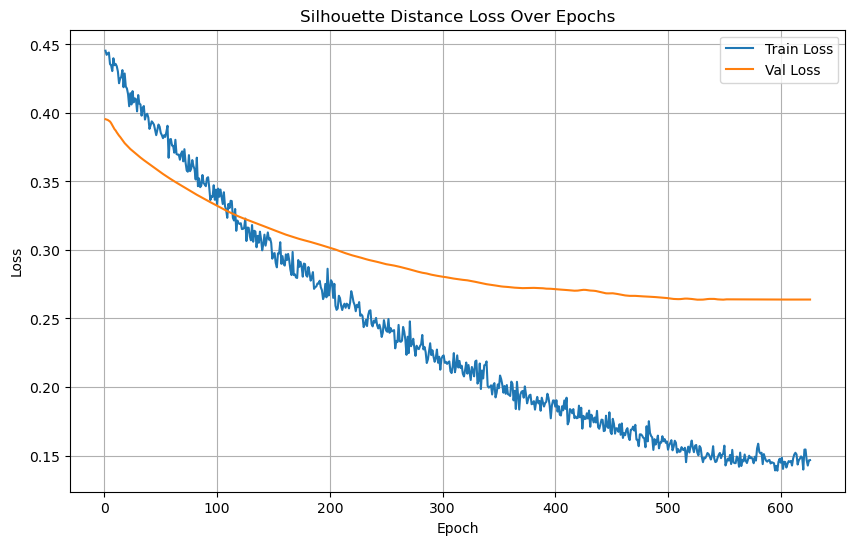

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/2313], Loss: 0.0942
Test Batch [20/2313], Loss: 0.1644
Test Batch [30/2313], Loss: 0.5000
Test Batch [40/2313], Loss: 0.1219
Test Batch [50/2313], Loss: 0.5000
Test Batch [60/2313], Loss: 0.5000


Test Batch [70/2313], Loss: 0.5000
Test Batch [80/2313], Loss: 0.1853
Test Batch [90/2313], Loss: 0.5000
Test Batch [100/2313], Loss: 0.0790
Test Batch [110/2313], Loss: 0.5000
Test Batch [120/2313], Loss: 0.1733
Test Batch [130/2313], Loss: 0.5000


Test Batch [140/2313], Loss: 0.5000
Test Batch [150/2313], Loss: 0.5000
Test Batch [160/2313], Loss: 0.1273
Test Batch [170/2313], Loss: 0.5000
Test Batch [180/2313], Loss: 0.5000
Test Batch [190/2313], Loss: 0.5000
Test Batch [200/2313], Loss: 0.1325


Test Batch [210/2313], Loss: 0.5000
Test Batch [220/2313], Loss: 0.5000
Test Batch [230/2313], Loss: 0.0748
Test Batch [240/2313], Loss: 0.0297
Test Batch [250/2313], Loss: 0.1523
Test Batch [260/2313], Loss: 0.5000
Test Batch [270/2313], Loss: 0.5000


Test Batch [280/2313], Loss: 0.5000
Test Batch [290/2313], Loss: 0.1261
Test Batch [300/2313], Loss: 0.1105
Test Batch [310/2313], Loss: 0.5000
Test Batch [320/2313], Loss: 0.1248
Test Batch [330/2313], Loss: 0.5000
Test Batch [340/2313], Loss: 0.5000


Test Batch [350/2313], Loss: 0.1006
Test Batch [360/2313], Loss: 0.1469
Test Batch [370/2313], Loss: 0.2134
Test Batch [380/2313], Loss: 0.1005
Test Batch [390/2313], Loss: 0.5000
Test Batch [400/2313], Loss: 0.5000
Test Batch [410/2313], Loss: 0.0408


Test Batch [420/2313], Loss: 0.0754
Test Batch [430/2313], Loss: 0.1539
Test Batch [440/2313], Loss: 0.5000
Test Batch [450/2313], Loss: 0.0835
Test Batch [460/2313], Loss: 0.5000
Test Batch [470/2313], Loss: 0.2019


Test Batch [480/2313], Loss: 0.5000
Test Batch [490/2313], Loss: 0.1051
Test Batch [500/2313], Loss: 0.0825
Test Batch [510/2313], Loss: 0.1254
Test Batch [520/2313], Loss: 0.0677
Test Batch [530/2313], Loss: 0.5000
Test Batch [540/2313], Loss: 0.0533


Test Batch [550/2313], Loss: 0.0755
Test Batch [560/2313], Loss: 0.5000
Test Batch [570/2313], Loss: 0.5000
Test Batch [580/2313], Loss: 0.1252
Test Batch [590/2313], Loss: 0.0642
Test Batch [600/2313], Loss: 0.5000


Test Batch [610/2313], Loss: 0.5000
Test Batch [620/2313], Loss: 0.1305
Test Batch [630/2313], Loss: 0.0210
Test Batch [640/2313], Loss: 0.1485
Test Batch [650/2313], Loss: 0.5000
Test Batch [660/2313], Loss: 0.0433


Test Batch [670/2313], Loss: 0.1205
Test Batch [680/2313], Loss: 0.5000
Test Batch [690/2313], Loss: 0.0903
Test Batch [700/2313], Loss: 0.1851
Test Batch [710/2313], Loss: 0.5000
Test Batch [720/2313], Loss: 0.5000
Test Batch [730/2313], Loss: 0.5000


Test Batch [740/2313], Loss: 0.5000
Test Batch [750/2313], Loss: 0.1578
Test Batch [760/2313], Loss: 0.0493
Test Batch [770/2313], Loss: 0.5000
Test Batch [780/2313], Loss: 0.0121


Test Batch [790/2313], Loss: 0.1080
Test Batch [800/2313], Loss: 0.1530
Test Batch [810/2313], Loss: 0.5000
Test Batch [820/2313], Loss: 0.1386
Test Batch [830/2313], Loss: 0.0319
Test Batch [840/2313], Loss: 0.0174


Test Batch [850/2313], Loss: 0.2168
Test Batch [860/2313], Loss: 0.5000
Test Batch [870/2313], Loss: 0.1578
Test Batch [880/2313], Loss: 0.0299
Test Batch [890/2313], Loss: 0.5000
Test Batch [900/2313], Loss: 0.5000
Test Batch [910/2313], Loss: 0.0185
Test Batch [920/2313], Loss: 0.5000
Test Batch [930/2313], Loss: 0.1520


Test Batch [940/2313], Loss: 0.1531
Test Batch [950/2313], Loss: 0.0168
Test Batch [960/2313], Loss: 0.5000
Test Batch [970/2313], Loss: 0.5000
Test Batch [980/2313], Loss: 0.0148
Test Batch [990/2313], Loss: 0.1217
Test Batch [1000/2313], Loss: 0.5000


Test Batch [1010/2313], Loss: 0.0438
Test Batch [1020/2313], Loss: 0.0908
Test Batch [1030/2313], Loss: 0.5000
Test Batch [1040/2313], Loss: 0.1276
Test Batch [1050/2313], Loss: 0.0560
Test Batch [1060/2313], Loss: 0.5000


Test Batch [1070/2313], Loss: 0.0344
Test Batch [1080/2313], Loss: 0.5000
Test Batch [1090/2313], Loss: 0.0739
Test Batch [1100/2313], Loss: 0.1560


Test Batch [1110/2313], Loss: 0.1844
Test Batch [1120/2313], Loss: 0.0431
Test Batch [1130/2313], Loss: 0.1081
Test Batch [1140/2313], Loss: 0.0708
Test Batch [1150/2313], Loss: 0.5000


Test Batch [1160/2313], Loss: 0.0748
Test Batch [1170/2313], Loss: 0.0610
Test Batch [1180/2313], Loss: 0.1675
Test Batch [1190/2313], Loss: 0.2373


Test Batch [1200/2313], Loss: 0.0968
Test Batch [1210/2313], Loss: 0.0865
Test Batch [1220/2313], Loss: 0.1290
Test Batch [1230/2313], Loss: 0.1378
Test Batch [1240/2313], Loss: 0.1188


Test Batch [1250/2313], Loss: 0.0158
Test Batch [1260/2313], Loss: 0.0583
Test Batch [1270/2313], Loss: 0.0806
Test Batch [1280/2313], Loss: 0.1689


Test Batch [1290/2313], Loss: 0.0819
Test Batch [1300/2313], Loss: 0.1547
Test Batch [1310/2313], Loss: 0.1511


Test Batch [1320/2313], Loss: 0.2225
Test Batch [1330/2313], Loss: 0.1414
Test Batch [1340/2313], Loss: 0.0504
Test Batch [1350/2313], Loss: 0.2313


Test Batch [1360/2313], Loss: 0.2584
Test Batch [1370/2313], Loss: 0.5000
Test Batch [1380/2313], Loss: 0.1528


Test Batch [1390/2313], Loss: 0.1819
Test Batch [1400/2313], Loss: 0.1828
Test Batch [1410/2313], Loss: 0.2243


Test Batch [1420/2313], Loss: 0.2383
Test Batch [1430/2313], Loss: 0.5000
Test Batch [1440/2313], Loss: 0.1319
Test Batch [1450/2313], Loss: 0.2011


Test Batch [1460/2313], Loss: 0.1596
Test Batch [1470/2313], Loss: 0.1484
Test Batch [1480/2313], Loss: 0.1766
Test Batch [1490/2313], Loss: 0.2375
Test Batch [1500/2313], Loss: 0.1637


Test Batch [1510/2313], Loss: 0.1181
Test Batch [1520/2313], Loss: 0.5000
Test Batch [1530/2313], Loss: 0.1770
Test Batch [1540/2313], Loss: 0.1577


Test Batch [1550/2313], Loss: 0.1394
Test Batch [1560/2313], Loss: 0.1196
Test Batch [1570/2313], Loss: 0.1349
Test Batch [1580/2313], Loss: 0.1403


Test Batch [1590/2313], Loss: 0.1809
Test Batch [1600/2313], Loss: 0.1491
Test Batch [1610/2313], Loss: 0.1431
Test Batch [1620/2313], Loss: 0.1661


Test Batch [1630/2313], Loss: 0.1669
Test Batch [1640/2313], Loss: 0.1722
Test Batch [1650/2313], Loss: 0.0516
Test Batch [1660/2313], Loss: 0.1733


Test Batch [1670/2313], Loss: 0.1390
Test Batch [1680/2313], Loss: 0.1907
Test Batch [1690/2313], Loss: 0.2215


Test Batch [1700/2313], Loss: 0.1105
Test Batch [1710/2313], Loss: 0.1146
Test Batch [1720/2313], Loss: 0.1421
Test Batch [1730/2313], Loss: 0.0597
Test Batch [1740/2313], Loss: 0.5000
Test Batch [1750/2313], Loss: 0.0742
Test Batch [1760/2313], Loss: 0.0766


Test Batch [1770/2313], Loss: 0.0683
Test Batch [1780/2313], Loss: 0.0851
Test Batch [1790/2313], Loss: 0.1021
Test Batch [1800/2313], Loss: 0.1197
Test Batch [1810/2313], Loss: 0.1108
Test Batch [1820/2313], Loss: 0.1978


Test Batch [1830/2313], Loss: 0.0324
Test Batch [1840/2313], Loss: 0.2360
Test Batch [1850/2313], Loss: 0.1390
Test Batch [1860/2313], Loss: 0.1593
Test Batch [1870/2313], Loss: 0.1526


Test Batch [1880/2313], Loss: 0.1503
Test Batch [1890/2313], Loss: 0.1479
Test Batch [1900/2313], Loss: 0.1767
Test Batch [1910/2313], Loss: 0.2201


Test Batch [1920/2313], Loss: 0.1824
Test Batch [1930/2313], Loss: 0.1485
Test Batch [1940/2313], Loss: 0.1660
Test Batch [1950/2313], Loss: 0.1375
Test Batch [1960/2313], Loss: 0.1667


Test Batch [1970/2313], Loss: 0.1436
Test Batch [1980/2313], Loss: 0.1715
Test Batch [1990/2313], Loss: 0.1212
Test Batch [2000/2313], Loss: 0.1333
Test Batch [2010/2313], Loss: 0.1163
Test Batch [2020/2313], Loss: 0.1799


Test Batch [2030/2313], Loss: 0.1304
Test Batch [2040/2313], Loss: 0.1102
Test Batch [2050/2313], Loss: 0.2105
Test Batch [2060/2313], Loss: 0.1361
Test Batch [2070/2313], Loss: 0.1158


Test Batch [2080/2313], Loss: 0.5000
Test Batch [2090/2313], Loss: 0.5000
Test Batch [2100/2313], Loss: 0.5000
Test Batch [2110/2313], Loss: 0.1349
Test Batch [2120/2313], Loss: 0.1680
Test Batch [2130/2313], Loss: 0.5000
Test Batch [2140/2313], Loss: 0.1296


Test Batch [2150/2313], Loss: 0.5000
Test Batch [2160/2313], Loss: 0.5000
Test Batch [2170/2313], Loss: 0.5000
Test Batch [2180/2313], Loss: 0.0120
Test Batch [2190/2313], Loss: 0.5000
Test Batch [2200/2313], Loss: 0.0651


Test Batch [2210/2313], Loss: 0.1491
Test Batch [2220/2313], Loss: 0.5000
Test Batch [2230/2313], Loss: 0.0324
Test Batch [2240/2313], Loss: 0.5000
Test Batch [2250/2313], Loss: 0.5000


Test Batch [2260/2313], Loss: 0.5000
Test Batch [2270/2313], Loss: 0.0991
Test Batch [2280/2313], Loss: 0.0196
Test Batch [2290/2313], Loss: 0.0486
Test Batch [2300/2313], Loss: 0.5000
Test Batch [2310/2313], Loss: 0.5000



Test Loss: 0.2349


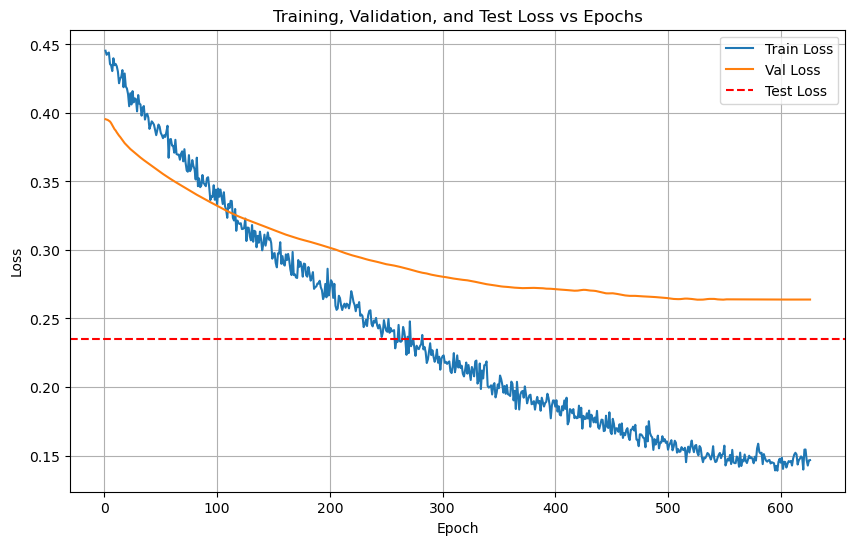

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/2313 for test dataset.


  Processed batch 20/2313 for test dataset.


  Processed batch 30/2313 for test dataset.
  Processed batch 40/2313 for test dataset.
  Processed batch 50/2313 for test dataset.


  Processed batch 60/2313 for test dataset.


  Processed batch 70/2313 for test dataset.
  Processed batch 80/2313 for test dataset.
  Processed batch 90/2313 for test dataset.


  Processed batch 100/2313 for test dataset.


  Processed batch 110/2313 for test dataset.
  Processed batch 120/2313 for test dataset.
  Processed batch 130/2313 for test dataset.


  Processed batch 140/2313 for test dataset.


  Processed batch 150/2313 for test dataset.
  Processed batch 160/2313 for test dataset.
  Processed batch 170/2313 for test dataset.


  Processed batch 180/2313 for test dataset.


  Processed batch 190/2313 for test dataset.
  Processed batch 200/2313 for test dataset.
  Processed batch 210/2313 for test dataset.


  Processed batch 220/2313 for test dataset.


  Processed batch 230/2313 for test dataset.
  Processed batch 240/2313 for test dataset.
  Processed batch 250/2313 for test dataset.


  Processed batch 260/2313 for test dataset.


  Processed batch 270/2313 for test dataset.
  Processed batch 280/2313 for test dataset.


  Processed batch 290/2313 for test dataset.
  Processed batch 300/2313 for test dataset.


  Processed batch 310/2313 for test dataset.
  Processed batch 320/2313 for test dataset.


  Processed batch 330/2313 for test dataset.


  Processed batch 340/2313 for test dataset.
  Processed batch 350/2313 for test dataset.
  Processed batch 360/2313 for test dataset.


  Processed batch 370/2313 for test dataset.


  Processed batch 380/2313 for test dataset.
  Processed batch 390/2313 for test dataset.
  Processed batch 400/2313 for test dataset.


  Processed batch 410/2313 for test dataset.


  Processed batch 420/2313 for test dataset.
  Processed batch 430/2313 for test dataset.
  Processed batch 440/2313 for test dataset.


  Processed batch 450/2313 for test dataset.


  Processed batch 460/2313 for test dataset.
  Processed batch 470/2313 for test dataset.
  Processed batch 480/2313 for test dataset.


  Processed batch 490/2313 for test dataset.


  Processed batch 500/2313 for test dataset.
  Processed batch 510/2313 for test dataset.
  Processed batch 520/2313 for test dataset.


  Processed batch 530/2313 for test dataset.


  Processed batch 540/2313 for test dataset.
  Processed batch 550/2313 for test dataset.
  Processed batch 560/2313 for test dataset.


  Processed batch 570/2313 for test dataset.
  Processed batch 580/2313 for test dataset.
  Processed batch 590/2313 for test dataset.
  Processed batch 600/2313 for test dataset.


  Processed batch 610/2313 for test dataset.
  Processed batch 620/2313 for test dataset.
  Processed batch 630/2313 for test dataset.
  Processed batch 640/2313 for test dataset.


  Processed batch 650/2313 for test dataset.
  Processed batch 660/2313 for test dataset.
  Processed batch 670/2313 for test dataset.
  Processed batch 680/2313 for test dataset.


  Processed batch 690/2313 for test dataset.
  Processed batch 700/2313 for test dataset.
  Processed batch 710/2313 for test dataset.
  Processed batch 720/2313 for test dataset.


  Processed batch 730/2313 for test dataset.
  Processed batch 740/2313 for test dataset.
  Processed batch 750/2313 for test dataset.
  Processed batch 760/2313 for test dataset.


  Processed batch 770/2313 for test dataset.
  Processed batch 780/2313 for test dataset.
  Processed batch 790/2313 for test dataset.
  Processed batch 800/2313 for test dataset.


  Processed batch 810/2313 for test dataset.
  Processed batch 820/2313 for test dataset.
  Processed batch 830/2313 for test dataset.
  Processed batch 840/2313 for test dataset.


  Processed batch 850/2313 for test dataset.
  Processed batch 860/2313 for test dataset.
  Processed batch 870/2313 for test dataset.
  Processed batch 880/2313 for test dataset.


  Processed batch 890/2313 for test dataset.
  Processed batch 900/2313 for test dataset.
  Processed batch 910/2313 for test dataset.
  Processed batch 920/2313 for test dataset.


  Processed batch 930/2313 for test dataset.
  Processed batch 940/2313 for test dataset.
  Processed batch 950/2313 for test dataset.
  Processed batch 960/2313 for test dataset.


  Processed batch 970/2313 for test dataset.
  Processed batch 980/2313 for test dataset.
  Processed batch 990/2313 for test dataset.
  Processed batch 1000/2313 for test dataset.


  Processed batch 1010/2313 for test dataset.
  Processed batch 1020/2313 for test dataset.
  Processed batch 1030/2313 for test dataset.
  Processed batch 1040/2313 for test dataset.


  Processed batch 1050/2313 for test dataset.
  Processed batch 1060/2313 for test dataset.
  Processed batch 1070/2313 for test dataset.
  Processed batch 1080/2313 for test dataset.


  Processed batch 1090/2313 for test dataset.
  Processed batch 1100/2313 for test dataset.
  Processed batch 1110/2313 for test dataset.
  Processed batch 1120/2313 for test dataset.


  Processed batch 1130/2313 for test dataset.
  Processed batch 1140/2313 for test dataset.
  Processed batch 1150/2313 for test dataset.
  Processed batch 1160/2313 for test dataset.


  Processed batch 1170/2313 for test dataset.
  Processed batch 1180/2313 for test dataset.
  Processed batch 1190/2313 for test dataset.
  Processed batch 1200/2313 for test dataset.


  Processed batch 1210/2313 for test dataset.
  Processed batch 1220/2313 for test dataset.
  Processed batch 1230/2313 for test dataset.
  Processed batch 1240/2313 for test dataset.


  Processed batch 1250/2313 for test dataset.
  Processed batch 1260/2313 for test dataset.
  Processed batch 1270/2313 for test dataset.
  Processed batch 1280/2313 for test dataset.


  Processed batch 1290/2313 for test dataset.
  Processed batch 1300/2313 for test dataset.
  Processed batch 1310/2313 for test dataset.
  Processed batch 1320/2313 for test dataset.


  Processed batch 1330/2313 for test dataset.
  Processed batch 1340/2313 for test dataset.
  Processed batch 1350/2313 for test dataset.
  Processed batch 1360/2313 for test dataset.


  Processed batch 1370/2313 for test dataset.
  Processed batch 1380/2313 for test dataset.
  Processed batch 1390/2313 for test dataset.


  Processed batch 1400/2313 for test dataset.
  Processed batch 1410/2313 for test dataset.
  Processed batch 1420/2313 for test dataset.
  Processed batch 1430/2313 for test dataset.


  Processed batch 1440/2313 for test dataset.
  Processed batch 1450/2313 for test dataset.
  Processed batch 1460/2313 for test dataset.
  Processed batch 1470/2313 for test dataset.


  Processed batch 1480/2313 for test dataset.
  Processed batch 1490/2313 for test dataset.
  Processed batch 1500/2313 for test dataset.
  Processed batch 1510/2313 for test dataset.


  Processed batch 1520/2313 for test dataset.
  Processed batch 1530/2313 for test dataset.
  Processed batch 1540/2313 for test dataset.
  Processed batch 1550/2313 for test dataset.


  Processed batch 1560/2313 for test dataset.
  Processed batch 1570/2313 for test dataset.
  Processed batch 1580/2313 for test dataset.
  Processed batch 1590/2313 for test dataset.


  Processed batch 1600/2313 for test dataset.
  Processed batch 1610/2313 for test dataset.
  Processed batch 1620/2313 for test dataset.
  Processed batch 1630/2313 for test dataset.


  Processed batch 1640/2313 for test dataset.
  Processed batch 1650/2313 for test dataset.
  Processed batch 1660/2313 for test dataset.
  Processed batch 1670/2313 for test dataset.


  Processed batch 1680/2313 for test dataset.
  Processed batch 1690/2313 for test dataset.
  Processed batch 1700/2313 for test dataset.
  Processed batch 1710/2313 for test dataset.


  Processed batch 1720/2313 for test dataset.
  Processed batch 1730/2313 for test dataset.
  Processed batch 1740/2313 for test dataset.


  Processed batch 1750/2313 for test dataset.
  Processed batch 1760/2313 for test dataset.
  Processed batch 1770/2313 for test dataset.
  Processed batch 1780/2313 for test dataset.


  Processed batch 1790/2313 for test dataset.
  Processed batch 1800/2313 for test dataset.
  Processed batch 1810/2313 for test dataset.
  Processed batch 1820/2313 for test dataset.


  Processed batch 1830/2313 for test dataset.
  Processed batch 1840/2313 for test dataset.
  Processed batch 1850/2313 for test dataset.
  Processed batch 1860/2313 for test dataset.


  Processed batch 1870/2313 for test dataset.
  Processed batch 1880/2313 for test dataset.
  Processed batch 1890/2313 for test dataset.
  Processed batch 1900/2313 for test dataset.


  Processed batch 1910/2313 for test dataset.
  Processed batch 1920/2313 for test dataset.
  Processed batch 1930/2313 for test dataset.


  Processed batch 1940/2313 for test dataset.
  Processed batch 1950/2313 for test dataset.
  Processed batch 1960/2313 for test dataset.
  Processed batch 1970/2313 for test dataset.


  Processed batch 1980/2313 for test dataset.
  Processed batch 1990/2313 for test dataset.
  Processed batch 2000/2313 for test dataset.
  Processed batch 2010/2313 for test dataset.


  Processed batch 2020/2313 for test dataset.
  Processed batch 2030/2313 for test dataset.
  Processed batch 2040/2313 for test dataset.
  Processed batch 2050/2313 for test dataset.


  Processed batch 2060/2313 for test dataset.
  Processed batch 2070/2313 for test dataset.
  Processed batch 2080/2313 for test dataset.
  Processed batch 2090/2313 for test dataset.


  Processed batch 2100/2313 for test dataset.
  Processed batch 2110/2313 for test dataset.
  Processed batch 2120/2313 for test dataset.
  Processed batch 2130/2313 for test dataset.


  Processed batch 2140/2313 for test dataset.
  Processed batch 2150/2313 for test dataset.
  Processed batch 2160/2313 for test dataset.
  Processed batch 2170/2313 for test dataset.


  Processed batch 2180/2313 for test dataset.
  Processed batch 2190/2313 for test dataset.
  Processed batch 2200/2313 for test dataset.
  Processed batch 2210/2313 for test dataset.


  Processed batch 2220/2313 for test dataset.
  Processed batch 2230/2313 for test dataset.
  Processed batch 2240/2313 for test dataset.
  Processed batch 2250/2313 for test dataset.


  Processed batch 2260/2313 for test dataset.
  Processed batch 2270/2313 for test dataset.
  Processed batch 2280/2313 for test dataset.


  Processed batch 2290/2313 for test dataset.
  Processed batch 2300/2313 for test dataset.
  Processed batch 2310/2313 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148017, 128)
Test labels shape: (148017,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 86.67%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       1.00      1.00      1.00         5
           2       1.00      0.80      0.89         5
           3       0.80      0.80      0.80         5
           4       0.80      0.80      0.80         5
           5       0.60      0.60      0.60         5
           6       0.71      1.00      0.83         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5

    accuracy                           0.87        45
   macro avg       0.88      0.87      0.87        45
weighted avg       0.88      0.87      0.87        45


LOG: Evaluating on the test set...
Test Accuracy: 90.89%



Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     65956
           1       0.98      0.86      0.92      7583
           2       0.68      0.89      0.77      3075
           3       0.61      0.82      0.70      2670
           4       0.46      0.85      0.59      6569
           5       0.75      0.89      0.81      9233
           6       0.85      0.86      0.86      7272
           7       1.00      0.83      0.91     42811
           8       1.00      0.99      0.99      2848

    accuracy                           0.91    148017
   macro avg       0.81      0.89      0.84    148017
weighted avg       0.94      0.91      0.92    148017

Saved SCL_SDL+LRM predictions and true labels to model_predictions


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148017, 128)
Test labels shape: (148017,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.3248  |  Val Loss: 2.2945
Validation loss improved from inf to 2.2945.
[Epoch 2/1000] Train Loss: 2.2919  |  Val Loss: 2.2684
Validation loss improved from 2.2945 to 2.2684.
[Epoch 3/1000] Train Loss: 2.2601  |  Val Loss: 2.2428
Validation loss improved from 2.2684 to 2.2428.
[Epoch 4/1000] Train Loss: 2.2287  |  Val Loss: 2.2178
Validation loss improved from 2.2428 to 2.2178.
[Epoch 5/1000] Train Loss: 2.1975  |  Val Loss: 2.1935
Validation loss improved from 2.2178 to 2.1935.
[Epoch 6/1000] Train Loss: 2.1681  |  Val Loss: 2.1697
Validation loss improved from 2.1935 to 2.1697.
[Epoch 7/1000] Train Loss: 2.1377  |  Val Loss: 2.1473
Validation loss improved from 2.1697 to 2.1473.
[Epoch 8/1000] Train Loss: 2.1105  |  Val Loss: 2.1261
Validation loss improved from 2.1473 to 2.1261.
[Epoch 9/1000] Train Loss: 2.0818  |  Val Loss: 2.1053
Validation loss improved from 2.1261 to 2.1053.
[Epoch 10/1000] Train Loss: 2.0565  |  Val Loss: 2.0856
Validation loss impr

[Epoch 33/1000] Train Loss: 1.5975  |  Val Loss: 1.7190
Validation loss improved from 1.7330 to 1.7190.
[Epoch 34/1000] Train Loss: 1.5804  |  Val Loss: 1.7051
Validation loss improved from 1.7190 to 1.7051.
[Epoch 35/1000] Train Loss: 1.5625  |  Val Loss: 1.6910
Validation loss improved from 1.7051 to 1.6910.
[Epoch 36/1000] Train Loss: 1.5452  |  Val Loss: 1.6766
Validation loss improved from 1.6910 to 1.6766.
[Epoch 37/1000] Train Loss: 1.5277  |  Val Loss: 1.6619
Validation loss improved from 1.6766 to 1.6619.
[Epoch 38/1000] Train Loss: 1.5105  |  Val Loss: 1.6473
Validation loss improved from 1.6619 to 1.6473.
[Epoch 39/1000] Train Loss: 1.4928  |  Val Loss: 1.6328
Validation loss improved from 1.6473 to 1.6328.
[Epoch 40/1000] Train Loss: 1.4749  |  Val Loss: 1.6184
Validation loss improved from 1.6328 to 1.6184.
[Epoch 41/1000] Train Loss: 1.4573  |  Val Loss: 1.6039
Validation loss improved from 1.6184 to 1.6039.
[Epoch 42/1000] Train Loss: 1.4396  |  Val Loss: 1.5895
Validati

[Epoch 47/1000] Train Loss: 1.3502  |  Val Loss: 1.5194
Validation loss improved from 1.5331 to 1.5194.
[Epoch 48/1000] Train Loss: 1.3325  |  Val Loss: 1.5057
Validation loss improved from 1.5194 to 1.5057.
[Epoch 49/1000] Train Loss: 1.3149  |  Val Loss: 1.4919
Validation loss improved from 1.5057 to 1.4919.
[Epoch 50/1000] Train Loss: 1.2972  |  Val Loss: 1.4780
Validation loss improved from 1.4919 to 1.4780.
[Epoch 51/1000] Train Loss: 1.2795  |  Val Loss: 1.4643
Validation loss improved from 1.4780 to 1.4643.
[Epoch 52/1000] Train Loss: 1.2619  |  Val Loss: 1.4507
Validation loss improved from 1.4643 to 1.4507.
[Epoch 53/1000] Train Loss: 1.2445  |  Val Loss: 1.4372
Validation loss improved from 1.4507 to 1.4372.
[Epoch 54/1000] Train Loss: 1.2273  |  Val Loss: 1.4240
Validation loss improved from 1.4372 to 1.4240.
[Epoch 55/1000] Train Loss: 1.2099  |  Val Loss: 1.4107
Validation loss improved from 1.4240 to 1.4107.
[Epoch 56/1000] Train Loss: 1.1932  |  Val Loss: 1.3976
Validati

[Epoch 77/1000] Train Loss: 0.8696  |  Val Loss: 1.1387
Validation loss improved from 1.1501 to 1.1387.
[Epoch 78/1000] Train Loss: 0.8554  |  Val Loss: 1.1275
Validation loss improved from 1.1387 to 1.1275.
[Epoch 79/1000] Train Loss: 0.8412  |  Val Loss: 1.1165
Validation loss improved from 1.1275 to 1.1165.
[Epoch 80/1000] Train Loss: 0.8274  |  Val Loss: 1.1054
Validation loss improved from 1.1165 to 1.1054.
[Epoch 81/1000] Train Loss: 0.8136  |  Val Loss: 1.0943
Validation loss improved from 1.1054 to 1.0943.
[Epoch 82/1000] Train Loss: 0.7998  |  Val Loss: 1.0832
Validation loss improved from 1.0943 to 1.0832.
[Epoch 83/1000] Train Loss: 0.7863  |  Val Loss: 1.0722
Validation loss improved from 1.0832 to 1.0722.
[Epoch 84/1000] Train Loss: 0.7724  |  Val Loss: 1.0612
Validation loss improved from 1.0722 to 1.0612.
[Epoch 85/1000] Train Loss: 0.7588  |  Val Loss: 1.0502
Validation loss improved from 1.0612 to 1.0502.
[Epoch 86/1000] Train Loss: 0.7455  |  Val Loss: 1.0392
Validati

[Epoch 88/1000] Train Loss: 0.7188  |  Val Loss: 1.0173
Validation loss improved from 1.0282 to 1.0173.
[Epoch 89/1000] Train Loss: 0.7057  |  Val Loss: 1.0065
Validation loss improved from 1.0173 to 1.0065.
[Epoch 90/1000] Train Loss: 0.6928  |  Val Loss: 0.9955
Validation loss improved from 1.0065 to 0.9955.
[Epoch 91/1000] Train Loss: 0.6798  |  Val Loss: 0.9844
Validation loss improved from 0.9955 to 0.9844.
[Epoch 92/1000] Train Loss: 0.6670  |  Val Loss: 0.9733
Validation loss improved from 0.9844 to 0.9733.
[Epoch 93/1000] Train Loss: 0.6545  |  Val Loss: 0.9623
Validation loss improved from 0.9733 to 0.9623.
[Epoch 94/1000] Train Loss: 0.6416  |  Val Loss: 0.9516
Validation loss improved from 0.9623 to 0.9516.
[Epoch 95/1000] Train Loss: 0.6291  |  Val Loss: 0.9410
Validation loss improved from 0.9516 to 0.9410.
[Epoch 96/1000] Train Loss: 0.6170  |  Val Loss: 0.9306
Validation loss improved from 0.9410 to 0.9306.
[Epoch 97/1000] Train Loss: 0.6047  |  Val Loss: 0.9203
Validati

[Epoch 117/1000] Train Loss: 0.4027  |  Val Loss: 0.7438
Validation loss improved from 0.7515 to 0.7438.
[Epoch 118/1000] Train Loss: 0.3944  |  Val Loss: 0.7362
Validation loss improved from 0.7438 to 0.7362.
[Epoch 119/1000] Train Loss: 0.3864  |  Val Loss: 0.7287
Validation loss improved from 0.7362 to 0.7287.
[Epoch 120/1000] Train Loss: 0.3782  |  Val Loss: 0.7214
Validation loss improved from 0.7287 to 0.7214.
[Epoch 121/1000] Train Loss: 0.3703  |  Val Loss: 0.7142
Validation loss improved from 0.7214 to 0.7142.
[Epoch 122/1000] Train Loss: 0.3627  |  Val Loss: 0.7072
Validation loss improved from 0.7142 to 0.7072.
[Epoch 123/1000] Train Loss: 0.3552  |  Val Loss: 0.7004
Validation loss improved from 0.7072 to 0.7004.
[Epoch 124/1000] Train Loss: 0.3479  |  Val Loss: 0.6938
Validation loss improved from 0.7004 to 0.6938.
[Epoch 125/1000] Train Loss: 0.3407  |  Val Loss: 0.6875
Validation loss improved from 0.6938 to 0.6875.
[Epoch 126/1000] Train Loss: 0.3336  |  Val Loss: 0.681

[Epoch 130/1000] Train Loss: 0.3072  |  Val Loss: 0.6571
Validation loss improved from 0.6631 to 0.6571.
[Epoch 131/1000] Train Loss: 0.3008  |  Val Loss: 0.6513
Validation loss improved from 0.6571 to 0.6513.
[Epoch 132/1000] Train Loss: 0.2948  |  Val Loss: 0.6455
Validation loss improved from 0.6513 to 0.6455.
[Epoch 133/1000] Train Loss: 0.2889  |  Val Loss: 0.6399
Validation loss improved from 0.6455 to 0.6399.
[Epoch 134/1000] Train Loss: 0.2829  |  Val Loss: 0.6344
Validation loss improved from 0.6399 to 0.6344.
[Epoch 135/1000] Train Loss: 0.2773  |  Val Loss: 0.6289
Validation loss improved from 0.6344 to 0.6289.
[Epoch 136/1000] Train Loss: 0.2718  |  Val Loss: 0.6237
Validation loss improved from 0.6289 to 0.6237.
[Epoch 137/1000] Train Loss: 0.2662  |  Val Loss: 0.6185
Validation loss improved from 0.6237 to 0.6185.
[Epoch 138/1000] Train Loss: 0.2609  |  Val Loss: 0.6136
Validation loss improved from 0.6185 to 0.6136.
[Epoch 139/1000] Train Loss: 0.2556  |  Val Loss: 0.608

[Epoch 157/1000] Train Loss: 0.1799  |  Val Loss: 0.5356
Validation loss improved from 0.5389 to 0.5356.
[Epoch 158/1000] Train Loss: 0.1765  |  Val Loss: 0.5325
Validation loss improved from 0.5356 to 0.5325.
[Epoch 159/1000] Train Loss: 0.1733  |  Val Loss: 0.5294
Validation loss improved from 0.5325 to 0.5294.
[Epoch 160/1000] Train Loss: 0.1701  |  Val Loss: 0.5264
Validation loss improved from 0.5294 to 0.5264.
[Epoch 161/1000] Train Loss: 0.1671  |  Val Loss: 0.5235
Validation loss improved from 0.5264 to 0.5235.
[Epoch 162/1000] Train Loss: 0.1641  |  Val Loss: 0.5207
Validation loss improved from 0.5235 to 0.5207.
[Epoch 163/1000] Train Loss: 0.1611  |  Val Loss: 0.5179
Validation loss improved from 0.5207 to 0.5179.
[Epoch 164/1000] Train Loss: 0.1582  |  Val Loss: 0.5152
Validation loss improved from 0.5179 to 0.5152.
[Epoch 165/1000] Train Loss: 0.1554  |  Val Loss: 0.5125
Validation loss improved from 0.5152 to 0.5125.
[Epoch 166/1000] Train Loss: 0.1527  |  Val Loss: 0.509

[Epoch 172/1000] Train Loss: 0.1376  |  Val Loss: 0.4948
Validation loss improved from 0.4972 to 0.4948.
[Epoch 173/1000] Train Loss: 0.1353  |  Val Loss: 0.4926
Validation loss improved from 0.4948 to 0.4926.
[Epoch 174/1000] Train Loss: 0.1330  |  Val Loss: 0.4904
Validation loss improved from 0.4926 to 0.4904.
[Epoch 175/1000] Train Loss: 0.1308  |  Val Loss: 0.4882
Validation loss improved from 0.4904 to 0.4882.
[Epoch 176/1000] Train Loss: 0.1287  |  Val Loss: 0.4861
Validation loss improved from 0.4882 to 0.4861.
[Epoch 177/1000] Train Loss: 0.1266  |  Val Loss: 0.4840
Validation loss improved from 0.4861 to 0.4840.
[Epoch 178/1000] Train Loss: 0.1245  |  Val Loss: 0.4820
Validation loss improved from 0.4840 to 0.4820.
[Epoch 179/1000] Train Loss: 0.1225  |  Val Loss: 0.4800
Validation loss improved from 0.4820 to 0.4800.
[Epoch 180/1000] Train Loss: 0.1206  |  Val Loss: 0.4781
Validation loss improved from 0.4800 to 0.4781.
[Epoch 181/1000] Train Loss: 0.1186  |  Val Loss: 0.476

[Epoch 201/1000] Train Loss: 0.0878  |  Val Loss: 0.4464
Validation loss improved from 0.4477 to 0.4464.
[Epoch 202/1000] Train Loss: 0.0865  |  Val Loss: 0.4452
Validation loss improved from 0.4464 to 0.4452.
[Epoch 203/1000] Train Loss: 0.0854  |  Val Loss: 0.4440
Validation loss improved from 0.4452 to 0.4440.
[Epoch 204/1000] Train Loss: 0.0842  |  Val Loss: 0.4430
Validation loss improved from 0.4440 to 0.4430.
[Epoch 205/1000] Train Loss: 0.0830  |  Val Loss: 0.4419
Validation loss improved from 0.4430 to 0.4419.
[Epoch 206/1000] Train Loss: 0.0819  |  Val Loss: 0.4408
Validation loss improved from 0.4419 to 0.4408.
[Epoch 207/1000] Train Loss: 0.0808  |  Val Loss: 0.4397
Validation loss improved from 0.4408 to 0.4397.
[Epoch 208/1000] Train Loss: 0.0797  |  Val Loss: 0.4386
Validation loss improved from 0.4397 to 0.4386.
[Epoch 209/1000] Train Loss: 0.0786  |  Val Loss: 0.4375
Validation loss improved from 0.4386 to 0.4375.
[Epoch 210/1000] Train Loss: 0.0776  |  Val Loss: 0.436

[Epoch 215/1000] Train Loss: 0.0726  |  Val Loss: 0.4314
Validation loss improved from 0.4323 to 0.4314.
[Epoch 216/1000] Train Loss: 0.0717  |  Val Loss: 0.4305
Validation loss improved from 0.4314 to 0.4305.
[Epoch 217/1000] Train Loss: 0.0708  |  Val Loss: 0.4297
Validation loss improved from 0.4305 to 0.4297.
[Epoch 218/1000] Train Loss: 0.0699  |  Val Loss: 0.4288
Validation loss improved from 0.4297 to 0.4288.
[Epoch 219/1000] Train Loss: 0.0690  |  Val Loss: 0.4280
Validation loss improved from 0.4288 to 0.4280.
[Epoch 220/1000] Train Loss: 0.0682  |  Val Loss: 0.4273
Validation loss improved from 0.4280 to 0.4273.
[Epoch 221/1000] Train Loss: 0.0673  |  Val Loss: 0.4265
Validation loss improved from 0.4273 to 0.4265.
[Epoch 222/1000] Train Loss: 0.0665  |  Val Loss: 0.4259
Validation loss improved from 0.4265 to 0.4259.
[Epoch 223/1000] Train Loss: 0.0657  |  Val Loss: 0.4252
Validation loss improved from 0.4259 to 0.4252.
[Epoch 224/1000] Train Loss: 0.0649  |  Val Loss: 0.424

[Epoch 245/1000] Train Loss: 0.0507  |  Val Loss: 0.4118
Validation loss improved from 0.4123 to 0.4118.
[Epoch 246/1000] Train Loss: 0.0502  |  Val Loss: 0.4114
Validation loss improved from 0.4118 to 0.4114.
[Epoch 247/1000] Train Loss: 0.0497  |  Val Loss: 0.4109
Validation loss improved from 0.4114 to 0.4109.
[Epoch 248/1000] Train Loss: 0.0491  |  Val Loss: 0.4105
Validation loss improved from 0.4109 to 0.4105.
[Epoch 249/1000] Train Loss: 0.0486  |  Val Loss: 0.4101
Validation loss improved from 0.4105 to 0.4101.
[Epoch 250/1000] Train Loss: 0.0481  |  Val Loss: 0.4097
Validation loss improved from 0.4101 to 0.4097.
[Epoch 251/1000] Train Loss: 0.0476  |  Val Loss: 0.4093
Validation loss improved from 0.4097 to 0.4093.
[Epoch 252/1000] Train Loss: 0.0471  |  Val Loss: 0.4090
Validation loss improved from 0.4093 to 0.4090.
[Epoch 253/1000] Train Loss: 0.0466  |  Val Loss: 0.4087
Validation loss improved from 0.4090 to 0.4087.
[Epoch 254/1000] Train Loss: 0.0461  |  Val Loss: 0.408

[Epoch 257/1000] Train Loss: 0.0447  |  Val Loss: 0.4075
Validation loss improved from 0.4078 to 0.4075.
[Epoch 258/1000] Train Loss: 0.0442  |  Val Loss: 0.4071
Validation loss improved from 0.4075 to 0.4071.
[Epoch 259/1000] Train Loss: 0.0437  |  Val Loss: 0.4068
Validation loss improved from 0.4071 to 0.4068.
[Epoch 260/1000] Train Loss: 0.0433  |  Val Loss: 0.4065
Validation loss improved from 0.4068 to 0.4065.
[Epoch 261/1000] Train Loss: 0.0429  |  Val Loss: 0.4063
Validation loss improved from 0.4065 to 0.4063.
[Epoch 262/1000] Train Loss: 0.0424  |  Val Loss: 0.4060
Validation loss improved from 0.4063 to 0.4060.
[Epoch 263/1000] Train Loss: 0.0420  |  Val Loss: 0.4058
Validation loss improved from 0.4060 to 0.4058.
[Epoch 264/1000] Train Loss: 0.0416  |  Val Loss: 0.4056
Validation loss improved from 0.4058 to 0.4056.
[Epoch 265/1000] Train Loss: 0.0411  |  Val Loss: 0.4053
Validation loss improved from 0.4056 to 0.4053.
[Epoch 266/1000] Train Loss: 0.0408  |  Val Loss: 0.405

[Epoch 292/1000] Train Loss: 0.0319  |  Val Loss: 0.3995
Validation loss improved from 0.3996 to 0.3995.
[Epoch 293/1000] Train Loss: 0.0316  |  Val Loss: 0.3993
Validation loss improved from 0.3995 to 0.3993.
[Epoch 294/1000] Train Loss: 0.0313  |  Val Loss: 0.3992
Validation loss improved from 0.3993 to 0.3992.
[Epoch 295/1000] Train Loss: 0.0310  |  Val Loss: 0.3990
Validation loss improved from 0.3992 to 0.3990.
[Epoch 296/1000] Train Loss: 0.0308  |  Val Loss: 0.3989
Validation loss improved from 0.3990 to 0.3989.
[Epoch 297/1000] Train Loss: 0.0305  |  Val Loss: 0.3987
Validation loss improved from 0.3989 to 0.3987.
[Epoch 298/1000] Train Loss: 0.0302  |  Val Loss: 0.3986
Validation loss improved from 0.3987 to 0.3986.
[Epoch 299/1000] Train Loss: 0.0300  |  Val Loss: 0.3986
Validation loss improved from 0.3986 to 0.3986.
[Epoch 300/1000] Train Loss: 0.0297  |  Val Loss: 0.3985
Validation loss improved from 0.3986 to 0.3985.


[Epoch 301/1000] Train Loss: 0.0295  |  Val Loss: 0.3984
Validation loss improved from 0.3985 to 0.3984.
[Epoch 302/1000] Train Loss: 0.0292  |  Val Loss: 0.3983
Validation loss improved from 0.3984 to 0.3983.
[Epoch 303/1000] Train Loss: 0.0290  |  Val Loss: 0.3982
Validation loss improved from 0.3983 to 0.3982.
[Epoch 304/1000] Train Loss: 0.0288  |  Val Loss: 0.3980
Validation loss improved from 0.3982 to 0.3980.
[Epoch 305/1000] Train Loss: 0.0285  |  Val Loss: 0.3979
Validation loss improved from 0.3980 to 0.3979.
[Epoch 306/1000] Train Loss: 0.0283  |  Val Loss: 0.3978
Validation loss improved from 0.3979 to 0.3978.
[Epoch 307/1000] Train Loss: 0.0281  |  Val Loss: 0.3976
Validation loss improved from 0.3978 to 0.3976.
[Epoch 308/1000] Train Loss: 0.0278  |  Val Loss: 0.3975
Validation loss improved from 0.3976 to 0.3975.
[Epoch 309/1000] Train Loss: 0.0276  |  Val Loss: 0.3974
Validation loss improved from 0.3975 to 0.3974.
[Epoch 310/1000] Train Loss: 0.0274  |  Val Loss: 0.397

[Epoch 332/1000] Train Loss: 0.0230  |  Val Loss: 0.3958
Validation loss improved from 0.3958 to 0.3958.
[Epoch 333/1000] Train Loss: 0.0229  |  Val Loss: 0.3957
Validation loss improved from 0.3958 to 0.3957.
[Epoch 334/1000] Train Loss: 0.0227  |  Val Loss: 0.3956
Validation loss improved from 0.3957 to 0.3956.
[Epoch 335/1000] Train Loss: 0.0225  |  Val Loss: 0.3956
Validation loss improved from 0.3956 to 0.3956.
[Epoch 336/1000] Train Loss: 0.0224  |  Val Loss: 0.3954
Validation loss improved from 0.3956 to 0.3954.
[Epoch 337/1000] Train Loss: 0.0222  |  Val Loss: 0.3954
Validation loss improved from 0.3954 to 0.3954.
[Epoch 338/1000] Train Loss: 0.0220  |  Val Loss: 0.3954
Validation loss improved from 0.3954 to 0.3954.
[Epoch 339/1000] Train Loss: 0.0219  |  Val Loss: 0.3953
Validation loss improved from 0.3954 to 0.3953.
[Epoch 340/1000] Train Loss: 0.0217  |  Val Loss: 0.3953
Validation loss improved from 0.3953 to 0.3953.
[Epoch 341/1000] Train Loss: 0.0216  |  Val Loss: 0.395

[Epoch 342/1000] Train Loss: 0.0214  |  Val Loss: 0.3952
Validation loss improved from 0.3953 to 0.3952.
[Epoch 343/1000] Train Loss: 0.0213  |  Val Loss: 0.3952
Validation loss improved from 0.3952 to 0.3952.
[Epoch 344/1000] Train Loss: 0.0211  |  Val Loss: 0.3952
Validation loss improved from 0.3952 to 0.3952.
[Epoch 345/1000] Train Loss: 0.0210  |  Val Loss: 0.3951
Validation loss improved from 0.3952 to 0.3951.
[Epoch 346/1000] Train Loss: 0.0208  |  Val Loss: 0.3951
Validation loss improved from 0.3951 to 0.3951.
[Epoch 347/1000] Train Loss: 0.0207  |  Val Loss: 0.3950
Validation loss improved from 0.3951 to 0.3950.
[Epoch 348/1000] Train Loss: 0.0205  |  Val Loss: 0.3950
Validation loss improved from 0.3950 to 0.3950.
[Epoch 349/1000] Train Loss: 0.0204  |  Val Loss: 0.3950
Validation loss improved from 0.3950 to 0.3950.
[Epoch 350/1000] Train Loss: 0.0202  |  Val Loss: 0.3950
Validation loss improved from 0.3950 to 0.3950.
[Epoch 351/1000] Train Loss: 0.0201  |  Val Loss: 0.395

[Epoch 369/1000] Train Loss: 0.0177  |  Val Loss: 0.3954
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 370/1000] Train Loss: 0.0176  |  Val Loss: 0.3955
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 371/1000] Train Loss: 0.0175  |  Val Loss: 0.3955
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 372/1000] Train Loss: 0.0174  |  Val Loss: 0.3956
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 373/1000] Train Loss: 0.0173  |  Val Loss: 0.3956
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 374/1000] Train Loss: 0.0172  |  Val Loss: 0.3956
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 375/1000] Train Loss: 0.0170  |  Val Loss: 0.3957
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 376/1000] Train Loss: 0.0169  |  Val Loss: 0.3957
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 377/1000] Train Loss: 0.0168  |  Val Loss: 0.3957
!! Validation loss did NOT improve !! Patience:

[Epoch 383/1000] Train Loss: 0.0162  |  Val Loss: 0.3961
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 384/1000] Train Loss: 0.0161  |  Val Loss: 0.3961
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 385/1000] Train Loss: 0.0160  |  Val Loss: 0.3962
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 386/1000] Train Loss: 0.0159  |  Val Loss: 0.3962
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 387/1000] Train Loss: 0.0158  |  Val Loss: 0.3963
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 388/1000] Train Loss: 0.0157  |  Val Loss: 0.3963
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 389/1000] Train Loss: 0.0156  |  Val Loss: 0.3964
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 390/1000] Train Loss: 0.0155  |  Val Loss: 0.3964
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 391/1000] Train Loss: 0.0154  |  Val Loss: 0.3965
!! Validation loss did NOT improve !! Patience:

[Epoch 409/1000] Train Loss: 0.0138  |  Val Loss: 0.3972
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 410/1000] Train Loss: 0.0137  |  Val Loss: 0.3973
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 411/1000] Train Loss: 0.0136  |  Val Loss: 0.3973
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 412/1000] Train Loss: 0.0135  |  Val Loss: 0.3974
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 413/1000] Train Loss: 0.0134  |  Val Loss: 0.3975
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 414/1000] Train Loss: 0.0134  |  Val Loss: 0.3976
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 415/1000] Train Loss: 0.0133  |  Val Loss: 0.3976
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 416/1000] Train Loss: 0.0132  |  Val Loss: 0.3977
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 417/1000] Train Loss: 0.0131  |  Val Loss: 0.3977
!! Validation loss did NOT improve !! Patience:

[Epoch 425/1000] Train Loss: 0.0125  |  Val Loss: 0.3978
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 426/1000] Train Loss: 0.0125  |  Val Loss: 0.3977
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 427/1000] Train Loss: 0.0124  |  Val Loss: 0.3977
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 428/1000] Train Loss: 0.0123  |  Val Loss: 0.3978
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 429/1000] Train Loss: 0.0123  |  Val Loss: 0.3978
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 430/1000] Train Loss: 0.0122  |  Val Loss: 0.3978
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 431/1000] Train Loss: 0.0121  |  Val Loss: 0.3978
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 432/1000] Train Loss: 0.0121  |  Val Loss: 0.3979
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 433/1000] Train Loss: 0.0120  |  Val Loss: 0.3979
!! Validation loss did NOT improve !! Patience:

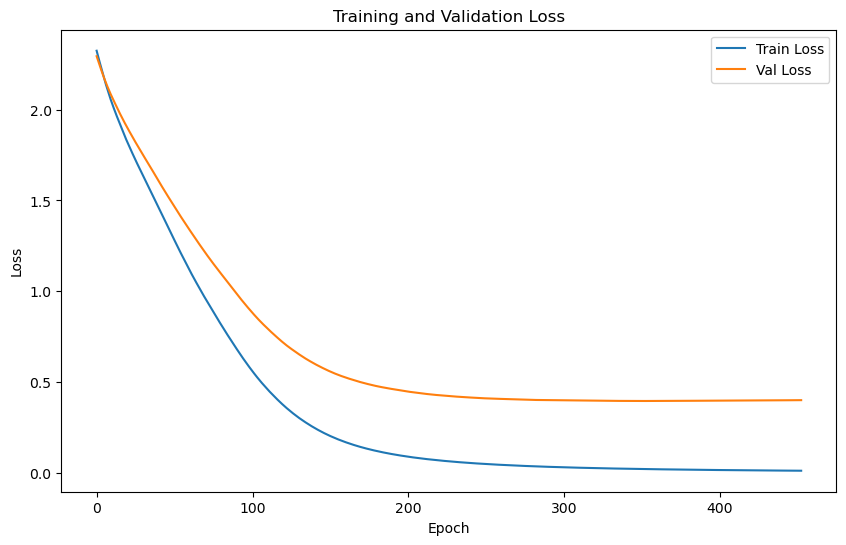

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.3044 | Test Accuracy: 91.06%


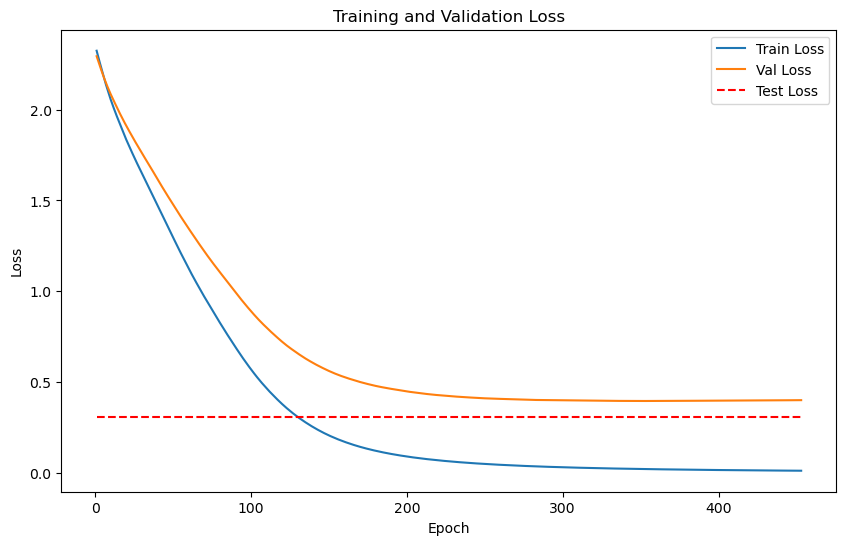

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


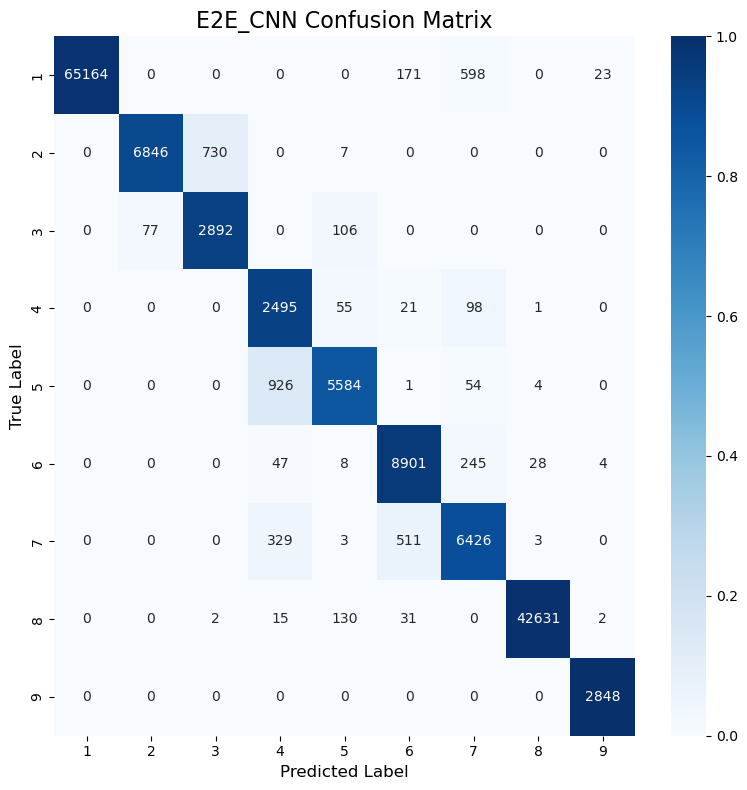

Classification Accuracy: 97.14%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


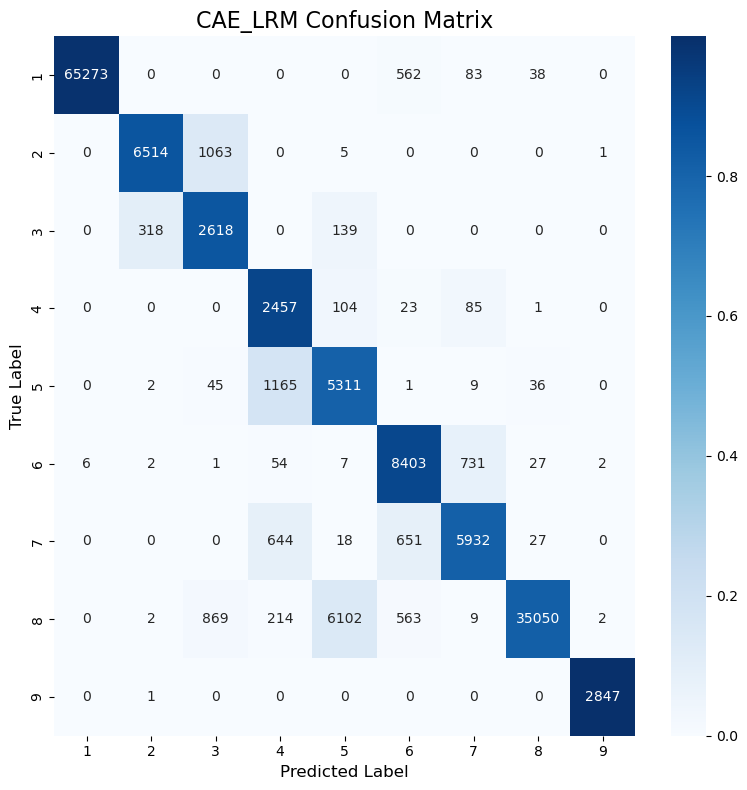

Classification Accuracy: 90.80%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


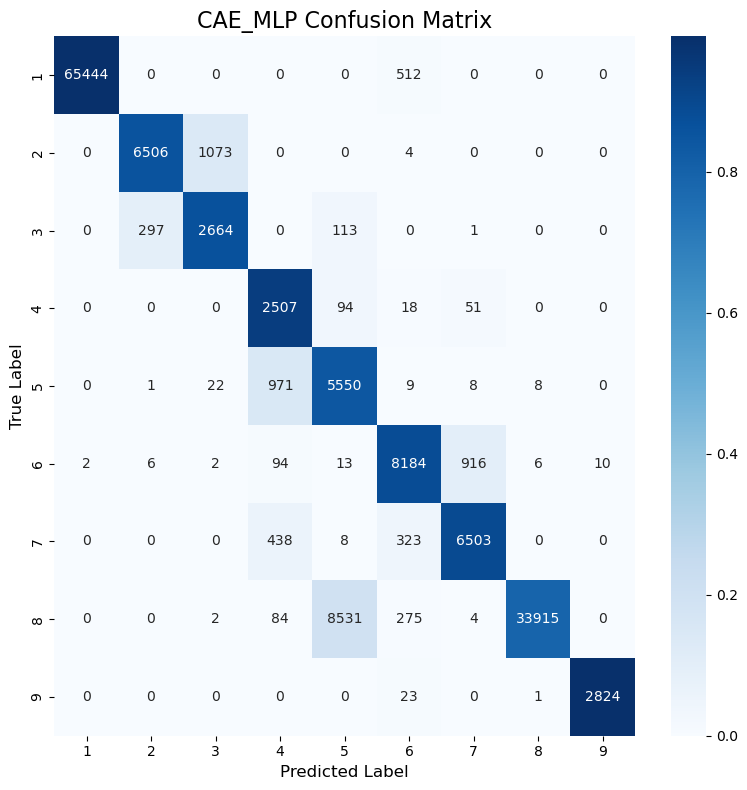

Classification Accuracy: 90.60%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


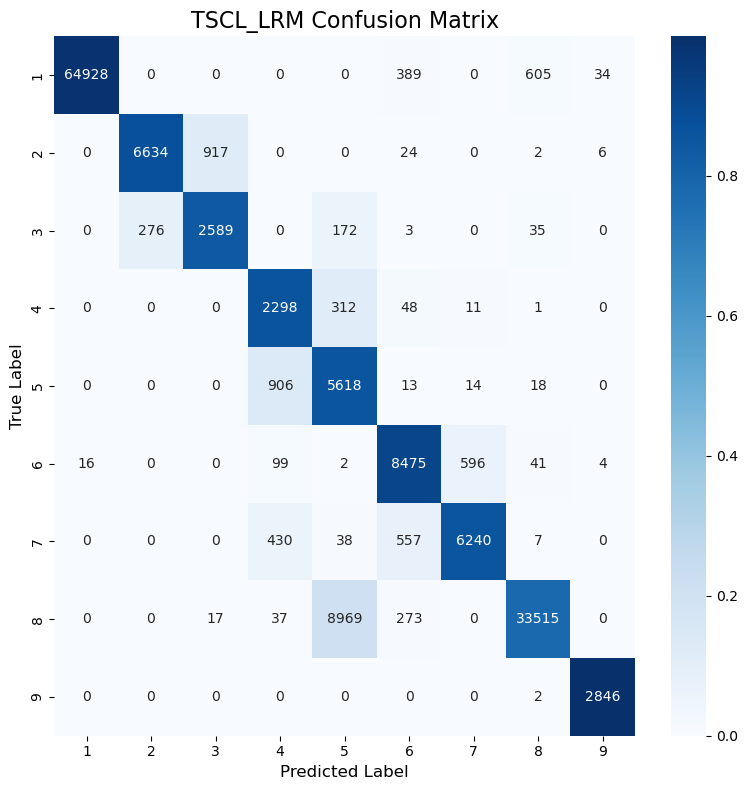

Classification Accuracy: 89.95%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


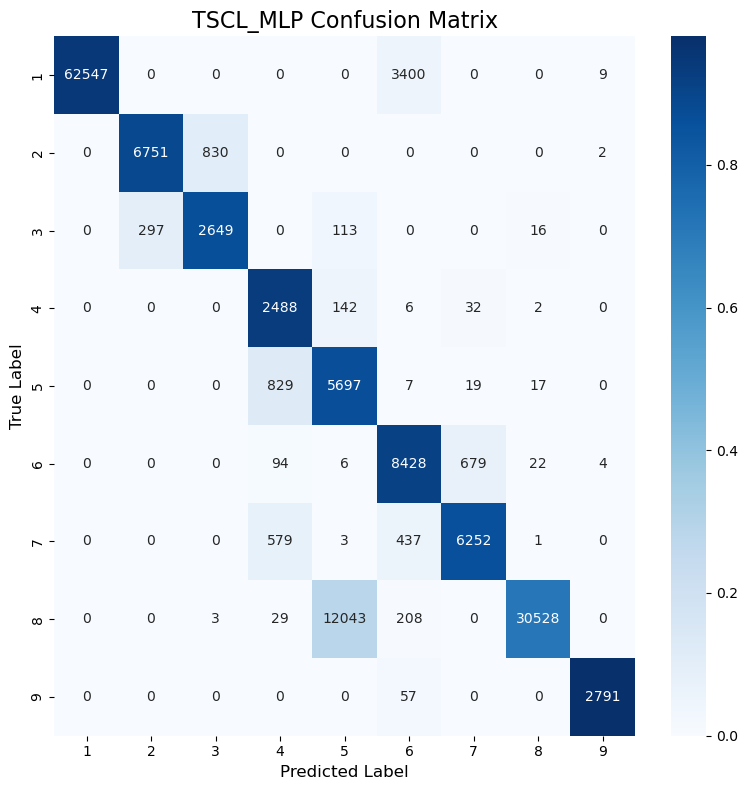

Classification Accuracy: 86.57%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


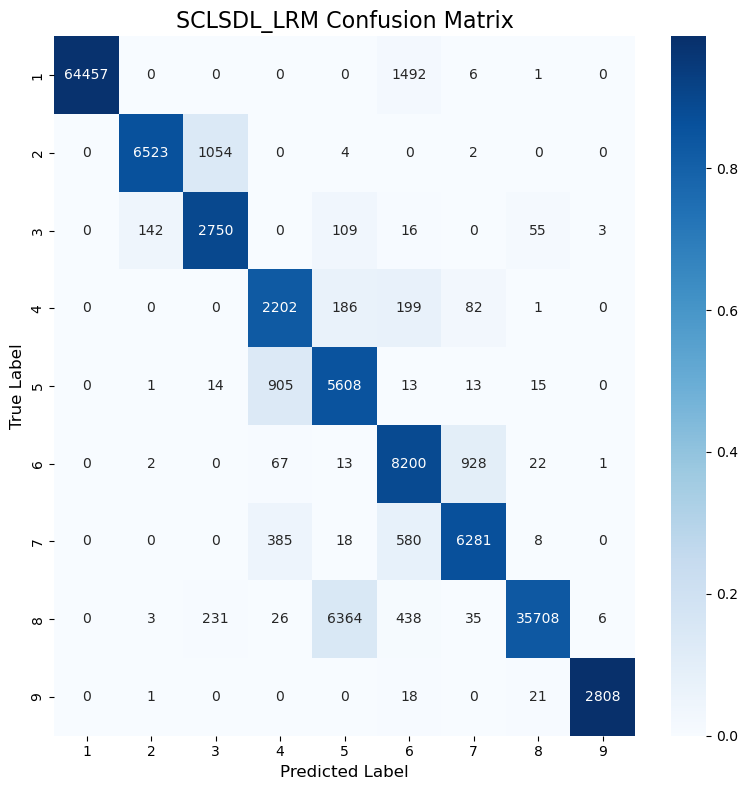

Classification Accuracy: 90.89%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


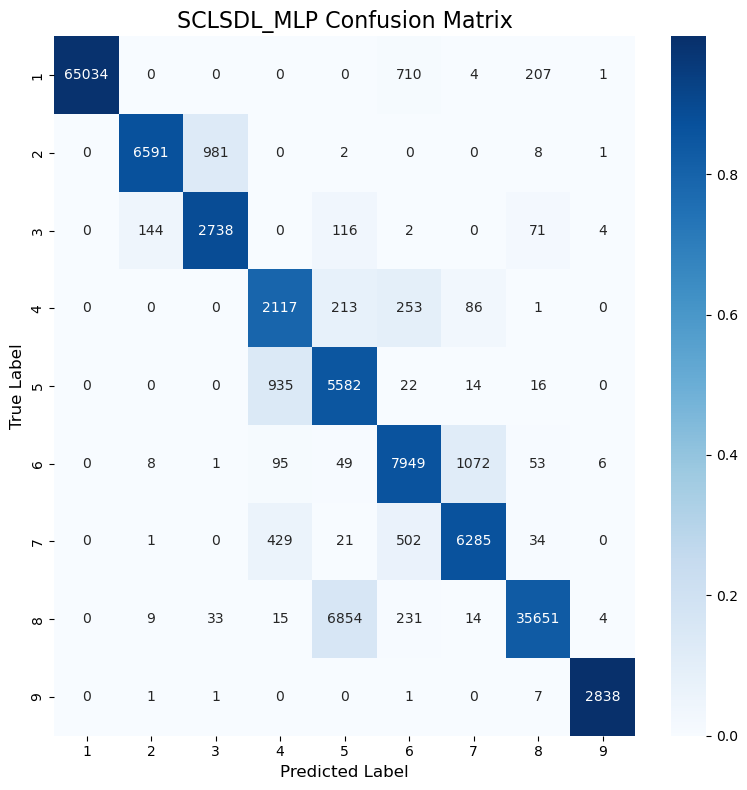

Classification Accuracy: 91.06%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          97.14
1    LRM (CAE)          90.80
2    MLP (CAE)          90.60
3     TSCL LRM          89.95
4     TSCL MLP          86.57
5  SCL_SDL LRM          90.89
6  SCL_SDL MLP          91.06

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          97.14
6  SCL_SDL MLP          91.06
5  SCL_SDL LRM          90.89
1    LRM (CAE)          90.80
2    MLP (CAE)          90.60
3     TSCL LRM          89.95
4     TSCL MLP          86.57
